In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [15]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [16]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [17]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [22]:
binning_method='healpix'
nside=8
bin_space='radec'
specific_years=[2014]
# specific_months=[12],
# specific_days=[15, 16, 17],
include_default_features=True
include_bin_features=False
do_z_score_norm=True
do_cyclical_norm=True

In [23]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    # specific_months=[12],
    # specific_days=[15, 16, 17],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

In [24]:
dataset.cyclical_feature_names

['ra', 'az', 'ha']

## Check that normalizations are working

In [25]:
for i, feat_name in enumerate(dataset.state_feature_names):
    print(feat_name, (dataset._df[feat_name].to_numpy() == dataset.next_states[:, i]).all())


ra_cos tensor(True)
ra_sin tensor(True)
dec tensor(False)
az_cos tensor(True)
az_sin tensor(True)
el tensor(False)
airmass tensor(False)
ha_cos tensor(True)
ha_sin tensor(True)
sun_ra_cos tensor(True)
sun_ra_sin tensor(True)
sun_dec tensor(False)
sun_az_cos tensor(True)
sun_az_sin tensor(True)
sun_el tensor(False)
moon_ra_cos tensor(True)
moon_ra_sin tensor(True)
moon_dec tensor(False)
moon_az_cos tensor(True)
moon_az_sin tensor(True)
moon_el tensor(False)
time_fraction_since_start tensor(False)


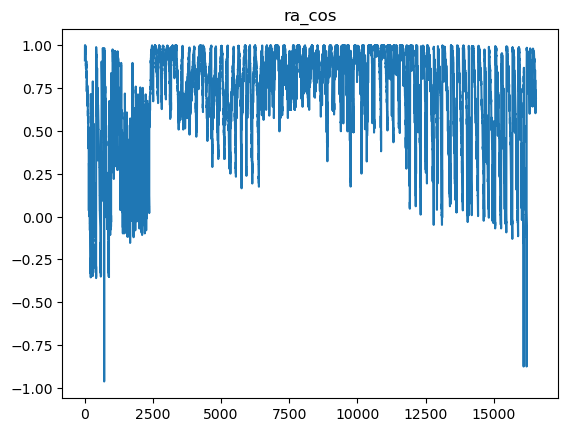

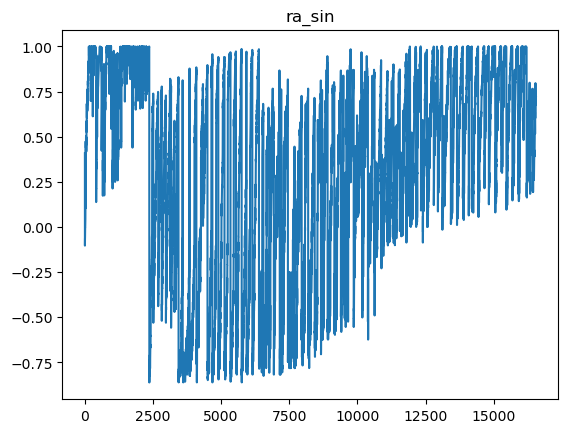

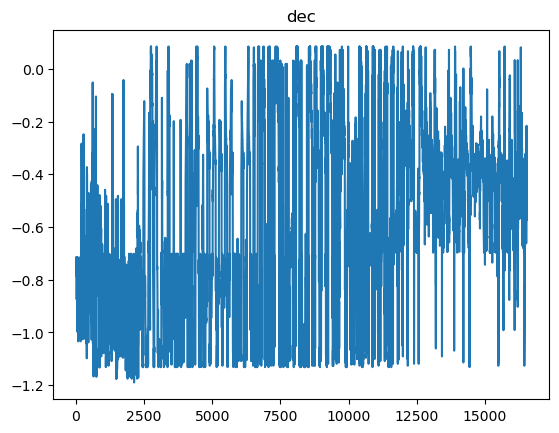

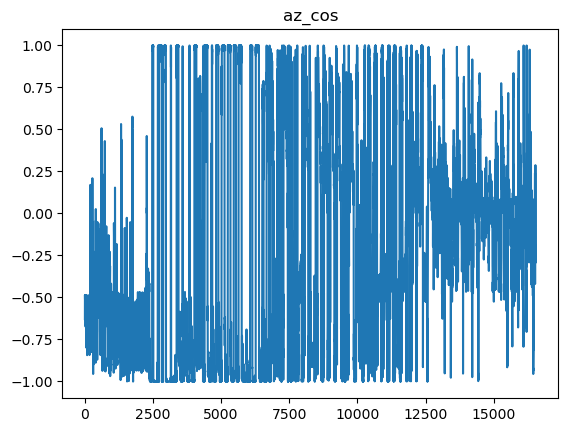

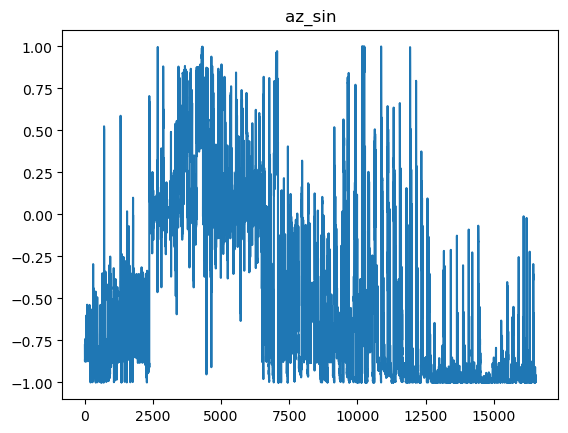

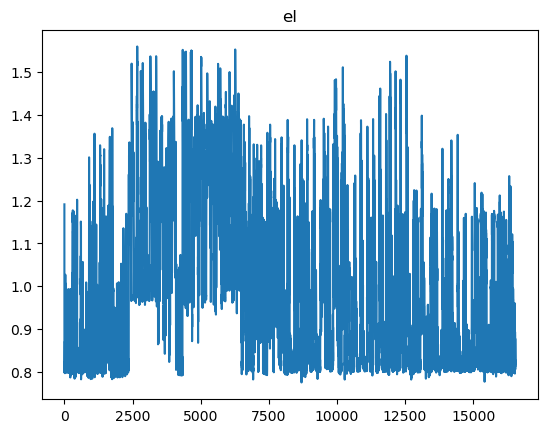

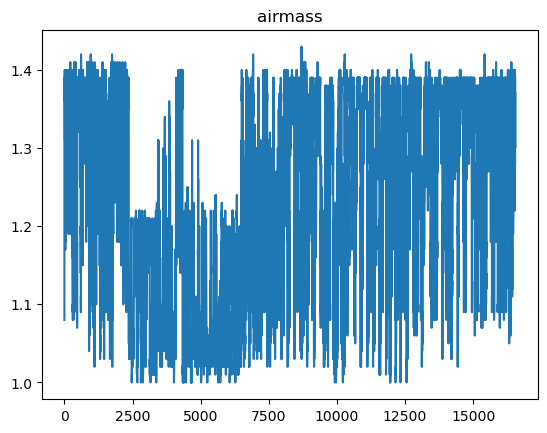

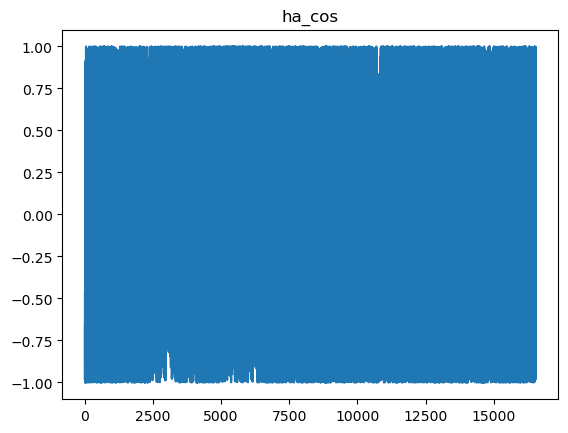

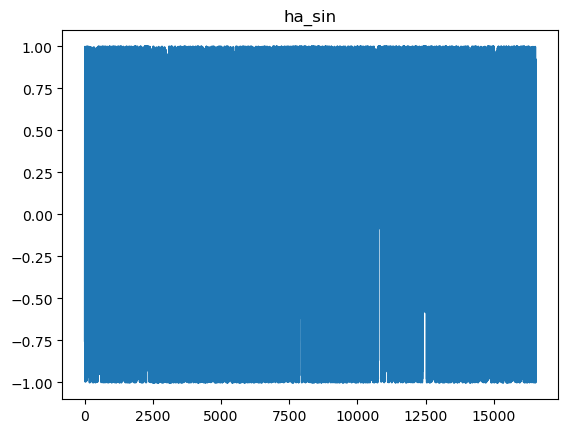

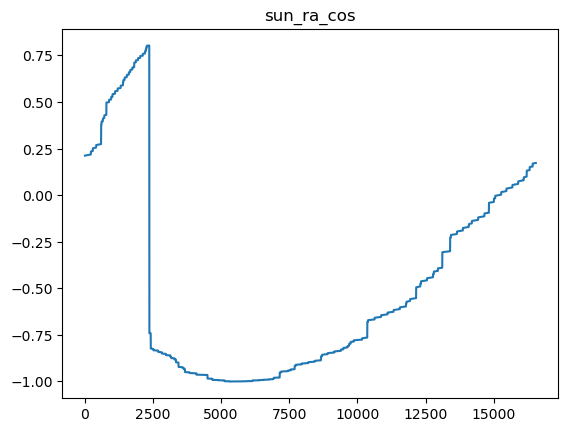

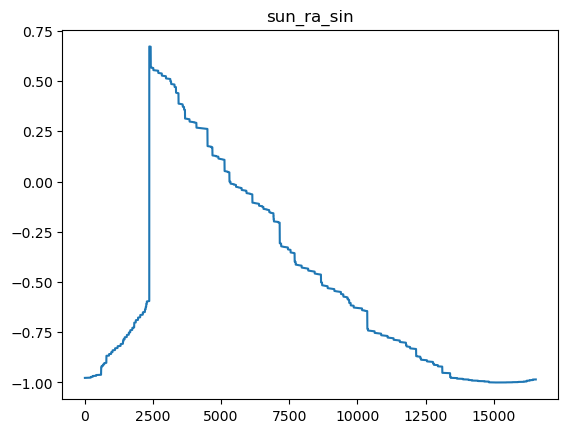

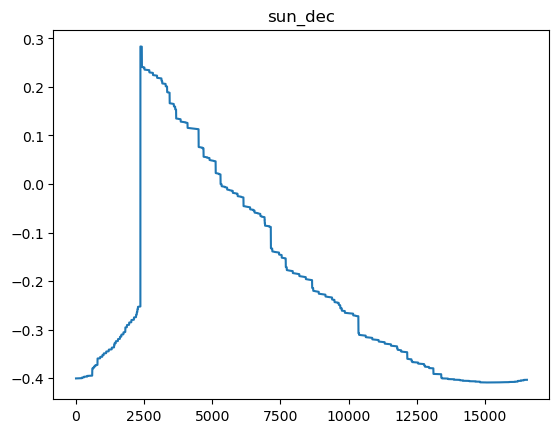

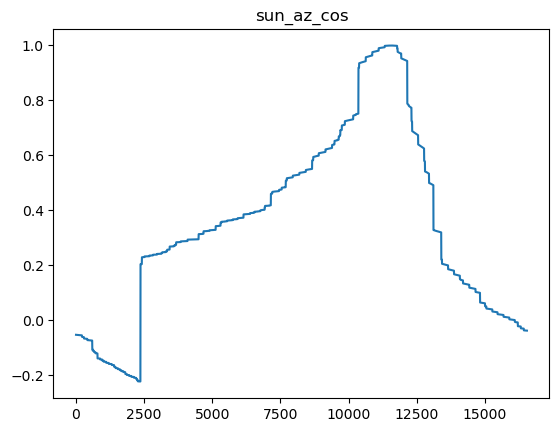

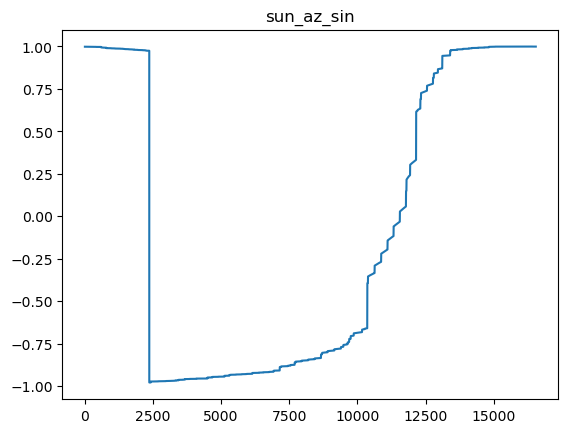

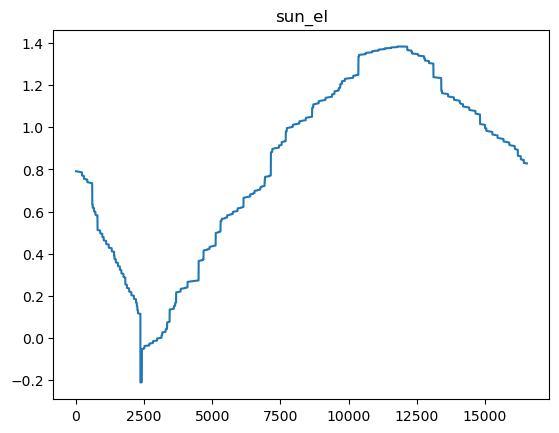

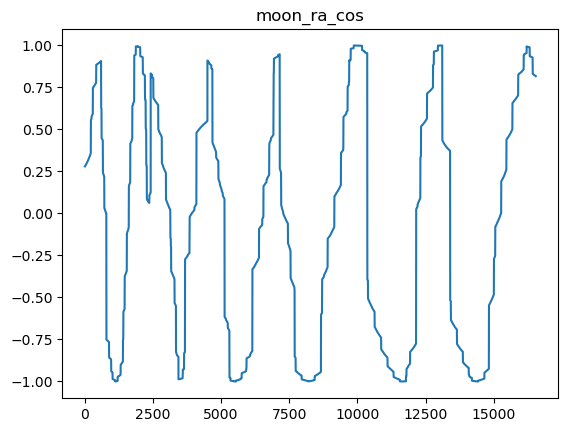

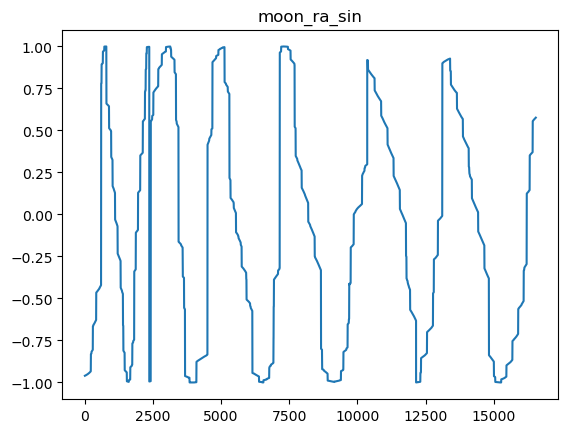

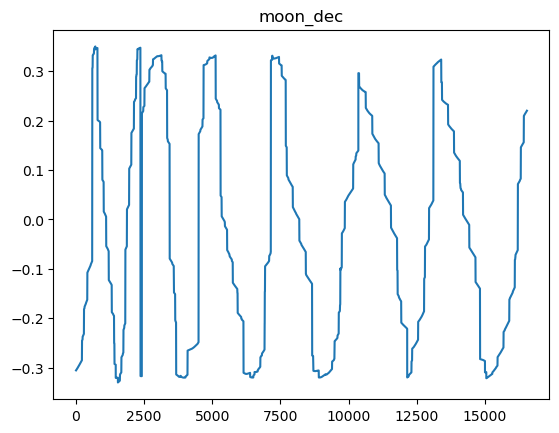

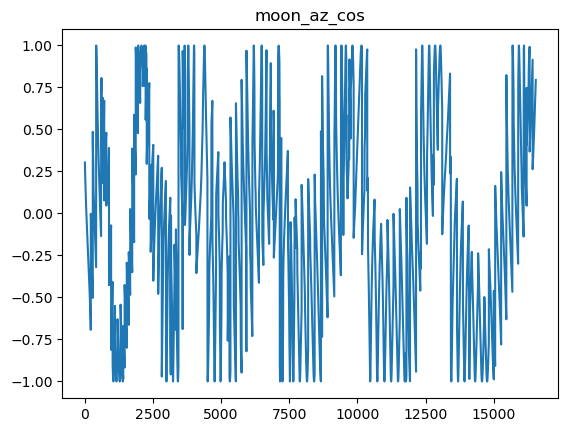

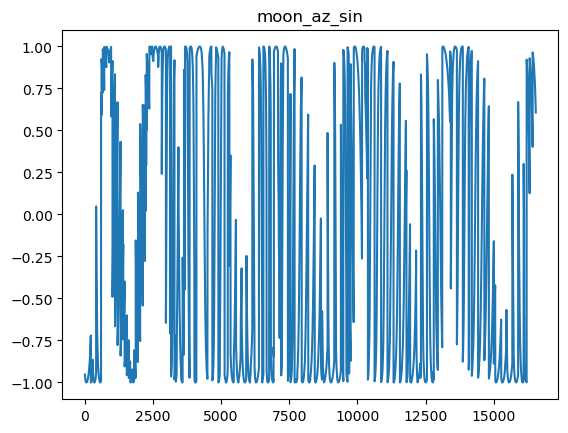

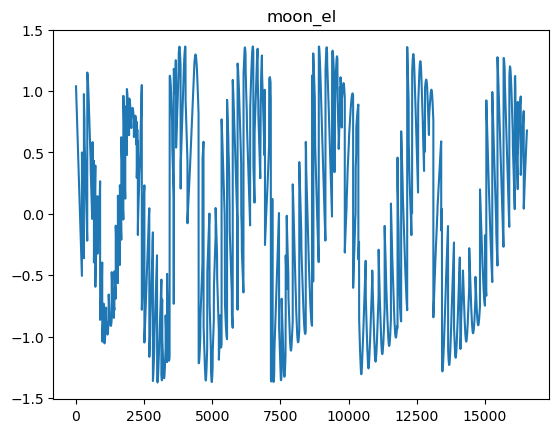

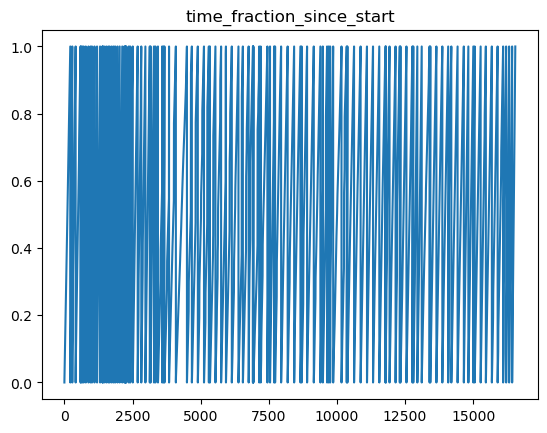

In [31]:
for i, feat_name in enumerate(dataset.state_feature_names):
    plt.plot(dataset._df[feat_name].to_numpy())
    plt.title(feat_name)
    plt.show();

# Visualize dataset in az, el and ra, dec

In [33]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

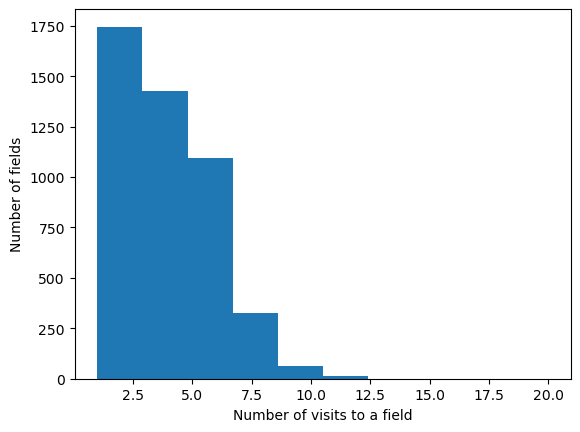

In [34]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

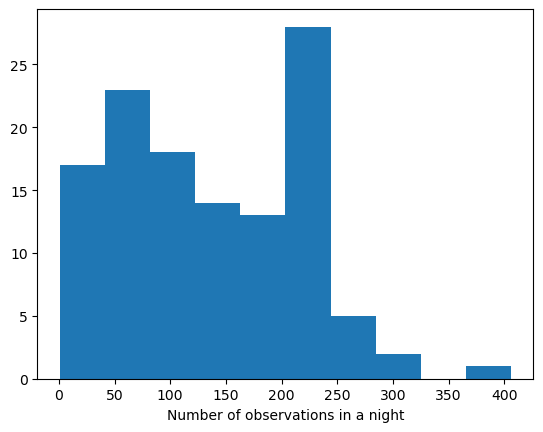

In [35]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

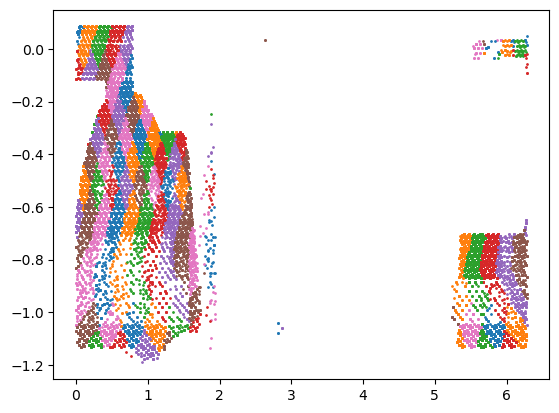

In [36]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [37]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [38]:
dataset.do_z_score_norm

True

In [39]:
dataset.do_cyclical_norm

True

In [40]:
"""Algorithm and Train setup"""
exp_name_prefix = 'Zscore_on_Cyclical_on_'

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 128,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 10,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [41]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [42]:
try:
    agent.load(filepath=outdir + 'weights.pt')
except:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s')

  0%|                                                | 0/165470 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                     | 230/165470 [00:00<03:44, 735.03it/s]

Train step 0: Accuracy = 0.000, Loss = 6.6368, Q-val=0.000
Train step 100: Accuracy = 0.156, Loss = 3.1396, Q-val=0.000
Train step 200: Accuracy = 0.344, Loss = 2.5390, Q-val=0.000


  0%|                                     | 460/165470 [00:00<02:50, 967.67it/s]

Train step 300: Accuracy = 0.281, Loss = 2.7775, Q-val=0.000
Train step 400: Accuracy = 0.219, Loss = 2.3898, Q-val=0.000
Train step 500: Accuracy = 0.406, Loss = 2.0610, Q-val=0.000


  0%|▏                                   | 804/165470 [00:00<02:31, 1084.88it/s]

Train step 600: Accuracy = 0.531, Loss = 2.1378, Q-val=0.000
Train step 700: Accuracy = 0.281, Loss = 1.7293, Q-val=0.000
Train step 800: Accuracy = 0.281, Loss = 2.0549, Q-val=0.000


  1%|▏                                  | 1029/165470 [00:01<02:29, 1101.01it/s]

Train step 900: Accuracy = 0.531, Loss = 1.3911, Q-val=0.000
Train step 1000: Accuracy = 0.344, Loss = 2.3440, Q-val=0.000
Train step 1100: Accuracy = 0.438, Loss = 1.4300, Q-val=0.000


  1%|▎                                  | 1373/165470 [00:01<02:26, 1123.70it/s]

Train step 1200: Accuracy = 0.375, Loss = 2.0305, Q-val=0.000
Train step 1300: Accuracy = 0.375, Loss = 1.2684, Q-val=0.000
Train step 1400: Accuracy = 0.406, Loss = 1.7092, Q-val=0.000


  1%|▎                                  | 1714/165470 [00:01<02:25, 1125.05it/s]

Train step 1500: Accuracy = 0.500, Loss = 1.5252, Q-val=0.000
Train step 1600: Accuracy = 0.562, Loss = 1.5666, Q-val=0.000
Train step 1700: Accuracy = 0.469, Loss = 1.5208, Q-val=0.000


  1%|▍                                  | 1945/165470 [00:01<02:23, 1137.75it/s]

Train step 1800: Accuracy = 0.438, Loss = 1.6728, Q-val=0.000
Train step 1900: Accuracy = 0.688, Loss = 1.3057, Q-val=0.000
Train step 2000: Accuracy = 0.562, Loss = 1.5195, Q-val=0.000


  1%|▍                                  | 2295/165470 [00:02<02:21, 1151.01it/s]

Train step 2100: Accuracy = 0.406, Loss = 1.7444, Q-val=0.000
Train step 2200: Accuracy = 0.500, Loss = 1.6007, Q-val=0.000
Train step 2300: Accuracy = 0.406, Loss = 1.0976, Q-val=0.000


  2%|▌                                  | 2530/165470 [00:02<02:20, 1158.93it/s]

Train step 2400: Accuracy = 0.625, Loss = 1.3308, Q-val=0.000
Train step 2500: Accuracy = 0.531, Loss = 1.2974, Q-val=0.000
Train step 2600: Accuracy = 0.469, Loss = 1.3157, Q-val=0.000


  2%|▌                                  | 2880/165470 [00:02<02:21, 1147.37it/s]

Train step 2700: Accuracy = 0.500, Loss = 1.4092, Q-val=0.000
Train step 2800: Accuracy = 0.594, Loss = 1.5715, Q-val=0.000
Train step 2900: Accuracy = 0.375, Loss = 1.4614, Q-val=0.000


  2%|▋                                  | 3238/165470 [00:03<02:17, 1179.78it/s]

Train step 3000: Accuracy = 0.469, Loss = 1.9573, Q-val=0.000
Train step 3100: Accuracy = 0.656, Loss = 1.4606, Q-val=0.000
Train step 3200: Accuracy = 0.531, Loss = 1.4528, Q-val=0.000


  2%|▋                                  | 3476/165470 [00:03<02:17, 1177.20it/s]

Train step 3300: Accuracy = 0.469, Loss = 1.2034, Q-val=0.000
Train step 3400: Accuracy = 0.469, Loss = 1.2448, Q-val=0.000
Train step 3500: Accuracy = 0.594, Loss = 1.1480, Q-val=0.000


  2%|▊                                  | 3715/165470 [00:03<02:18, 1167.23it/s]

Train step 3600: Accuracy = 0.531, Loss = 1.3517, Q-val=0.000
Train step 3700: Accuracy = 0.344, Loss = 1.6643, Q-val=0.000
Train step 3800: Accuracy = 0.406, Loss = 1.3750, Q-val=0.000


  2%|▊                                  | 4068/165470 [00:03<02:18, 1164.59it/s]

Train step 3900: Accuracy = 0.375, Loss = 2.0027, Q-val=0.000
Train step 4000: Accuracy = 0.531, Loss = 1.4449, Q-val=0.000
Train step 4100: Accuracy = 0.562, Loss = 1.3941, Q-val=0.000


  3%|▉                                  | 4420/165470 [00:04<02:19, 1153.75it/s]

Train step 4200: Accuracy = 0.500, Loss = 1.5093, Q-val=0.000
Train step 4300: Accuracy = 0.594, Loss = 1.5015, Q-val=0.000
Train step 4400: Accuracy = 0.656, Loss = 1.5307, Q-val=0.000


  3%|▉                                  | 4657/165470 [00:04<02:18, 1161.79it/s]

Train step 4500: Accuracy = 0.406, Loss = 1.3360, Q-val=0.000
Train step 4600: Accuracy = 0.344, Loss = 1.4520, Q-val=0.000
Train step 4700: Accuracy = 0.500, Loss = 1.5989, Q-val=0.000


  3%|█                                  | 5010/165470 [00:04<02:18, 1155.01it/s]

Train step 4800: Accuracy = 0.625, Loss = 1.5636, Q-val=0.000
Train step 4900: Accuracy = 0.656, Loss = 1.4779, Q-val=0.000
Train step 5000: Accuracy = 0.688, Loss = 1.8604, Q-val=0.000


  3%|█                                  | 5242/165470 [00:04<02:20, 1143.91it/s]

Train step 5100: Accuracy = 0.500, Loss = 1.5588, Q-val=0.000
Train step 5200: Accuracy = 0.562, Loss = 1.2652, Q-val=0.000
Train step 5300: Accuracy = 0.312, Loss = 1.6020, Q-val=0.000


  3%|█▏                                 | 5589/165470 [00:05<02:19, 1148.54it/s]

Train step 5400: Accuracy = 0.469, Loss = 1.2751, Q-val=0.000
Train step 5500: Accuracy = 0.531, Loss = 1.4826, Q-val=0.000
Train step 5600: Accuracy = 0.531, Loss = 1.0614, Q-val=0.000


  4%|█▏                                 | 5821/165470 [00:05<02:19, 1146.81it/s]

Train step 5700: Accuracy = 0.531, Loss = 1.4928, Q-val=0.000
Train step 5800: Accuracy = 0.719, Loss = 1.7517, Q-val=0.000
Train step 5900: Accuracy = 0.375, Loss = 1.2289, Q-val=0.000


  4%|█▎                                 | 6169/165470 [00:05<02:20, 1135.87it/s]

Train step 6000: Accuracy = 0.594, Loss = 1.2045, Q-val=0.000
Train step 6100: Accuracy = 0.656, Loss = 1.6662, Q-val=0.000
Train step 6200: Accuracy = 0.625, Loss = 1.1513, Q-val=0.000


  4%|█▍                                 | 6514/165470 [00:05<02:19, 1139.08it/s]

Train step 6300: Accuracy = 0.656, Loss = 1.2240, Q-val=0.000
Train step 6400: Accuracy = 0.656, Loss = 1.0454, Q-val=0.000
Train step 6500: Accuracy = 0.656, Loss = 1.5336, Q-val=0.000


  4%|█▍                                 | 6746/165470 [00:06<02:18, 1147.00it/s]

Train step 6600: Accuracy = 0.500, Loss = 1.2858, Q-val=0.000
Train step 6700: Accuracy = 0.688, Loss = 1.2787, Q-val=0.000
Train step 6800: Accuracy = 0.469, Loss = 1.3474, Q-val=0.000


  4%|█▌                                 | 7096/165470 [00:06<02:17, 1149.78it/s]

Train step 6900: Accuracy = 0.688, Loss = 1.4074, Q-val=0.000
Train step 7000: Accuracy = 0.500, Loss = 1.1368, Q-val=0.000
Train step 7100: Accuracy = 0.531, Loss = 1.2196, Q-val=0.000


  4%|█▌                                 | 7329/165470 [00:06<02:17, 1151.15it/s]

Train step 7200: Accuracy = 0.625, Loss = 1.1998, Q-val=0.000
Train step 7300: Accuracy = 0.594, Loss = 1.4792, Q-val=0.000
Train step 7400: Accuracy = 0.719, Loss = 1.4368, Q-val=0.000


  5%|█▌                                 | 7682/165470 [00:06<02:16, 1152.79it/s]

Train step 7500: Accuracy = 0.562, Loss = 0.9042, Q-val=0.000
Train step 7600: Accuracy = 0.625, Loss = 1.6551, Q-val=0.000
Train step 7700: Accuracy = 0.562, Loss = 1.1325, Q-val=0.000


  5%|█▋                                 | 8033/165470 [00:07<02:15, 1161.80it/s]

Train step 7800: Accuracy = 0.781, Loss = 1.0284, Q-val=0.000
Train step 7900: Accuracy = 0.500, Loss = 1.2262, Q-val=0.000
Train step 8000: Accuracy = 0.625, Loss = 0.9740, Q-val=0.000


  5%|█▋                                 | 8266/165470 [00:07<02:16, 1154.23it/s]

Train step 8100: Accuracy = 0.500, Loss = 0.9604, Q-val=0.000
Train step 8200: Accuracy = 0.562, Loss = 0.8108, Q-val=0.000
Train step 8300: Accuracy = 0.562, Loss = 1.1411, Q-val=0.000


  5%|█▊                                 | 8616/165470 [00:07<02:16, 1149.47it/s]

Train step 8400: Accuracy = 0.625, Loss = 0.9787, Q-val=0.000
Train step 8500: Accuracy = 0.719, Loss = 1.2352, Q-val=0.000
Train step 8600: Accuracy = 0.531, Loss = 1.0738, Q-val=0.000


  5%|█▊                                 | 8862/165470 [00:07<02:12, 1186.42it/s]

Train step 8700: Accuracy = 0.594, Loss = 1.0048, Q-val=0.000
Train step 8800: Accuracy = 0.625, Loss = 1.4192, Q-val=0.000
Train step 8900: Accuracy = 0.531, Loss = 1.1281, Q-val=0.000


  6%|█▉                                 | 9224/165470 [00:08<02:10, 1196.76it/s]

Train step 9000: Accuracy = 0.562, Loss = 1.0670, Q-val=0.000
Train step 9100: Accuracy = 0.594, Loss = 1.1153, Q-val=0.000
Train step 9200: Accuracy = 0.500, Loss = 1.1518, Q-val=0.000


  6%|██                                 | 9464/165470 [00:08<02:13, 1166.87it/s]

Train step 9300: Accuracy = 0.625, Loss = 1.0810, Q-val=0.000
Train step 9400: Accuracy = 0.500, Loss = 1.2658, Q-val=0.000
Train step 9500: Accuracy = 0.500, Loss = 0.8166, Q-val=0.000


  6%|██                                 | 9813/165470 [00:08<02:15, 1148.93it/s]

Train step 9600: Accuracy = 0.625, Loss = 1.5267, Q-val=0.000
Train step 9700: Accuracy = 0.594, Loss = 0.9282, Q-val=0.000
Train step 9800: Accuracy = 0.656, Loss = 1.1520, Q-val=0.000


  6%|██                                | 10044/165470 [00:08<02:15, 1150.07it/s]

Train step 9900: Accuracy = 0.438, Loss = 1.2474, Q-val=0.000
Train step 10000: Accuracy = 0.656, Loss = 0.9407, Q-val=0.000
Train step 10100: Accuracy = 0.562, Loss = 1.0905, Q-val=0.000


  6%|██▏                               | 10393/165470 [00:09<02:14, 1150.84it/s]

Train step 10200: Accuracy = 0.500, Loss = 1.4565, Q-val=0.000
Train step 10300: Accuracy = 0.625, Loss = 1.0731, Q-val=0.000
Train step 10400: Accuracy = 0.719, Loss = 1.5462, Q-val=0.000


  6%|██▏                               | 10625/165470 [00:09<02:14, 1148.94it/s]

Train step 10500: Accuracy = 0.594, Loss = 0.8930, Q-val=0.000
Train step 10600: Accuracy = 0.594, Loss = 0.9593, Q-val=0.000
Train step 10700: Accuracy = 0.531, Loss = 0.9914, Q-val=0.000


  7%|██▎                               | 10982/165470 [00:09<02:10, 1179.30it/s]

Train step 10800: Accuracy = 0.625, Loss = 1.3427, Q-val=0.000
Train step 10900: Accuracy = 0.562, Loss = 1.0993, Q-val=0.000
Train step 11000: Accuracy = 0.625, Loss = 1.1228, Q-val=0.000


  7%|██▎                               | 11220/165470 [00:09<02:10, 1181.29it/s]

Train step 11100: Accuracy = 0.438, Loss = 1.6506, Q-val=0.000
Train step 11200: Accuracy = 0.688, Loss = 1.5657, Q-val=0.000
Train step 11300: Accuracy = 0.594, Loss = 0.8653, Q-val=0.000


  7%|██▍                               | 11573/165470 [00:10<02:12, 1162.55it/s]

Train step 11400: Accuracy = 0.469, Loss = 0.8900, Q-val=0.000
Train step 11500: Accuracy = 0.594, Loss = 1.1787, Q-val=0.000
Train step 11600: Accuracy = 0.594, Loss = 0.7075, Q-val=0.000


  7%|██▍                               | 11929/165470 [00:10<02:10, 1175.48it/s]

Train step 11700: Accuracy = 0.562, Loss = 1.6357, Q-val=0.000
Train step 11800: Accuracy = 0.750, Loss = 0.9808, Q-val=0.000
Train step 11900: Accuracy = 0.562, Loss = 0.8174, Q-val=0.000


  7%|██▍                               | 12165/165470 [00:10<02:10, 1174.30it/s]

Train step 12000: Accuracy = 0.688, Loss = 1.2486, Q-val=0.000
Train step 12100: Accuracy = 0.656, Loss = 1.1572, Q-val=0.000
Train step 12200: Accuracy = 0.562, Loss = 0.9454, Q-val=0.000


  8%|██▌                               | 12524/165470 [00:11<02:08, 1185.73it/s]

Train step 12300: Accuracy = 0.594, Loss = 1.0781, Q-val=0.000
Train step 12400: Accuracy = 0.750, Loss = 1.3343, Q-val=0.000
Train step 12500: Accuracy = 0.656, Loss = 1.1344, Q-val=0.000


  8%|██▌                               | 12762/165470 [00:11<02:09, 1183.15it/s]

Train step 12600: Accuracy = 0.656, Loss = 1.1053, Q-val=0.000
Train step 12700: Accuracy = 0.625, Loss = 1.2118, Q-val=0.000
Train step 12800: Accuracy = 0.594, Loss = 1.0463, Q-val=0.000


  8%|██▋                               | 13126/165470 [00:11<02:08, 1184.41it/s]

Train step 12900: Accuracy = 0.625, Loss = 0.9459, Q-val=0.000
Train step 13000: Accuracy = 0.469, Loss = 1.0764, Q-val=0.000
Train step 13100: Accuracy = 0.688, Loss = 1.5300, Q-val=0.000


  8%|██▋                               | 13367/165470 [00:11<02:08, 1186.04it/s]

Train step 13200: Accuracy = 0.656, Loss = 1.2329, Q-val=0.000
Train step 13300: Accuracy = 0.562, Loss = 1.1827, Q-val=0.000
Train step 13400: Accuracy = 0.594, Loss = 0.9166, Q-val=0.000


  8%|██▊                               | 13725/165470 [00:12<02:07, 1185.69it/s]

Train step 13500: Accuracy = 0.500, Loss = 1.1097, Q-val=0.000
Train step 13600: Accuracy = 0.750, Loss = 0.9117, Q-val=0.000
Train step 13700: Accuracy = 0.625, Loss = 0.8748, Q-val=0.000


  8%|██▊                               | 13963/165470 [00:12<02:08, 1181.48it/s]

Train step 13800: Accuracy = 0.562, Loss = 1.0025, Q-val=0.000
Train step 13900: Accuracy = 0.594, Loss = 1.2815, Q-val=0.000
Train step 14000: Accuracy = 0.750, Loss = 1.3519, Q-val=0.000


  9%|██▉                               | 14320/165470 [00:12<02:07, 1181.01it/s]

Train step 14100: Accuracy = 0.656, Loss = 0.9893, Q-val=0.000
Train step 14200: Accuracy = 0.656, Loss = 0.9494, Q-val=0.000
Train step 14300: Accuracy = 0.719, Loss = 1.0886, Q-val=0.000


  9%|██▉                               | 14557/165470 [00:12<02:10, 1157.74it/s]

Train step 14400: Accuracy = 0.594, Loss = 0.8989, Q-val=0.000
Train step 14500: Accuracy = 0.625, Loss = 0.9918, Q-val=0.000
Train step 14600: Accuracy = 0.562, Loss = 0.9288, Q-val=0.000


  9%|███                               | 14907/165470 [00:13<02:10, 1149.85it/s]

Train step 14700: Accuracy = 0.750, Loss = 0.7029, Q-val=0.000
Train step 14800: Accuracy = 0.656, Loss = 1.1666, Q-val=0.000
Train step 14900: Accuracy = 0.844, Loss = 1.0153, Q-val=0.000


  9%|███                               | 15144/165470 [00:13<02:09, 1162.50it/s]

Train step 15000: Accuracy = 0.625, Loss = 1.2714, Q-val=0.000
Train step 15100: Accuracy = 0.625, Loss = 1.2769, Q-val=0.000
Train step 15200: Accuracy = 0.500, Loss = 1.0542, Q-val=0.000


  9%|███▏                              | 15500/165470 [00:13<02:09, 1156.39it/s]

Train step 15300: Accuracy = 0.594, Loss = 0.9546, Q-val=0.000
Train step 15400: Accuracy = 0.656, Loss = 1.1260, Q-val=0.000
Train step 15500: Accuracy = 0.750, Loss = 1.1706, Q-val=0.000


 10%|███▏                              | 15732/165470 [00:13<02:09, 1154.81it/s]

Train step 15600: Accuracy = 0.625, Loss = 0.9987, Q-val=0.000
Train step 15700: Accuracy = 0.500, Loss = 1.1290, Q-val=0.000
Train step 15800: Accuracy = 0.594, Loss = 1.1943, Q-val=0.000


 10%|███▎                              | 16089/165470 [00:14<02:09, 1156.76it/s]

Train step 15900: Accuracy = 0.625, Loss = 0.7155, Q-val=0.000
Train step 16000: Accuracy = 0.469, Loss = 1.1569, Q-val=0.000
Train step 16100: Accuracy = 0.656, Loss = 0.6767, Q-val=0.000


 10%|███▎                              | 16323/165470 [00:14<02:08, 1156.76it/s]

Train step 16200: Accuracy = 0.625, Loss = 0.8471, Q-val=0.000
Train step 16300: Accuracy = 0.750, Loss = 0.9333, Q-val=0.000
Train step 16400: Accuracy = 0.719, Loss = 0.7011, Q-val=0.000


 10%|███▍                              | 16674/165470 [00:14<02:08, 1155.64it/s]

Train step 16500: Accuracy = 0.688, Loss = 1.4399, Q-val=0.000
Train step 16600: Accuracy = 0.719, Loss = 0.8515, Q-val=0.000
Train step 16700: Accuracy = 0.719, Loss = 1.0087, Q-val=0.000


 10%|███▍                              | 17021/165470 [00:14<02:10, 1141.01it/s]

Train step 16800: Accuracy = 0.656, Loss = 1.0533, Q-val=0.000
Train step 16900: Accuracy = 0.656, Loss = 0.9038, Q-val=0.000
Train step 17000: Accuracy = 0.719, Loss = 0.5187, Q-val=0.000


 10%|███▌                              | 17253/165470 [00:15<02:09, 1140.39it/s]

Train step 17100: Accuracy = 0.625, Loss = 0.9692, Q-val=0.000
Train step 17200: Accuracy = 0.625, Loss = 1.1022, Q-val=0.000
Train step 17300: Accuracy = 0.656, Loss = 1.2542, Q-val=0.000


 11%|███▌                              | 17599/165470 [00:15<02:09, 1139.93it/s]

Train step 17400: Accuracy = 0.750, Loss = 0.7061, Q-val=0.000
Train step 17500: Accuracy = 0.562, Loss = 0.8292, Q-val=0.000
Train step 17600: Accuracy = 0.688, Loss = 1.4160, Q-val=0.000


 11%|███▋                              | 17837/165470 [00:15<02:06, 1165.28it/s]

Train step 17700: Accuracy = 0.625, Loss = 0.9986, Q-val=0.000
Train step 17800: Accuracy = 0.625, Loss = 0.6492, Q-val=0.000
Train step 17900: Accuracy = 0.625, Loss = 1.1380, Q-val=0.000


 11%|███▋                              | 18196/165470 [00:15<02:05, 1173.19it/s]

Train step 18000: Accuracy = 0.750, Loss = 1.0742, Q-val=0.000
Train step 18100: Accuracy = 0.719, Loss = 0.7501, Q-val=0.000
Train step 18200: Accuracy = 0.656, Loss = 0.7736, Q-val=0.000


 11%|███▊                              | 18436/165470 [00:16<02:04, 1184.26it/s]

Train step 18300: Accuracy = 0.719, Loss = 1.1663, Q-val=0.000
Train step 18400: Accuracy = 0.781, Loss = 0.7859, Q-val=0.000
Train step 18500: Accuracy = 0.562, Loss = 0.9210, Q-val=0.000


 11%|███▊                              | 18790/165470 [00:16<02:08, 1141.87it/s]

Train step 18600: Accuracy = 0.562, Loss = 1.1618, Q-val=0.000
Train step 18700: Accuracy = 0.594, Loss = 1.0916, Q-val=0.000
Train step 18800: Accuracy = 0.750, Loss = 1.0793, Q-val=0.000


 11%|███▉                              | 19020/165470 [00:16<02:09, 1131.92it/s]

Train step 18900: Accuracy = 0.500, Loss = 0.8200, Q-val=0.000
Train step 19000: Accuracy = 0.625, Loss = 0.8740, Q-val=0.000
Train step 19100: Accuracy = 0.688, Loss = 1.3122, Q-val=0.000


 12%|███▉                              | 19361/165470 [00:16<02:09, 1126.95it/s]

Train step 19200: Accuracy = 0.594, Loss = 1.2408, Q-val=0.000
Train step 19300: Accuracy = 0.719, Loss = 0.7319, Q-val=0.000
Train step 19400: Accuracy = 0.562, Loss = 0.7286, Q-val=0.000


 12%|████                              | 19708/165470 [00:17<02:07, 1145.04it/s]

Train step 19500: Accuracy = 0.562, Loss = 1.2575, Q-val=0.000
Train step 19600: Accuracy = 0.688, Loss = 0.7927, Q-val=0.000
Train step 19700: Accuracy = 0.594, Loss = 0.8823, Q-val=0.000


 12%|████                              | 19948/165470 [00:17<02:04, 1173.23it/s]

Train step 19800: Accuracy = 0.656, Loss = 0.9781, Q-val=0.000
Train step 19900: Accuracy = 0.656, Loss = 0.8975, Q-val=0.000
Train step 20000: Accuracy = 0.719, Loss = 0.9644, Q-val=0.000


 12%|████▏                             | 20300/165470 [00:17<02:05, 1158.27it/s]

Train step 20100: Accuracy = 0.625, Loss = 1.0920, Q-val=0.000
Train step 20200: Accuracy = 0.656, Loss = 0.8806, Q-val=0.000
Train step 20300: Accuracy = 0.750, Loss = 1.0191, Q-val=0.000


 12%|████▏                             | 20534/165470 [00:17<02:05, 1159.09it/s]

Train step 20400: Accuracy = 0.656, Loss = 0.8906, Q-val=0.000
Train step 20500: Accuracy = 0.594, Loss = 1.0745, Q-val=0.000
Train step 20600: Accuracy = 0.625, Loss = 1.1308, Q-val=0.000


 13%|████▎                             | 20900/165470 [00:18<02:00, 1200.95it/s]

Train step 20700: Accuracy = 0.781, Loss = 0.9965, Q-val=0.000
Train step 20800: Accuracy = 0.750, Loss = 1.0298, Q-val=0.000
Train step 20900: Accuracy = 0.594, Loss = 0.5612, Q-val=0.000


 13%|████▎                             | 21140/165470 [00:18<02:02, 1175.84it/s]

Train step 21000: Accuracy = 0.688, Loss = 1.1142, Q-val=0.000
Train step 21100: Accuracy = 0.812, Loss = 1.2848, Q-val=0.000
Train step 21200: Accuracy = 0.500, Loss = 0.7642, Q-val=0.000


 13%|████▍                             | 21491/165470 [00:18<02:04, 1154.00it/s]

Train step 21300: Accuracy = 0.719, Loss = 1.0909, Q-val=0.000
Train step 21400: Accuracy = 0.719, Loss = 1.0546, Q-val=0.000
Train step 21500: Accuracy = 0.688, Loss = 0.5995, Q-val=0.000


 13%|████▍                             | 21729/165470 [00:18<02:03, 1167.67it/s]

Train step 21600: Accuracy = 0.625, Loss = 0.9469, Q-val=0.000
Train step 21700: Accuracy = 0.781, Loss = 0.9428, Q-val=0.000
Train step 21800: Accuracy = 0.625, Loss = 1.0994, Q-val=0.000


 13%|████▌                             | 22089/165470 [00:19<02:00, 1187.93it/s]

Train step 21900: Accuracy = 0.750, Loss = 0.9844, Q-val=0.000
Train step 22000: Accuracy = 0.594, Loss = 1.0448, Q-val=0.000
Train step 22100: Accuracy = 0.719, Loss = 1.2190, Q-val=0.000


 13%|████▌                             | 22326/165470 [00:19<02:02, 1166.62it/s]

Train step 22200: Accuracy = 0.656, Loss = 0.8807, Q-val=0.000
Train step 22300: Accuracy = 0.500, Loss = 1.3167, Q-val=0.000
Train step 22400: Accuracy = 0.719, Loss = 0.5745, Q-val=0.000


 14%|████▋                             | 22679/165470 [00:19<02:02, 1170.15it/s]

Train step 22500: Accuracy = 0.688, Loss = 1.0846, Q-val=0.000
Train step 22600: Accuracy = 0.625, Loss = 1.0421, Q-val=0.000
Train step 22700: Accuracy = 0.719, Loss = 1.0387, Q-val=0.000


 14%|████▋                             | 23031/165470 [00:20<02:03, 1157.28it/s]

Train step 22800: Accuracy = 0.812, Loss = 1.1093, Q-val=0.000
Train step 22900: Accuracy = 0.781, Loss = 0.7813, Q-val=0.000
Train step 23000: Accuracy = 0.625, Loss = 1.1972, Q-val=0.000


 14%|████▊                             | 23263/165470 [00:20<02:03, 1150.41it/s]

Train step 23100: Accuracy = 0.750, Loss = 1.0852, Q-val=0.000
Train step 23200: Accuracy = 0.562, Loss = 0.8053, Q-val=0.000
Train step 23300: Accuracy = 0.719, Loss = 0.8777, Q-val=0.000


 14%|████▊                             | 23615/165470 [00:20<02:02, 1158.47it/s]

Train step 23400: Accuracy = 0.719, Loss = 0.8505, Q-val=0.000
Train step 23500: Accuracy = 0.562, Loss = 1.0603, Q-val=0.000
Train step 23600: Accuracy = 0.750, Loss = 0.9251, Q-val=0.000


 14%|████▉                             | 23854/165470 [00:20<02:00, 1172.83it/s]

Train step 23700: Accuracy = 0.688, Loss = 0.6772, Q-val=0.000
Train step 23800: Accuracy = 0.781, Loss = 0.8402, Q-val=0.000
Train step 23900: Accuracy = 0.688, Loss = 0.7626, Q-val=0.000


 15%|████▉                             | 24206/165470 [00:21<02:02, 1157.61it/s]

Train step 24000: Accuracy = 0.656, Loss = 0.9975, Q-val=0.000
Train step 24100: Accuracy = 0.688, Loss = 1.0509, Q-val=0.000
Train step 24200: Accuracy = 0.438, Loss = 1.6886, Q-val=0.000


 15%|█████                             | 24445/165470 [00:21<02:01, 1163.50it/s]

Train step 24300: Accuracy = 0.688, Loss = 0.8005, Q-val=0.000
Train step 24400: Accuracy = 0.781, Loss = 0.7487, Q-val=0.000
Train step 24500: Accuracy = 0.781, Loss = 0.7286, Q-val=0.000


 15%|█████                             | 24794/165470 [00:21<02:02, 1150.57it/s]

Train step 24600: Accuracy = 0.594, Loss = 0.8758, Q-val=0.000
Train step 24700: Accuracy = 0.688, Loss = 1.1446, Q-val=0.000
Train step 24800: Accuracy = 0.844, Loss = 0.7818, Q-val=0.000


 15%|█████▏                            | 25025/165470 [00:21<02:02, 1143.52it/s]

Train step 24900: Accuracy = 0.625, Loss = 0.7772, Q-val=0.000
Train step 25000: Accuracy = 0.594, Loss = 0.9603, Q-val=0.000
Train step 25100: Accuracy = 0.688, Loss = 1.0082, Q-val=0.000


 15%|█████▏                            | 25376/165470 [00:22<02:01, 1148.38it/s]

Train step 25200: Accuracy = 0.656, Loss = 0.9096, Q-val=0.000
Train step 25300: Accuracy = 0.688, Loss = 0.5576, Q-val=0.000
Train step 25400: Accuracy = 0.719, Loss = 0.5701, Q-val=0.000


 16%|█████▎                            | 25731/165470 [00:22<02:00, 1157.59it/s]

Train step 25500: Accuracy = 0.719, Loss = 0.8710, Q-val=0.000
Train step 25600: Accuracy = 0.781, Loss = 1.1290, Q-val=0.000
Train step 25700: Accuracy = 0.625, Loss = 0.8697, Q-val=0.000


 16%|█████▎                            | 25962/165470 [00:22<02:03, 1128.66it/s]

Train step 25800: Accuracy = 0.562, Loss = 0.9290, Q-val=0.000
Train step 25900: Accuracy = 0.562, Loss = 0.8445, Q-val=0.000
Train step 26000: Accuracy = 0.719, Loss = 0.9339, Q-val=0.000


 16%|█████▍                            | 26307/165470 [00:22<02:02, 1133.39it/s]

Train step 26100: Accuracy = 0.656, Loss = 0.7996, Q-val=0.000
Train step 26200: Accuracy = 0.781, Loss = 0.8646, Q-val=0.000
Train step 26300: Accuracy = 0.719, Loss = 1.0840, Q-val=0.000


 16%|█████▍                            | 26537/165470 [00:23<02:01, 1139.35it/s]

Train step 26400: Accuracy = 0.562, Loss = 0.7762, Q-val=0.000
Train step 26500: Accuracy = 0.719, Loss = 0.6184, Q-val=0.000
Train step 26600: Accuracy = 0.625, Loss = 0.7791, Q-val=0.000


 16%|█████▌                            | 26886/165470 [00:23<02:00, 1153.82it/s]

Train step 26700: Accuracy = 0.688, Loss = 0.7302, Q-val=0.000
Train step 26800: Accuracy = 0.688, Loss = 1.0553, Q-val=0.000
Train step 26900: Accuracy = 0.656, Loss = 0.8379, Q-val=0.000


 16%|█████▌                            | 27117/165470 [00:23<02:00, 1146.42it/s]

Train step 27000: Accuracy = 0.812, Loss = 0.8385, Q-val=0.000
Train step 27100: Accuracy = 0.719, Loss = 0.8903, Q-val=0.000
Train step 27200: Accuracy = 0.594, Loss = 1.0483, Q-val=0.000


 17%|█████▋                            | 27471/165470 [00:23<01:58, 1167.98it/s]

Train step 27300: Accuracy = 0.719, Loss = 0.8159, Q-val=0.000
Train step 27400: Accuracy = 0.781, Loss = 0.6166, Q-val=0.000
Train step 27500: Accuracy = 0.750, Loss = 0.8661, Q-val=0.000


 17%|█████▋                            | 27825/165470 [00:24<01:57, 1172.19it/s]

Train step 27600: Accuracy = 0.625, Loss = 1.1681, Q-val=0.000
Train step 27700: Accuracy = 0.625, Loss = 0.9115, Q-val=0.000
Train step 27800: Accuracy = 0.750, Loss = 1.0474, Q-val=0.000


 17%|█████▊                            | 28064/165470 [00:24<01:56, 1181.99it/s]

Train step 27900: Accuracy = 0.750, Loss = 1.1552, Q-val=0.000
Train step 28000: Accuracy = 0.719, Loss = 0.6618, Q-val=0.000
Train step 28100: Accuracy = 0.688, Loss = 0.7316, Q-val=0.000


 17%|█████▊                            | 28418/165470 [00:24<01:58, 1159.18it/s]

Train step 28200: Accuracy = 0.719, Loss = 0.7865, Q-val=0.000
Train step 28300: Accuracy = 0.688, Loss = 1.0580, Q-val=0.000
Train step 28400: Accuracy = 0.750, Loss = 1.0829, Q-val=0.000


 17%|█████▉                            | 28649/165470 [00:24<01:59, 1144.58it/s]

Train step 28500: Accuracy = 0.656, Loss = 0.8829, Q-val=0.000
Train step 28600: Accuracy = 0.688, Loss = 0.5432, Q-val=0.000
Train step 28700: Accuracy = 0.625, Loss = 0.8573, Q-val=0.000


 18%|█████▉                            | 28996/165470 [00:25<01:58, 1147.14it/s]

Train step 28800: Accuracy = 0.750, Loss = 0.4623, Q-val=0.000
Train step 28900: Accuracy = 0.688, Loss = 0.9416, Q-val=0.000
Train step 29000: Accuracy = 0.688, Loss = 0.8768, Q-val=0.000


 18%|██████                            | 29229/165470 [00:25<01:58, 1146.47it/s]

Train step 29100: Accuracy = 0.781, Loss = 0.7837, Q-val=0.000
Train step 29200: Accuracy = 0.656, Loss = 1.1880, Q-val=0.000
Train step 29300: Accuracy = 0.625, Loss = 0.8215, Q-val=0.000


 18%|██████                            | 29581/165470 [00:25<01:58, 1145.45it/s]

Train step 29400: Accuracy = 0.656, Loss = 0.9750, Q-val=0.000
Train step 29500: Accuracy = 0.656, Loss = 0.8739, Q-val=0.000
Train step 29600: Accuracy = 0.562, Loss = 0.7668, Q-val=0.000


 18%|██████▏                           | 29926/165470 [00:26<01:58, 1144.50it/s]

Train step 29700: Accuracy = 0.688, Loss = 0.5780, Q-val=0.000
Train step 29800: Accuracy = 0.719, Loss = 0.7935, Q-val=0.000
Train step 29900: Accuracy = 0.750, Loss = 0.7022, Q-val=0.000


 18%|██████▏                           | 30161/165470 [00:26<01:56, 1159.26it/s]

Train step 30000: Accuracy = 0.812, Loss = 0.8436, Q-val=0.000
Train step 30100: Accuracy = 0.812, Loss = 0.8119, Q-val=0.000
Train step 30200: Accuracy = 0.781, Loss = 0.5526, Q-val=0.000


 18%|██████▎                           | 30518/165470 [00:26<01:55, 1169.17it/s]

Train step 30300: Accuracy = 0.844, Loss = 0.9936, Q-val=0.000
Train step 30400: Accuracy = 0.719, Loss = 0.8132, Q-val=0.000
Train step 30500: Accuracy = 0.688, Loss = 0.5715, Q-val=0.000


 19%|██████▎                           | 30750/165470 [00:26<01:58, 1134.98it/s]

Train step 30600: Accuracy = 0.750, Loss = 0.7286, Q-val=0.000
Train step 30700: Accuracy = 0.781, Loss = 0.8676, Q-val=0.000
Train step 30800: Accuracy = 0.656, Loss = 0.8067, Q-val=0.000


 19%|██████▍                           | 31092/165470 [00:27<02:00, 1116.78it/s]

Train step 30900: Accuracy = 0.688, Loss = 0.8505, Q-val=0.000
Train step 31000: Accuracy = 0.562, Loss = 1.1341, Q-val=0.000
Train step 31100: Accuracy = 0.531, Loss = 0.6557, Q-val=0.000


 19%|██████▍                           | 31325/165470 [00:27<01:57, 1141.77it/s]

Train step 31200: Accuracy = 0.719, Loss = 0.3932, Q-val=0.000
Train step 31300: Accuracy = 0.562, Loss = 0.9062, Q-val=0.000
Train step 31400: Accuracy = 0.688, Loss = 0.8640, Q-val=0.000


 19%|██████▌                           | 31674/165470 [00:27<01:56, 1152.95it/s]

Train step 31500: Accuracy = 0.719, Loss = 0.5708, Q-val=0.000
Train step 31600: Accuracy = 0.562, Loss = 0.6375, Q-val=0.000
Train step 31700: Accuracy = 0.719, Loss = 0.9298, Q-val=0.000


 19%|██████▌                           | 32033/165470 [00:27<01:53, 1177.12it/s]

Train step 31800: Accuracy = 0.781, Loss = 0.9251, Q-val=0.000
Train step 31900: Accuracy = 0.688, Loss = 0.8677, Q-val=0.000
Train step 32000: Accuracy = 0.594, Loss = 1.2362, Q-val=0.000


 20%|██████▋                           | 32268/165470 [00:28<01:54, 1167.82it/s]

Train step 32100: Accuracy = 0.562, Loss = 1.0368, Q-val=0.000
Train step 32200: Accuracy = 0.812, Loss = 0.6327, Q-val=0.000
Train step 32300: Accuracy = 0.656, Loss = 0.8000, Q-val=0.000


 20%|██████▋                           | 32618/165470 [00:28<01:55, 1148.07it/s]

Train step 32400: Accuracy = 0.688, Loss = 0.7876, Q-val=0.000
Train step 32500: Accuracy = 0.625, Loss = 0.6856, Q-val=0.000
Train step 32600: Accuracy = 0.688, Loss = 0.7658, Q-val=0.000


 20%|██████▊                           | 32851/165470 [00:28<01:54, 1154.01it/s]

Train step 32700: Accuracy = 0.812, Loss = 0.9785, Q-val=0.000
Train step 32800: Accuracy = 0.656, Loss = 0.5505, Q-val=0.000
Train step 32900: Accuracy = 0.750, Loss = 1.1849, Q-val=0.000


 20%|██████▊                           | 33205/165470 [00:28<01:53, 1161.32it/s]

Train step 33000: Accuracy = 0.719, Loss = 0.9269, Q-val=0.000
Train step 33100: Accuracy = 0.625, Loss = 0.7623, Q-val=0.000
Train step 33200: Accuracy = 0.875, Loss = 0.4950, Q-val=0.000


 20%|██████▊                           | 33445/165470 [00:29<01:52, 1175.52it/s]

Train step 33300: Accuracy = 0.656, Loss = 0.6357, Q-val=0.000
Train step 33400: Accuracy = 0.688, Loss = 0.7068, Q-val=0.000
Train step 33500: Accuracy = 0.781, Loss = 0.9332, Q-val=0.000


 20%|██████▉                           | 33797/165470 [00:29<01:53, 1162.78it/s]

Train step 33600: Accuracy = 0.688, Loss = 0.7504, Q-val=0.000
Train step 33700: Accuracy = 0.812, Loss = 0.4921, Q-val=0.000
Train step 33800: Accuracy = 0.781, Loss = 0.8349, Q-val=0.000


 21%|██████▉                           | 34030/165470 [00:29<01:53, 1158.41it/s]

Train step 33900: Accuracy = 0.688, Loss = 0.9370, Q-val=0.000
Train step 34000: Accuracy = 0.719, Loss = 0.6158, Q-val=0.000
Train step 34100: Accuracy = 0.719, Loss = 0.7509, Q-val=0.000


 21%|███████                           | 34378/165470 [00:29<01:54, 1148.81it/s]

Train step 34200: Accuracy = 0.656, Loss = 0.9933, Q-val=0.000
Train step 34300: Accuracy = 0.625, Loss = 0.7374, Q-val=0.000
Train step 34400: Accuracy = 0.781, Loss = 0.6681, Q-val=0.000


 21%|███████▏                          | 34728/165470 [00:30<01:52, 1160.24it/s]

Train step 34500: Accuracy = 0.750, Loss = 0.6923, Q-val=0.000
Train step 34600: Accuracy = 0.688, Loss = 0.6090, Q-val=0.000
Train step 34700: Accuracy = 0.812, Loss = 0.7258, Q-val=0.000


 21%|███████▏                          | 34960/165470 [00:30<01:54, 1138.12it/s]

Train step 34800: Accuracy = 0.719, Loss = 1.1163, Q-val=0.000
Train step 34900: Accuracy = 0.688, Loss = 0.7582, Q-val=0.000
Train step 35000: Accuracy = 0.750, Loss = 0.7587, Q-val=0.000


 21%|███████▎                          | 35309/165470 [00:30<01:54, 1136.10it/s]

Train step 35100: Accuracy = 0.625, Loss = 0.7796, Q-val=0.000
Train step 35200: Accuracy = 0.719, Loss = 0.6414, Q-val=0.000
Train step 35300: Accuracy = 0.562, Loss = 0.8053, Q-val=0.000


 21%|███████▎                          | 35537/165470 [00:30<01:55, 1126.85it/s]

Train step 35400: Accuracy = 0.688, Loss = 1.2592, Q-val=0.000
Train step 35500: Accuracy = 0.688, Loss = 0.6394, Q-val=0.000
Train step 35600: Accuracy = 0.719, Loss = 1.0419, Q-val=0.000


 22%|███████▎                          | 35877/165470 [00:31<01:55, 1124.45it/s]

Train step 35700: Accuracy = 0.750, Loss = 0.6055, Q-val=0.000
Train step 35800: Accuracy = 0.844, Loss = 0.9338, Q-val=0.000
Train step 35900: Accuracy = 0.781, Loss = 0.7962, Q-val=0.000


 22%|███████▍                          | 36218/165470 [00:31<01:54, 1127.73it/s]

Train step 36000: Accuracy = 0.531, Loss = 0.5956, Q-val=0.000
Train step 36100: Accuracy = 0.688, Loss = 0.9960, Q-val=0.000
Train step 36200: Accuracy = 0.750, Loss = 0.5529, Q-val=0.000


 22%|███████▍                          | 36451/165470 [00:31<01:52, 1147.26it/s]

Train step 36300: Accuracy = 0.531, Loss = 0.7232, Q-val=0.000
Train step 36400: Accuracy = 0.750, Loss = 1.2211, Q-val=0.000
Train step 36500: Accuracy = 0.750, Loss = 0.8774, Q-val=0.000


 22%|███████▌                          | 36800/165470 [00:32<01:51, 1151.58it/s]

Train step 36600: Accuracy = 0.531, Loss = 0.7490, Q-val=0.000
Train step 36700: Accuracy = 0.781, Loss = 0.7345, Q-val=0.000
Train step 36800: Accuracy = 0.719, Loss = 0.8462, Q-val=0.000


 22%|███████▌                          | 37031/165470 [00:32<01:52, 1139.64it/s]

Train step 36900: Accuracy = 0.875, Loss = 0.8347, Q-val=0.000
Train step 37000: Accuracy = 0.656, Loss = 0.8243, Q-val=0.000
Train step 37100: Accuracy = 0.781, Loss = 0.8992, Q-val=0.000


 23%|███████▋                          | 37392/165470 [00:32<01:48, 1177.06it/s]

Train step 37200: Accuracy = 0.781, Loss = 0.7590, Q-val=0.000
Train step 37300: Accuracy = 0.812, Loss = 0.8739, Q-val=0.000
Train step 37400: Accuracy = 0.781, Loss = 0.6822, Q-val=0.000


 23%|███████▋                          | 37628/165470 [00:32<01:49, 1171.77it/s]

Train step 37500: Accuracy = 0.750, Loss = 0.8597, Q-val=0.000
Train step 37600: Accuracy = 0.750, Loss = 0.5428, Q-val=0.000
Train step 37700: Accuracy = 0.750, Loss = 0.8706, Q-val=0.000


 23%|███████▊                          | 37982/165470 [00:33<01:50, 1156.47it/s]

Train step 37800: Accuracy = 0.750, Loss = 0.7653, Q-val=0.000
Train step 37900: Accuracy = 0.812, Loss = 0.7152, Q-val=0.000
Train step 38000: Accuracy = 0.562, Loss = 0.5858, Q-val=0.000


 23%|███████▉                          | 38337/165470 [00:33<01:48, 1174.40it/s]

Train step 38100: Accuracy = 0.781, Loss = 0.6678, Q-val=0.000
Train step 38200: Accuracy = 0.688, Loss = 0.8576, Q-val=0.000
Train step 38300: Accuracy = 0.719, Loss = 0.6109, Q-val=0.000


 23%|███████▉                          | 38572/165470 [00:33<01:49, 1163.71it/s]

Train step 38400: Accuracy = 0.719, Loss = 1.0526, Q-val=0.000
Train step 38500: Accuracy = 0.688, Loss = 0.9052, Q-val=0.000
Train step 38600: Accuracy = 0.719, Loss = 0.5860, Q-val=0.000


 24%|███████▉                          | 38923/165470 [00:33<01:49, 1158.69it/s]

Train step 38700: Accuracy = 0.625, Loss = 0.8413, Q-val=0.000
Train step 38800: Accuracy = 0.562, Loss = 0.6047, Q-val=0.000
Train step 38900: Accuracy = 0.719, Loss = 0.7123, Q-val=0.000


 24%|████████                          | 39155/165470 [00:34<01:50, 1142.84it/s]

Train step 39000: Accuracy = 0.812, Loss = 0.6560, Q-val=0.000
Train step 39100: Accuracy = 0.719, Loss = 0.5452, Q-val=0.000
Train step 39200: Accuracy = 0.688, Loss = 0.7542, Q-val=0.000


 24%|████████                          | 39505/165470 [00:34<01:49, 1151.58it/s]

Train step 39300: Accuracy = 0.750, Loss = 0.5344, Q-val=0.000
Train step 39400: Accuracy = 0.750, Loss = 0.5395, Q-val=0.000
Train step 39500: Accuracy = 0.875, Loss = 0.6690, Q-val=0.000


 24%|████████▏                         | 39736/165470 [00:34<01:51, 1127.67it/s]

Train step 39600: Accuracy = 0.625, Loss = 0.7367, Q-val=0.000
Train step 39700: Accuracy = 0.656, Loss = 0.7839, Q-val=0.000
Train step 39800: Accuracy = 0.750, Loss = 0.9693, Q-val=0.000


 24%|████████▏                         | 40085/165470 [00:34<01:49, 1150.19it/s]

Train step 39900: Accuracy = 0.594, Loss = 0.5999, Q-val=0.000
Train step 40000: Accuracy = 0.750, Loss = 0.6945, Q-val=0.000
Train step 40100: Accuracy = 0.719, Loss = 0.4813, Q-val=0.000


 24%|████████▎                         | 40435/165470 [00:35<01:48, 1153.55it/s]

Train step 40200: Accuracy = 0.781, Loss = 0.9276, Q-val=0.000
Train step 40300: Accuracy = 0.688, Loss = 0.4068, Q-val=0.000
Train step 40400: Accuracy = 0.656, Loss = 0.8204, Q-val=0.000


 25%|████████▎                         | 40666/165470 [00:35<01:50, 1129.47it/s]

Train step 40500: Accuracy = 0.750, Loss = 0.7579, Q-val=0.000
Train step 40600: Accuracy = 0.688, Loss = 0.5853, Q-val=0.000
Train step 40700: Accuracy = 0.750, Loss = 0.7318, Q-val=0.000


 25%|████████▍                         | 41018/165470 [00:35<01:47, 1156.18it/s]

Train step 40800: Accuracy = 0.656, Loss = 0.4753, Q-val=0.000
Train step 40900: Accuracy = 0.781, Loss = 0.6920, Q-val=0.000
Train step 41000: Accuracy = 0.719, Loss = 0.6796, Q-val=0.000


 25%|████████▍                         | 41249/165470 [00:35<01:48, 1146.73it/s]

Train step 41100: Accuracy = 0.719, Loss = 1.0076, Q-val=0.000
Train step 41200: Accuracy = 0.656, Loss = 1.0875, Q-val=0.000
Train step 41300: Accuracy = 0.844, Loss = 1.0069, Q-val=0.000


 25%|████████▌                         | 41595/165470 [00:36<01:48, 1136.63it/s]

Train step 41400: Accuracy = 0.688, Loss = 0.9504, Q-val=0.000
Train step 41500: Accuracy = 0.719, Loss = 0.4732, Q-val=0.000
Train step 41600: Accuracy = 0.781, Loss = 0.7453, Q-val=0.000


 25%|████████▌                         | 41823/165470 [00:36<01:49, 1125.68it/s]

Train step 41700: Accuracy = 0.781, Loss = 0.5186, Q-val=0.000
Train step 41800: Accuracy = 0.594, Loss = 0.5617, Q-val=0.000
Train step 41900: Accuracy = 0.656, Loss = 0.9243, Q-val=0.000


 25%|████████▋                         | 42166/165470 [00:36<01:49, 1131.06it/s]

Train step 42000: Accuracy = 0.594, Loss = 0.9224, Q-val=0.000
Train step 42100: Accuracy = 0.625, Loss = 0.7455, Q-val=0.000
Train step 42200: Accuracy = 0.688, Loss = 0.6275, Q-val=0.000


 26%|████████▋                         | 42512/165470 [00:37<01:47, 1141.95it/s]

Train step 42300: Accuracy = 0.844, Loss = 1.0894, Q-val=0.000
Train step 42400: Accuracy = 0.562, Loss = 0.7717, Q-val=0.000
Train step 42500: Accuracy = 0.719, Loss = 0.7979, Q-val=0.000


 26%|████████▊                         | 42741/165470 [00:37<01:47, 1138.54it/s]

Train step 42600: Accuracy = 0.688, Loss = 0.4034, Q-val=0.000
Train step 42700: Accuracy = 0.719, Loss = 0.5066, Q-val=0.000
Train step 42800: Accuracy = 0.750, Loss = 0.6768, Q-val=0.000


 26%|████████▊                         | 43093/165470 [00:37<01:45, 1159.53it/s]

Train step 42900: Accuracy = 0.688, Loss = 0.5989, Q-val=0.000
Train step 43000: Accuracy = 0.688, Loss = 0.8984, Q-val=0.000
Train step 43100: Accuracy = 0.812, Loss = 0.7753, Q-val=0.000


 26%|████████▉                         | 43325/165470 [00:37<01:47, 1140.94it/s]

Train step 43200: Accuracy = 0.781, Loss = 0.6137, Q-val=0.000
Train step 43300: Accuracy = 0.812, Loss = 0.4906, Q-val=0.000
Train step 43400: Accuracy = 0.875, Loss = 0.7916, Q-val=0.000


 26%|████████▉                         | 43670/165470 [00:38<01:48, 1119.51it/s]

Train step 43500: Accuracy = 0.688, Loss = 0.9575, Q-val=0.000
Train step 43600: Accuracy = 0.719, Loss = 0.8662, Q-val=0.000
Train step 43700: Accuracy = 0.750, Loss = 0.6748, Q-val=0.000


 27%|█████████                         | 44018/165470 [00:38<01:46, 1140.62it/s]

Train step 43800: Accuracy = 0.656, Loss = 1.0164, Q-val=0.000
Train step 43900: Accuracy = 0.781, Loss = 0.5708, Q-val=0.000
Train step 44000: Accuracy = 0.781, Loss = 0.6295, Q-val=0.000


 27%|█████████                         | 44247/165470 [00:38<01:46, 1135.81it/s]

Train step 44100: Accuracy = 0.719, Loss = 0.9029, Q-val=0.000
Train step 44200: Accuracy = 0.656, Loss = 0.9815, Q-val=0.000
Train step 44300: Accuracy = 0.719, Loss = 0.5861, Q-val=0.000


 27%|█████████▏                        | 44601/165470 [00:38<01:44, 1158.07it/s]

Train step 44400: Accuracy = 0.844, Loss = 0.6199, Q-val=0.000
Train step 44500: Accuracy = 0.812, Loss = 0.4635, Q-val=0.000
Train step 44600: Accuracy = 0.938, Loss = 0.6917, Q-val=0.000


 27%|█████████▏                        | 44833/165470 [00:39<01:44, 1149.12it/s]

Train step 44700: Accuracy = 0.781, Loss = 0.3613, Q-val=0.000
Train step 44800: Accuracy = 0.688, Loss = 0.6786, Q-val=0.000
Train step 44900: Accuracy = 0.875, Loss = 0.5460, Q-val=0.000


 27%|█████████▎                        | 45182/165470 [00:39<01:44, 1151.32it/s]

Train step 45000: Accuracy = 0.594, Loss = 0.4760, Q-val=0.000
Train step 45100: Accuracy = 0.875, Loss = 0.9067, Q-val=0.000
Train step 45200: Accuracy = 0.781, Loss = 0.7192, Q-val=0.000


 28%|█████████▎                        | 45537/165470 [00:39<01:42, 1166.20it/s]

Train step 45300: Accuracy = 0.875, Loss = 0.6744, Q-val=0.000
Train step 45400: Accuracy = 0.688, Loss = 0.7419, Q-val=0.000
Train step 45500: Accuracy = 0.719, Loss = 0.5032, Q-val=0.000


 28%|█████████▍                        | 45771/165470 [00:39<01:42, 1163.46it/s]

Train step 45600: Accuracy = 0.750, Loss = 0.7335, Q-val=0.000
Train step 45700: Accuracy = 0.594, Loss = 0.7711, Q-val=0.000
Train step 45800: Accuracy = 0.812, Loss = 0.3108, Q-val=0.000


 28%|█████████▍                        | 46121/165470 [00:40<01:44, 1145.80it/s]

Train step 45900: Accuracy = 0.844, Loss = 0.8235, Q-val=0.000
Train step 46000: Accuracy = 0.719, Loss = 1.0670, Q-val=0.000
Train step 46100: Accuracy = 0.844, Loss = 0.4671, Q-val=0.000


 28%|█████████▌                        | 46352/165470 [00:40<01:44, 1140.03it/s]

Train step 46200: Accuracy = 0.781, Loss = 0.5441, Q-val=0.000
Train step 46300: Accuracy = 0.656, Loss = 0.6595, Q-val=0.000
Train step 46400: Accuracy = 0.781, Loss = 0.5958, Q-val=0.000


 28%|█████████▌                        | 46707/165470 [00:40<01:41, 1167.85it/s]

Train step 46500: Accuracy = 0.781, Loss = 0.3969, Q-val=0.000
Train step 46600: Accuracy = 0.656, Loss = 0.6911, Q-val=0.000
Train step 46700: Accuracy = 0.781, Loss = 0.4196, Q-val=0.000


 28%|█████████▋                        | 46941/165470 [00:40<01:42, 1155.23it/s]

Train step 46800: Accuracy = 0.844, Loss = 0.2935, Q-val=0.000
Train step 46900: Accuracy = 0.625, Loss = 0.5783, Q-val=0.000
Train step 47000: Accuracy = 0.719, Loss = 1.0175, Q-val=0.000


 29%|█████████▋                        | 47289/165470 [00:41<01:42, 1151.85it/s]

Train step 47100: Accuracy = 0.562, Loss = 0.7622, Q-val=0.000
Train step 47200: Accuracy = 0.750, Loss = 0.5453, Q-val=0.000
Train step 47300: Accuracy = 0.656, Loss = 0.8231, Q-val=0.000


 29%|█████████▊                        | 47520/165470 [00:41<01:44, 1131.82it/s]

Train step 47400: Accuracy = 0.750, Loss = 0.7353, Q-val=0.000
Train step 47500: Accuracy = 0.750, Loss = 0.8945, Q-val=0.000
Train step 47600: Accuracy = 0.750, Loss = 0.7039, Q-val=0.000


 29%|█████████▊                        | 47871/165470 [00:41<01:42, 1148.35it/s]

Train step 47700: Accuracy = 0.656, Loss = 0.4479, Q-val=0.000
Train step 47800: Accuracy = 0.688, Loss = 1.0190, Q-val=0.000
Train step 47900: Accuracy = 0.812, Loss = 1.1175, Q-val=0.000


 29%|█████████▉                        | 48216/165470 [00:42<01:42, 1144.12it/s]

Train step 48000: Accuracy = 0.812, Loss = 0.4681, Q-val=0.000
Train step 48100: Accuracy = 0.719, Loss = 0.9433, Q-val=0.000
Train step 48200: Accuracy = 0.719, Loss = 1.1241, Q-val=0.000


 29%|█████████▉                        | 48456/165470 [00:42<01:40, 1169.39it/s]

Train step 48300: Accuracy = 0.688, Loss = 0.6543, Q-val=0.000
Train step 48400: Accuracy = 0.688, Loss = 0.5993, Q-val=0.000
Train step 48500: Accuracy = 0.875, Loss = 1.0152, Q-val=0.000


 29%|██████████                        | 48806/165470 [00:42<01:41, 1148.77it/s]

Train step 48600: Accuracy = 0.750, Loss = 0.4597, Q-val=0.000
Train step 48700: Accuracy = 0.781, Loss = 0.4074, Q-val=0.000
Train step 48800: Accuracy = 0.781, Loss = 0.7969, Q-val=0.000


 30%|██████████                        | 49047/165470 [00:42<01:38, 1176.28it/s]

Train step 48900: Accuracy = 0.719, Loss = 0.7587, Q-val=0.000
Train step 49000: Accuracy = 0.719, Loss = 0.8008, Q-val=0.000
Train step 49100: Accuracy = 0.688, Loss = 0.6022, Q-val=0.000


 30%|██████████▏                       | 49402/165470 [00:43<01:39, 1171.49it/s]

Train step 49200: Accuracy = 0.906, Loss = 0.5911, Q-val=0.000
Train step 49300: Accuracy = 0.625, Loss = 0.6845, Q-val=0.000
Train step 49400: Accuracy = 0.812, Loss = 0.6313, Q-val=0.000


 30%|██████████▏                       | 49644/165470 [00:43<01:37, 1189.42it/s]

Train step 49500: Accuracy = 0.688, Loss = 0.8795, Q-val=0.000
Train step 49600: Accuracy = 0.812, Loss = 0.7255, Q-val=0.000
Train step 49700: Accuracy = 0.781, Loss = 0.7461, Q-val=0.000


 30%|██████████▎                       | 50009/165470 [00:43<01:36, 1193.91it/s]

Train step 49800: Accuracy = 0.781, Loss = 0.7878, Q-val=0.000
Train step 49900: Accuracy = 0.656, Loss = 0.9003, Q-val=0.000
Train step 50000: Accuracy = 0.719, Loss = 0.5439, Q-val=0.000


 30%|██████████▎                       | 50247/165470 [00:43<01:39, 1159.73it/s]

Train step 50100: Accuracy = 0.781, Loss = 0.5766, Q-val=0.000
Train step 50200: Accuracy = 0.812, Loss = 0.7210, Q-val=0.000
Train step 50300: Accuracy = 0.719, Loss = 0.5171, Q-val=0.000


 31%|██████████▍                       | 50598/165470 [00:44<01:39, 1155.13it/s]

Train step 50400: Accuracy = 0.688, Loss = 0.3682, Q-val=0.000
Train step 50500: Accuracy = 0.750, Loss = 0.7574, Q-val=0.000
Train step 50600: Accuracy = 0.844, Loss = 0.9723, Q-val=0.000


 31%|██████████▍                       | 50831/165470 [00:44<01:39, 1152.22it/s]

Train step 50700: Accuracy = 0.906, Loss = 0.9611, Q-val=0.000
Train step 50800: Accuracy = 0.781, Loss = 0.5907, Q-val=0.000
Train step 50900: Accuracy = 0.750, Loss = 0.5182, Q-val=0.000


 31%|██████████▌                       | 51182/165470 [00:44<01:39, 1146.41it/s]

Train step 51000: Accuracy = 0.719, Loss = 0.5626, Q-val=0.000
Train step 51100: Accuracy = 0.750, Loss = 0.6640, Q-val=0.000
Train step 51200: Accuracy = 0.719, Loss = 0.6674, Q-val=0.000


 31%|██████████▌                       | 51416/165470 [00:44<01:39, 1142.78it/s]

Train step 51300: Accuracy = 0.812, Loss = 0.8605, Q-val=0.000
Train step 51400: Accuracy = 0.781, Loss = 0.7514, Q-val=0.000
Train step 51500: Accuracy = 0.781, Loss = 0.8201, Q-val=0.000


 31%|██████████▋                       | 51769/165470 [00:45<01:38, 1159.17it/s]

Train step 51600: Accuracy = 0.812, Loss = 0.7862, Q-val=0.000
Train step 51700: Accuracy = 0.625, Loss = 0.5332, Q-val=0.000
Train step 51800: Accuracy = 0.781, Loss = 0.2958, Q-val=0.000


 32%|██████████▋                       | 52127/165470 [00:45<01:37, 1157.07it/s]

Train step 51900: Accuracy = 0.594, Loss = 0.6568, Q-val=0.000
Train step 52000: Accuracy = 0.750, Loss = 0.6252, Q-val=0.000
Train step 52100: Accuracy = 0.625, Loss = 0.6048, Q-val=0.000


 32%|██████████▊                       | 52358/165470 [00:45<01:39, 1131.61it/s]

Train step 52200: Accuracy = 0.906, Loss = 0.8912, Q-val=0.000
Train step 52300: Accuracy = 0.750, Loss = 0.9744, Q-val=0.000
Train step 52400: Accuracy = 0.844, Loss = 0.7632, Q-val=0.000


 32%|██████████▊                       | 52712/165470 [00:45<01:36, 1163.71it/s]

Train step 52500: Accuracy = 0.656, Loss = 0.7256, Q-val=0.000
Train step 52600: Accuracy = 0.719, Loss = 1.0251, Q-val=0.000
Train step 52700: Accuracy = 0.688, Loss = 0.6935, Q-val=0.000


 32%|██████████▉                       | 52958/165470 [00:46<01:34, 1193.76it/s]

Train step 52800: Accuracy = 0.812, Loss = 0.7930, Q-val=0.000
Train step 52900: Accuracy = 0.781, Loss = 0.6890, Q-val=0.000
Train step 53000: Accuracy = 0.812, Loss = 0.8819, Q-val=0.000


 32%|██████████▉                       | 53324/165470 [00:46<01:33, 1205.33it/s]

Train step 53100: Accuracy = 0.688, Loss = 0.3694, Q-val=0.000
Train step 53200: Accuracy = 0.750, Loss = 0.5656, Q-val=0.000
Train step 53300: Accuracy = 0.750, Loss = 0.3615, Q-val=0.000


 32%|███████████                       | 53566/165470 [00:46<01:34, 1187.23it/s]

Train step 53400: Accuracy = 0.625, Loss = 0.5776, Q-val=0.000
Train step 53500: Accuracy = 0.625, Loss = 0.7637, Q-val=0.000
Train step 53600: Accuracy = 0.750, Loss = 0.8060, Q-val=0.000


 33%|███████████                       | 53927/165470 [00:46<01:34, 1184.62it/s]

Train step 53700: Accuracy = 0.875, Loss = 1.1796, Q-val=0.000
Train step 53800: Accuracy = 0.781, Loss = 0.6839, Q-val=0.000
Train step 53900: Accuracy = 0.750, Loss = 0.9489, Q-val=0.000


 33%|███████████▏                      | 54165/165470 [00:47<01:34, 1172.14it/s]

Train step 54000: Accuracy = 0.656, Loss = 0.3969, Q-val=0.000
Train step 54100: Accuracy = 0.781, Loss = 0.4254, Q-val=0.000
Train step 54200: Accuracy = 0.781, Loss = 1.2424, Q-val=0.000


 33%|███████████▏                      | 54520/165470 [00:47<01:35, 1163.97it/s]

Train step 54300: Accuracy = 0.625, Loss = 0.6143, Q-val=0.000
Train step 54400: Accuracy = 0.781, Loss = 0.7860, Q-val=0.000
Train step 54500: Accuracy = 0.719, Loss = 0.6131, Q-val=0.000


 33%|███████████▎                      | 54755/165470 [00:47<01:35, 1157.96it/s]

Train step 54600: Accuracy = 0.812, Loss = 0.9583, Q-val=0.000
Train step 54700: Accuracy = 0.719, Loss = 0.6713, Q-val=0.000
Train step 54800: Accuracy = 0.750, Loss = 0.5306, Q-val=0.000


 33%|███████████▎                      | 55107/165470 [00:47<01:36, 1145.98it/s]

Train step 54900: Accuracy = 0.688, Loss = 0.8967, Q-val=0.000
Train step 55000: Accuracy = 0.625, Loss = 0.9408, Q-val=0.000
Train step 55100: Accuracy = 0.688, Loss = 0.4951, Q-val=0.000


 33%|███████████▎                      | 55346/165470 [00:48<01:34, 1167.99it/s]

Train step 55200: Accuracy = 0.812, Loss = 0.6561, Q-val=0.000
Train step 55300: Accuracy = 0.781, Loss = 0.6466, Q-val=0.000
Train step 55400: Accuracy = 0.688, Loss = 0.7153, Q-val=0.000


 34%|███████████▍                      | 55701/165470 [00:48<01:33, 1171.30it/s]

Train step 55500: Accuracy = 0.781, Loss = 0.6229, Q-val=0.000
Train step 55600: Accuracy = 0.750, Loss = 0.7701, Q-val=0.000
Train step 55700: Accuracy = 0.688, Loss = 0.7399, Q-val=0.000


 34%|███████████▍                      | 55939/165470 [00:48<01:33, 1170.70it/s]

Train step 55800: Accuracy = 0.781, Loss = 0.3706, Q-val=0.000
Train step 55900: Accuracy = 0.594, Loss = 0.5305, Q-val=0.000
Train step 56000: Accuracy = 0.688, Loss = 0.6345, Q-val=0.000


 34%|███████████▌                      | 56174/165470 [00:48<01:34, 1159.08it/s]

Train step 56100: Accuracy = 0.781, Loss = 1.0930, Q-val=0.000
Train step 56200: Accuracy = 0.781, Loss = 0.6431, Q-val=0.000


 34%|███████████▌                      | 56290/165470 [00:48<01:36, 1129.48it/s]

Train step 56300: Accuracy = 0.781, Loss = 0.5944, Q-val=0.000


 34%|███████████▌                      | 56518/165470 [00:49<01:36, 1123.84it/s]

Train step 56400: Accuracy = 0.688, Loss = 0.8349, Q-val=0.000
Train step 56500: Accuracy = 0.750, Loss = 0.7228, Q-val=0.000
Train step 56600: Accuracy = 0.656, Loss = 0.7623, Q-val=0.000


 34%|███████████▋                      | 56744/165470 [00:49<01:37, 1120.40it/s]

Train step 56700: Accuracy = 0.688, Loss = 0.6385, Q-val=0.000
Train step 56800: Accuracy = 0.656, Loss = 0.5431, Q-val=0.000


 34%|███████████▋                      | 56859/165470 [00:49<01:36, 1125.40it/s]

Train step 56900: Accuracy = 0.875, Loss = 0.7040, Q-val=0.000


 34%|███████████▋                      | 57087/165470 [00:49<01:35, 1132.60it/s]

Train step 57000: Accuracy = 0.688, Loss = 0.3151, Q-val=0.000
Train step 57100: Accuracy = 0.844, Loss = 0.6436, Q-val=0.000


 35%|███████████▊                      | 57201/165470 [00:49<01:37, 1112.52it/s]

Train step 57200: Accuracy = 0.875, Loss = 0.6498, Q-val=0.000


 35%|███████████▊                      | 57313/165470 [00:49<01:37, 1114.33it/s]

Train step 57300: Accuracy = 0.719, Loss = 0.6342, Q-val=0.000
Train step 57400: Accuracy = 0.750, Loss = 0.5860, Q-val=0.000


 35%|███████████▊                      | 57426/165470 [00:49<01:36, 1116.35it/s]

Train step 57500: Accuracy = 0.719, Loss = 1.2128, Q-val=0.000


 35%|███████████▊                      | 57658/165470 [00:50<01:35, 1134.81it/s]

Train step 57600: Accuracy = 0.844, Loss = 0.7485, Q-val=0.000
Train step 57700: Accuracy = 0.750, Loss = 1.0368, Q-val=0.000


 35%|███████████▊                      | 57772/165470 [00:50<01:35, 1132.05it/s]

Train step 57800: Accuracy = 0.656, Loss = 0.8496, Q-val=0.000


 35%|███████████▉                      | 58002/165470 [00:50<01:34, 1140.39it/s]

Train step 57900: Accuracy = 0.688, Loss = 0.7035, Q-val=0.000
Train step 58000: Accuracy = 0.875, Loss = 0.5523, Q-val=0.000


 35%|███████████▉                      | 58117/165470 [00:50<01:34, 1139.23it/s]

Train step 58100: Accuracy = 0.750, Loss = 0.5046, Q-val=0.000


 35%|███████████▉                      | 58231/165470 [00:50<01:34, 1136.70it/s]

Train step 58200: Accuracy = 0.781, Loss = 0.7502, Q-val=0.000
Train step 58300: Accuracy = 0.750, Loss = 0.7776, Q-val=0.000


 35%|███████████▉                      | 58345/165470 [00:50<01:34, 1137.48it/s]

Train step 58400: Accuracy = 0.656, Loss = 0.7622, Q-val=0.000


 35%|████████████                      | 58573/165470 [00:50<01:35, 1123.93it/s]

Train step 58500: Accuracy = 0.812, Loss = 0.8407, Q-val=0.000
Train step 58600: Accuracy = 0.719, Loss = 0.5132, Q-val=0.000


 35%|████████████                      | 58688/165470 [00:51<01:34, 1130.66it/s]

Train step 58700: Accuracy = 0.688, Loss = 0.7895, Q-val=0.000


 36%|████████████                      | 58915/165470 [00:51<01:35, 1120.50it/s]

Train step 58800: Accuracy = 0.844, Loss = 0.9064, Q-val=0.000
Train step 58900: Accuracy = 0.688, Loss = 0.5814, Q-val=0.000
Train step 59000: Accuracy = 0.781, Loss = 0.6009, Q-val=0.000


 36%|████████████▏                     | 59142/165470 [00:51<01:35, 1116.19it/s]

Train step 59100: Accuracy = 0.781, Loss = 0.7348, Q-val=0.000
Train step 59200: Accuracy = 0.812, Loss = 0.4916, Q-val=0.000


 36%|████████████▏                     | 59255/165470 [00:51<01:34, 1119.10it/s]

Train step 59300: Accuracy = 0.656, Loss = 0.7196, Q-val=0.000


 36%|████████████▏                     | 59483/165470 [00:51<01:34, 1127.47it/s]

Train step 59400: Accuracy = 0.781, Loss = 0.8290, Q-val=0.000
Train step 59500: Accuracy = 0.781, Loss = 0.6912, Q-val=0.000


 36%|████████████▏                     | 59596/165470 [00:51<01:34, 1121.72it/s]

Train step 59600: Accuracy = 0.750, Loss = 0.6600, Q-val=0.000


 36%|████████████▎                     | 59823/165470 [00:52<01:34, 1119.61it/s]

Train step 59700: Accuracy = 0.719, Loss = 0.8409, Q-val=0.000
Train step 59800: Accuracy = 0.781, Loss = 0.6861, Q-val=0.000
Train step 59900: Accuracy = 0.844, Loss = 0.7684, Q-val=0.000


 36%|████████████▎                     | 60046/165470 [00:52<01:35, 1104.28it/s]

Train step 60000: Accuracy = 0.844, Loss = 0.8394, Q-val=0.000
Train step 60100: Accuracy = 0.531, Loss = 0.4287, Q-val=0.000


 36%|████████████▎                     | 60162/165470 [00:52<01:34, 1118.66it/s]

Train step 60200: Accuracy = 0.812, Loss = 0.6347, Q-val=0.000


 36%|████████████▍                     | 60396/165470 [00:52<01:32, 1140.71it/s]

Train step 60300: Accuracy = 0.781, Loss = 1.0169, Q-val=0.000
Train step 60400: Accuracy = 0.750, Loss = 0.5456, Q-val=0.000


 37%|████████████▍                     | 60511/165470 [00:52<01:32, 1129.67it/s]

Train step 60500: Accuracy = 0.781, Loss = 0.4922, Q-val=0.000


 37%|████████████▍                     | 60625/165470 [00:52<01:33, 1123.38it/s]

Train step 60600: Accuracy = 0.688, Loss = 0.9644, Q-val=0.000
Train step 60700: Accuracy = 0.781, Loss = 0.5678, Q-val=0.000


 37%|████████████▍                     | 60739/165470 [00:52<01:32, 1127.18it/s]

Train step 60800: Accuracy = 0.625, Loss = 0.5542, Q-val=0.000


 37%|████████████▌                     | 60969/165470 [00:53<01:31, 1136.71it/s]

Train step 60900: Accuracy = 0.625, Loss = 0.5500, Q-val=0.000
Train step 61000: Accuracy = 0.812, Loss = 0.5186, Q-val=0.000


 37%|████████████▌                     | 61083/165470 [00:53<01:32, 1126.77it/s]

Train step 61100: Accuracy = 0.844, Loss = 0.5709, Q-val=0.000


 37%|████████████▌                     | 61311/165470 [00:53<01:31, 1133.19it/s]

Train step 61200: Accuracy = 0.938, Loss = 0.8460, Q-val=0.000
Train step 61300: Accuracy = 0.781, Loss = 0.5717, Q-val=0.000


 37%|████████████▌                     | 61425/165470 [00:53<01:31, 1135.14it/s]

Train step 61400: Accuracy = 0.750, Loss = 0.7151, Q-val=0.000


 37%|████████████▋                     | 61539/165470 [00:53<01:32, 1125.70it/s]

Train step 61500: Accuracy = 0.781, Loss = 0.5868, Q-val=0.000
Train step 61600: Accuracy = 0.844, Loss = 0.5728, Q-val=0.000


 37%|████████████▋                     | 61656/165470 [00:53<01:31, 1137.61it/s]

Train step 61700: Accuracy = 0.688, Loss = 0.3921, Q-val=0.000


 37%|████████████▋                     | 61886/165470 [00:53<01:31, 1135.25it/s]

Train step 61800: Accuracy = 0.781, Loss = 0.6506, Q-val=0.000
Train step 61900: Accuracy = 0.750, Loss = 0.6527, Q-val=0.000


 37%|████████████▋                     | 62000/165470 [00:54<01:31, 1126.85it/s]

Train step 62000: Accuracy = 0.562, Loss = 1.2104, Q-val=0.000


 38%|████████████▊                     | 62228/165470 [00:54<01:31, 1130.51it/s]

Train step 62100: Accuracy = 0.719, Loss = 0.5181, Q-val=0.000
Train step 62200: Accuracy = 0.781, Loss = 1.1712, Q-val=0.000
Train step 62300: Accuracy = 0.812, Loss = 0.6027, Q-val=0.000


 38%|████████████▊                     | 62467/165470 [00:54<01:28, 1161.96it/s]

Train step 62400: Accuracy = 0.750, Loss = 0.5826, Q-val=0.000
Train step 62500: Accuracy = 0.781, Loss = 0.4278, Q-val=0.000


 38%|████████████▊                     | 62586/165470 [00:54<01:27, 1170.12it/s]

Train step 62600: Accuracy = 0.812, Loss = 0.6567, Q-val=0.000


 38%|████████████▉                     | 62823/165470 [00:54<01:28, 1160.76it/s]

Train step 62700: Accuracy = 0.812, Loss = 0.4761, Q-val=0.000
Train step 62800: Accuracy = 0.750, Loss = 0.4909, Q-val=0.000
Train step 62900: Accuracy = 0.750, Loss = 0.3224, Q-val=0.000


 38%|████████████▉                     | 63056/165470 [00:54<01:30, 1133.22it/s]

Train step 63000: Accuracy = 0.781, Loss = 0.7364, Q-val=0.000
Train step 63100: Accuracy = 0.781, Loss = 0.9515, Q-val=0.000


 38%|████████████▉                     | 63170/165470 [00:55<01:30, 1134.68it/s]

Train step 63200: Accuracy = 0.719, Loss = 0.7795, Q-val=0.000


 38%|█████████████                     | 63402/165470 [00:55<01:29, 1145.59it/s]

Train step 63300: Accuracy = 0.875, Loss = 0.3974, Q-val=0.000
Train step 63400: Accuracy = 0.750, Loss = 0.4835, Q-val=0.000


 38%|█████████████                     | 63522/165470 [00:55<01:27, 1159.76it/s]

Train step 63500: Accuracy = 0.625, Loss = 0.6491, Q-val=0.000


 38%|█████████████                     | 63639/165470 [00:55<01:27, 1158.95it/s]

Train step 63600: Accuracy = 0.812, Loss = 0.5483, Q-val=0.000
Train step 63700: Accuracy = 0.625, Loss = 0.7395, Q-val=0.000


 39%|█████████████                     | 63755/165470 [00:55<01:27, 1156.27it/s]

Train step 63800: Accuracy = 0.812, Loss = 0.6590, Q-val=0.000


 39%|█████████████▏                    | 63987/165470 [00:55<01:27, 1153.50it/s]

Train step 63900: Accuracy = 0.844, Loss = 0.5826, Q-val=0.000
Train step 64000: Accuracy = 0.781, Loss = 0.3779, Q-val=0.000


 39%|█████████████▏                    | 64103/165470 [00:55<01:27, 1155.28it/s]

Train step 64100: Accuracy = 0.812, Loss = 0.8813, Q-val=0.000


 39%|█████████████▏                    | 64224/165470 [00:55<01:26, 1169.29it/s]

Train step 64200: Accuracy = 0.875, Loss = 0.8459, Q-val=0.000
Train step 64300: Accuracy = 0.719, Loss = 0.9717, Q-val=0.000


 39%|█████████████▏                    | 64344/165470 [00:56<01:25, 1177.84it/s]

Train step 64400: Accuracy = 0.844, Loss = 0.8695, Q-val=0.000


 39%|█████████████▎                    | 64582/165470 [00:56<01:25, 1179.55it/s]

Train step 64500: Accuracy = 0.781, Loss = 0.6236, Q-val=0.000
Train step 64600: Accuracy = 0.812, Loss = 0.9703, Q-val=0.000


 39%|█████████████▎                    | 64702/165470 [00:56<01:25, 1183.83it/s]

Train step 64700: Accuracy = 0.688, Loss = 0.7750, Q-val=0.000


 39%|█████████████▎                    | 64821/165470 [00:56<01:26, 1166.63it/s]

Train step 64800: Accuracy = 0.875, Loss = 0.5344, Q-val=0.000
Train step 64900: Accuracy = 0.875, Loss = 0.2688, Q-val=0.000


 39%|█████████████▎                    | 64938/165470 [00:56<01:26, 1163.54it/s]

Train step 65000: Accuracy = 0.688, Loss = 1.0708, Q-val=0.000


 39%|█████████████▍                    | 65173/165470 [00:56<01:26, 1157.46it/s]

Train step 65100: Accuracy = 0.844, Loss = 0.7125, Q-val=0.000
Train step 65200: Accuracy = 0.844, Loss = 0.6818, Q-val=0.000


 39%|█████████████▍                    | 65290/165470 [00:56<01:26, 1159.96it/s]

Train step 65300: Accuracy = 0.812, Loss = 0.2599, Q-val=0.000


 40%|█████████████▍                    | 65528/165470 [00:57<01:25, 1173.86it/s]

Train step 65400: Accuracy = 0.844, Loss = 0.5392, Q-val=0.000
Train step 65500: Accuracy = 0.688, Loss = 0.4528, Q-val=0.000
Train step 65600: Accuracy = 0.750, Loss = 0.5156, Q-val=0.000


 40%|█████████████▌                    | 65767/165470 [00:57<01:24, 1177.52it/s]

Train step 65700: Accuracy = 0.688, Loss = 0.8744, Q-val=0.000
Train step 65800: Accuracy = 0.719, Loss = 0.4755, Q-val=0.000


 40%|█████████████▌                    | 65890/165470 [00:57<01:23, 1191.55it/s]

Train step 65900: Accuracy = 0.750, Loss = 0.3985, Q-val=0.000


 40%|█████████████▌                    | 66128/165470 [00:57<01:24, 1168.88it/s]

Train step 66000: Accuracy = 0.688, Loss = 1.1862, Q-val=0.000
Train step 66100: Accuracy = 0.750, Loss = 0.5225, Q-val=0.000
Train step 66200: Accuracy = 0.781, Loss = 0.4194, Q-val=0.000


 40%|█████████████▋                    | 66364/165470 [00:57<01:25, 1165.86it/s]

Train step 66300: Accuracy = 0.719, Loss = 0.5832, Q-val=0.000
Train step 66400: Accuracy = 0.688, Loss = 0.5299, Q-val=0.000


 40%|█████████████▋                    | 66481/165470 [00:57<01:25, 1157.07it/s]

Train step 66500: Accuracy = 0.719, Loss = 0.5158, Q-val=0.000


 40%|█████████████▋                    | 66714/165470 [00:58<01:25, 1158.28it/s]

Train step 66600: Accuracy = 0.844, Loss = 0.6906, Q-val=0.000
Train step 66700: Accuracy = 0.781, Loss = 0.4468, Q-val=0.000


 40%|█████████████▋                    | 66834/165470 [00:58<01:24, 1170.07it/s]

Train step 66800: Accuracy = 0.875, Loss = 0.4398, Q-val=0.000


 40%|█████████████▊                    | 66953/165470 [00:58<01:23, 1175.41it/s]

Train step 66900: Accuracy = 0.812, Loss = 0.5688, Q-val=0.000
Train step 67000: Accuracy = 0.750, Loss = 0.3605, Q-val=0.000


 41%|█████████████▊                    | 67071/165470 [00:58<01:23, 1172.29it/s]

Train step 67100: Accuracy = 0.812, Loss = 0.6904, Q-val=0.000


 41%|█████████████▊                    | 67309/165470 [00:58<01:23, 1175.04it/s]

Train step 67200: Accuracy = 0.688, Loss = 0.6941, Q-val=0.000
Train step 67300: Accuracy = 0.812, Loss = 0.5186, Q-val=0.000


 41%|█████████████▊                    | 67427/165470 [00:58<01:24, 1165.98it/s]

Train step 67400: Accuracy = 0.781, Loss = 0.2778, Q-val=0.000


 41%|█████████████▉                    | 67547/165470 [00:58<01:23, 1175.50it/s]

Train step 67500: Accuracy = 0.844, Loss = 0.4462, Q-val=0.000
Train step 67600: Accuracy = 0.812, Loss = 0.4340, Q-val=0.000


 41%|█████████████▉                    | 67668/165470 [00:58<01:22, 1184.47it/s]

Train step 67700: Accuracy = 0.781, Loss = 0.6575, Q-val=0.000


 41%|█████████████▉                    | 67906/165470 [00:59<01:22, 1183.99it/s]

Train step 67800: Accuracy = 0.812, Loss = 0.5829, Q-val=0.000
Train step 67900: Accuracy = 0.781, Loss = 0.4189, Q-val=0.000


 41%|█████████████▉                    | 68025/165470 [00:59<01:22, 1176.82it/s]

Train step 68000: Accuracy = 0.750, Loss = 0.6831, Q-val=0.000


 41%|██████████████                    | 68146/165470 [00:59<01:22, 1185.69it/s]

Train step 68100: Accuracy = 0.656, Loss = 0.8759, Q-val=0.000
Train step 68200: Accuracy = 0.812, Loss = 0.5713, Q-val=0.000


 41%|██████████████                    | 68265/165470 [00:59<01:23, 1167.31it/s]

Train step 68300: Accuracy = 0.719, Loss = 0.5374, Q-val=0.000


 41%|██████████████                    | 68510/165470 [00:59<01:21, 1191.60it/s]

Train step 68400: Accuracy = 0.781, Loss = 0.7277, Q-val=0.000
Train step 68500: Accuracy = 0.719, Loss = 0.6912, Q-val=0.000


 41%|██████████████                    | 68630/165470 [00:59<01:21, 1191.02it/s]

Train step 68600: Accuracy = 0.750, Loss = 0.3529, Q-val=0.000


 42%|██████████████▏                   | 68751/165470 [00:59<01:20, 1196.22it/s]

Train step 68700: Accuracy = 0.812, Loss = 0.2879, Q-val=0.000
Train step 68800: Accuracy = 0.781, Loss = 0.4996, Q-val=0.000


 42%|██████████████▏                   | 68873/165470 [00:59<01:20, 1201.85it/s]

Train step 68900: Accuracy = 0.781, Loss = 0.4724, Q-val=0.000


 42%|██████████████▏                   | 69114/165470 [01:00<01:22, 1173.96it/s]

Train step 69000: Accuracy = 0.719, Loss = 0.9143, Q-val=0.000
Train step 69100: Accuracy = 0.656, Loss = 0.7285, Q-val=0.000


 42%|██████████████▏                   | 69232/165470 [01:00<01:22, 1167.93it/s]

Train step 69200: Accuracy = 0.688, Loss = 0.5050, Q-val=0.000


 42%|██████████████▏                   | 69349/165470 [01:00<01:22, 1165.27it/s]

Train step 69300: Accuracy = 0.781, Loss = 0.4158, Q-val=0.000
Train step 69400: Accuracy = 0.875, Loss = 0.4191, Q-val=0.000


 42%|██████████████▎                   | 69466/165470 [01:00<01:22, 1163.42it/s]

Train step 69500: Accuracy = 0.750, Loss = 0.6527, Q-val=0.000


 42%|██████████████▎                   | 69700/165470 [01:00<01:22, 1155.16it/s]

Train step 69600: Accuracy = 0.719, Loss = 0.5797, Q-val=0.000
Train step 69700: Accuracy = 0.656, Loss = 1.1886, Q-val=0.000


 42%|██████████████▎                   | 69818/165470 [01:00<01:22, 1162.28it/s]

Train step 69800: Accuracy = 0.719, Loss = 1.1072, Q-val=0.000


 42%|██████████████▎                   | 69935/165470 [01:00<01:22, 1158.50it/s]

Train step 69900: Accuracy = 0.844, Loss = 0.4475, Q-val=0.000
Train step 70000: Accuracy = 0.906, Loss = 0.6786, Q-val=0.000


 42%|██████████████▍                   | 70052/165470 [01:00<01:22, 1160.79it/s]

Train step 70100: Accuracy = 0.656, Loss = 0.5684, Q-val=0.000


 42%|██████████████▍                   | 70286/165470 [01:01<01:22, 1154.33it/s]

Train step 70200: Accuracy = 0.688, Loss = 0.7662, Q-val=0.000
Train step 70300: Accuracy = 0.625, Loss = 0.7470, Q-val=0.000


 43%|██████████████▍                   | 70402/165470 [01:01<01:22, 1147.65it/s]

Train step 70400: Accuracy = 0.781, Loss = 0.4645, Q-val=0.000


 43%|██████████████▍                   | 70522/165470 [01:01<01:21, 1161.77it/s]

Train step 70500: Accuracy = 0.812, Loss = 0.3706, Q-val=0.000
Train step 70600: Accuracy = 0.844, Loss = 0.5509, Q-val=0.000


 43%|██████████████▌                   | 70639/165470 [01:01<01:21, 1163.91it/s]

Train step 70700: Accuracy = 0.938, Loss = 0.8309, Q-val=0.000


 43%|██████████████▌                   | 70875/165470 [01:01<01:21, 1163.73it/s]

Train step 70800: Accuracy = 0.750, Loss = 0.2677, Q-val=0.000
Train step 70900: Accuracy = 0.875, Loss = 0.7692, Q-val=0.000


 43%|██████████████▌                   | 70994/165470 [01:01<01:20, 1170.51it/s]

Train step 71000: Accuracy = 0.906, Loss = 0.5498, Q-val=0.000


 43%|██████████████▋                   | 71229/165470 [01:01<01:20, 1166.71it/s]

Train step 71100: Accuracy = 0.594, Loss = 0.5857, Q-val=0.000
Train step 71200: Accuracy = 0.750, Loss = 0.6907, Q-val=0.000
Train step 71300: Accuracy = 0.844, Loss = 0.8845, Q-val=0.000


 43%|██████████████▋                   | 71463/165470 [01:02<01:21, 1148.35it/s]

Train step 71400: Accuracy = 0.875, Loss = 0.3529, Q-val=0.000
Train step 71500: Accuracy = 0.656, Loss = 0.5814, Q-val=0.000


 43%|██████████████▋                   | 71578/165470 [01:02<01:23, 1123.36it/s]

Train step 71600: Accuracy = 0.781, Loss = 0.6233, Q-val=0.000


 43%|██████████████▊                   | 71808/165470 [01:02<01:22, 1133.26it/s]

Train step 71700: Accuracy = 0.750, Loss = 0.5516, Q-val=0.000
Train step 71800: Accuracy = 0.625, Loss = 0.6392, Q-val=0.000


 43%|██████████████▊                   | 71922/165470 [01:02<01:22, 1133.81it/s]

Train step 71900: Accuracy = 0.750, Loss = 0.6199, Q-val=0.000


 44%|██████████████▊                   | 72036/165470 [01:02<01:22, 1128.16it/s]

Train step 72000: Accuracy = 0.594, Loss = 0.6805, Q-val=0.000
Train step 72100: Accuracy = 0.750, Loss = 0.3611, Q-val=0.000


 44%|██████████████▊                   | 72149/165470 [01:02<01:23, 1117.72it/s]

Train step 72200: Accuracy = 0.812, Loss = 0.8297, Q-val=0.000


 44%|██████████████▊                   | 72383/165470 [01:02<01:21, 1140.54it/s]

Train step 72300: Accuracy = 0.844, Loss = 0.5470, Q-val=0.000
Train step 72400: Accuracy = 0.562, Loss = 0.4193, Q-val=0.000


 44%|██████████████▉                   | 72502/165470 [01:03<01:20, 1154.82it/s]

Train step 72500: Accuracy = 0.875, Loss = 1.0778, Q-val=0.000


 44%|██████████████▉                   | 72618/165470 [01:03<01:21, 1134.49it/s]

Train step 72600: Accuracy = 0.844, Loss = 0.4067, Q-val=0.000
Train step 72700: Accuracy = 0.812, Loss = 0.8419, Q-val=0.000


 44%|██████████████▉                   | 72732/165470 [01:03<01:21, 1135.43it/s]

Train step 72800: Accuracy = 0.812, Loss = 0.3932, Q-val=0.000


 44%|██████████████▉                   | 72967/165470 [01:03<01:20, 1152.04it/s]

Train step 72900: Accuracy = 0.781, Loss = 0.6607, Q-val=0.000
Train step 73000: Accuracy = 0.781, Loss = 0.6388, Q-val=0.000


 44%|███████████████                   | 73083/165470 [01:03<01:20, 1144.73it/s]

Train step 73100: Accuracy = 0.781, Loss = 0.6673, Q-val=0.000


 44%|███████████████                   | 73314/165470 [01:03<01:20, 1138.67it/s]

Train step 73200: Accuracy = 0.812, Loss = 0.4331, Q-val=0.000
Train step 73300: Accuracy = 0.656, Loss = 0.4762, Q-val=0.000


 44%|███████████████                   | 73437/165470 [01:03<01:19, 1164.31it/s]

Train step 73400: Accuracy = 0.656, Loss = 0.4429, Q-val=0.000


 44%|███████████████                   | 73563/165470 [01:03<01:17, 1191.80it/s]

Train step 73500: Accuracy = 0.719, Loss = 0.8807, Q-val=0.000
Train step 73600: Accuracy = 0.719, Loss = 0.2092, Q-val=0.000


 45%|███████████████▏                  | 73683/165470 [01:04<01:17, 1184.86it/s]

Train step 73700: Accuracy = 0.906, Loss = 0.8891, Q-val=0.000


 45%|███████████████▏                  | 73920/165470 [01:04<01:18, 1168.45it/s]

Train step 73800: Accuracy = 0.875, Loss = 0.9416, Q-val=0.000
Train step 73900: Accuracy = 0.812, Loss = 0.5397, Q-val=0.000
Train step 74000: Accuracy = 0.812, Loss = 0.3416, Q-val=0.000


 45%|███████████████▏                  | 74154/165470 [01:04<01:18, 1157.38it/s]

Train step 74100: Accuracy = 0.656, Loss = 0.5855, Q-val=0.000
Train step 74200: Accuracy = 0.875, Loss = 0.5359, Q-val=0.000


 45%|███████████████▎                  | 74270/165470 [01:04<01:19, 1144.56it/s]

Train step 74300: Accuracy = 0.812, Loss = 1.1321, Q-val=0.000


 45%|███████████████▎                  | 74506/165470 [01:04<01:18, 1161.54it/s]

Train step 74400: Accuracy = 0.844, Loss = 0.6234, Q-val=0.000
Train step 74500: Accuracy = 0.844, Loss = 0.1394, Q-val=0.000


 45%|███████████████▎                  | 74624/165470 [01:04<01:17, 1164.79it/s]

Train step 74600: Accuracy = 0.844, Loss = 0.8509, Q-val=0.000


 45%|███████████████▎                  | 74741/165470 [01:04<01:17, 1165.04it/s]

Train step 74700: Accuracy = 0.875, Loss = 0.5438, Q-val=0.000
Train step 74800: Accuracy = 0.812, Loss = 0.7266, Q-val=0.000


 45%|███████████████▍                  | 74858/165470 [01:05<01:18, 1154.37it/s]

Train step 74900: Accuracy = 0.844, Loss = 0.4235, Q-val=0.000


 45%|███████████████▍                  | 75098/165470 [01:05<01:17, 1169.37it/s]

Train step 75000: Accuracy = 0.844, Loss = 0.5660, Q-val=0.000
Train step 75100: Accuracy = 0.812, Loss = 0.7203, Q-val=0.000


 45%|███████████████▍                  | 75219/165470 [01:05<01:16, 1181.09it/s]

Train step 75200: Accuracy = 0.688, Loss = 0.3868, Q-val=0.000
Train step 75300: Accuracy = 0.844, Loss = 0.9385, Q-val=0.000


 46%|███████████████▍                  | 75338/165470 [01:05<01:17, 1162.22it/s]

Train step 75400: Accuracy = 0.594, Loss = 0.7687, Q-val=0.000


 46%|███████████████▌                  | 75455/165470 [01:05<01:20, 1124.89it/s]

Train step 75500: Accuracy = 0.625, Loss = 1.0425, Q-val=0.000


 46%|███████████████▌                  | 75568/165470 [01:05<01:20, 1123.55it/s]

Train step 75600: Accuracy = 0.719, Loss = 0.8830, Q-val=0.000


 46%|███████████████▌                  | 75681/165470 [01:05<01:19, 1123.49it/s]

Train step 75700: Accuracy = 0.719, Loss = 0.6127, Q-val=0.000


 46%|███████████████▌                  | 75795/165470 [01:05<01:19, 1127.87it/s]

Train step 75800: Accuracy = 0.781, Loss = 0.5382, Q-val=0.000


 46%|███████████████▌                  | 75913/165470 [01:05<01:18, 1142.11it/s]

Train step 75900: Accuracy = 0.844, Loss = 0.5593, Q-val=0.000


 46%|███████████████▌                  | 76028/165470 [01:06<01:18, 1136.80it/s]

Train step 76000: Accuracy = 0.844, Loss = 0.7100, Q-val=0.000
Train step 76100: Accuracy = 0.844, Loss = 0.4840, Q-val=0.000


 46%|███████████████▋                  | 76143/165470 [01:06<01:18, 1139.05it/s]

Train step 76200: Accuracy = 0.875, Loss = 0.6223, Q-val=0.000


 46%|███████████████▋                  | 76257/165470 [01:06<01:18, 1136.12it/s]

Train step 76300: Accuracy = 0.781, Loss = 0.7848, Q-val=0.000


 46%|███████████████▋                  | 76371/165470 [01:06<01:19, 1127.04it/s]

Train step 76400: Accuracy = 0.688, Loss = 0.6036, Q-val=0.000


 46%|███████████████▋                  | 76485/165470 [01:06<01:18, 1129.97it/s]

Train step 76500: Accuracy = 0.719, Loss = 0.3469, Q-val=0.000


 46%|███████████████▋                  | 76599/165470 [01:06<01:19, 1118.18it/s]

Train step 76600: Accuracy = 0.906, Loss = 0.7109, Q-val=0.000


 46%|███████████████▊                  | 76712/165470 [01:06<01:19, 1119.18it/s]

Train step 76700: Accuracy = 0.781, Loss = 0.4838, Q-val=0.000
Train step 76800: Accuracy = 0.781, Loss = 0.5329, Q-val=0.000


 46%|███████████████▊                  | 76824/165470 [01:06<01:20, 1104.25it/s]

Train step 76900: Accuracy = 0.625, Loss = 0.2415, Q-val=0.000


 46%|███████████████▊                  | 76938/165470 [01:06<01:19, 1110.25it/s]

Train step 77000: Accuracy = 0.719, Loss = 0.9289, Q-val=0.000


 47%|███████████████▊                  | 77054/165470 [01:07<01:18, 1123.01it/s]

Train step 77100: Accuracy = 0.656, Loss = 0.7795, Q-val=0.000


 47%|███████████████▊                  | 77167/165470 [01:07<01:18, 1122.46it/s]

Train step 77200: Accuracy = 0.688, Loss = 0.5016, Q-val=0.000


 47%|███████████████▉                  | 77280/165470 [01:07<01:18, 1119.25it/s]

Train step 77300: Accuracy = 0.719, Loss = 0.7169, Q-val=0.000


 47%|███████████████▉                  | 77397/165470 [01:07<01:17, 1133.82it/s]

Train step 77400: Accuracy = 0.812, Loss = 0.4290, Q-val=0.000


 47%|███████████████▉                  | 77511/165470 [01:07<01:17, 1128.12it/s]

Train step 77500: Accuracy = 0.750, Loss = 0.6427, Q-val=0.000


 47%|███████████████▉                  | 77627/165470 [01:07<01:17, 1136.29it/s]

Train step 77600: Accuracy = 0.812, Loss = 0.5793, Q-val=0.000
Train step 77700: Accuracy = 0.875, Loss = 0.3091, Q-val=0.000


 47%|███████████████▉                  | 77744/165470 [01:07<01:16, 1144.07it/s]

Train step 77800: Accuracy = 0.812, Loss = 0.6306, Q-val=0.000


 47%|███████████████▉                  | 77859/165470 [01:07<01:17, 1135.32it/s]

Train step 77900: Accuracy = 0.812, Loss = 0.8504, Q-val=0.000


 47%|████████████████                  | 77973/165470 [01:07<01:17, 1126.53it/s]

Train step 78000: Accuracy = 0.625, Loss = 0.7377, Q-val=0.000


 47%|████████████████                  | 78086/165470 [01:07<01:17, 1124.39it/s]

Train step 78100: Accuracy = 0.844, Loss = 0.8621, Q-val=0.000


 47%|████████████████                  | 78199/165470 [01:08<01:18, 1111.30it/s]

Train step 78200: Accuracy = 0.969, Loss = 0.7021, Q-val=0.000


 47%|████████████████                  | 78311/165470 [01:08<01:18, 1105.35it/s]

Train step 78300: Accuracy = 0.781, Loss = 0.9002, Q-val=0.000


 47%|████████████████                  | 78423/165470 [01:08<01:18, 1108.98it/s]

Train step 78400: Accuracy = 0.594, Loss = 0.5278, Q-val=0.000
Train step 78500: Accuracy = 0.812, Loss = 0.3206, Q-val=0.000


 47%|████████████████▏                 | 78535/165470 [01:08<01:18, 1109.39it/s]

Train step 78600: Accuracy = 0.781, Loss = 0.5530, Q-val=0.000


 48%|████████████████▏                 | 78646/165470 [01:08<01:18, 1104.48it/s]

Train step 78700: Accuracy = 0.875, Loss = 0.6362, Q-val=0.000


 48%|████████████████▏                 | 78757/165470 [01:08<01:19, 1091.14it/s]

Train step 78800: Accuracy = 0.750, Loss = 0.3912, Q-val=0.000


 48%|████████████████▏                 | 78870/165470 [01:08<01:18, 1100.22it/s]

Train step 78900: Accuracy = 0.750, Loss = 0.5148, Q-val=0.000


 48%|████████████████▏                 | 78981/165470 [01:08<01:18, 1102.62it/s]

Train step 79000: Accuracy = 0.875, Loss = 0.4083, Q-val=0.000


 48%|████████████████▎                 | 79096/165470 [01:08<01:17, 1114.07it/s]

Train step 79100: Accuracy = 0.812, Loss = 0.7419, Q-val=0.000


 48%|████████████████▎                 | 79208/165470 [01:08<01:17, 1109.21it/s]

Train step 79200: Accuracy = 0.812, Loss = 0.7270, Q-val=0.000


 48%|████████████████▎                 | 79322/165470 [01:09<01:17, 1115.34it/s]

Train step 79300: Accuracy = 0.719, Loss = 0.3621, Q-val=0.000
Train step 79400: Accuracy = 0.656, Loss = 0.5949, Q-val=0.000


 48%|████████████████▎                 | 79437/165470 [01:09<01:16, 1125.09it/s]

Train step 79500: Accuracy = 0.625, Loss = 0.4941, Q-val=0.000


 48%|████████████████▎                 | 79550/165470 [01:09<01:16, 1120.11it/s]

Train step 79600: Accuracy = 0.844, Loss = 0.7274, Q-val=0.000


 48%|████████████████▎                 | 79663/165470 [01:09<01:16, 1121.69it/s]

Train step 79700: Accuracy = 0.812, Loss = 0.3591, Q-val=0.000


 48%|████████████████▍                 | 79777/165470 [01:09<01:16, 1126.10it/s]

Train step 79800: Accuracy = 0.719, Loss = 0.8819, Q-val=0.000


 48%|████████████████▍                 | 79891/165470 [01:09<01:15, 1128.27it/s]

Train step 79900: Accuracy = 0.781, Loss = 0.5511, Q-val=0.000


 48%|████████████████▍                 | 80004/165470 [01:09<01:16, 1121.42it/s]

Train step 80000: Accuracy = 0.719, Loss = 0.9104, Q-val=0.000


 48%|████████████████▍                 | 80117/165470 [01:09<01:15, 1123.84it/s]

Train step 80100: Accuracy = 0.719, Loss = 0.5930, Q-val=0.000
Train step 80200: Accuracy = 0.688, Loss = 0.7098, Q-val=0.000


 48%|████████████████▍                 | 80230/165470 [01:09<01:16, 1120.64it/s]

Train step 80300: Accuracy = 0.750, Loss = 0.4482, Q-val=0.000


 49%|████████████████▌                 | 80343/165470 [01:09<01:16, 1114.35it/s]

Train step 80400: Accuracy = 0.750, Loss = 1.0097, Q-val=0.000


 49%|████████████████▌                 | 80458/165470 [01:10<01:15, 1122.49it/s]

Train step 80500: Accuracy = 0.781, Loss = 0.5565, Q-val=0.000


 49%|████████████████▌                 | 80571/165470 [01:10<01:15, 1119.25it/s]

Train step 80600: Accuracy = 0.781, Loss = 0.5554, Q-val=0.000


 49%|████████████████▌                 | 80683/165470 [01:10<01:16, 1112.89it/s]

Train step 80700: Accuracy = 0.750, Loss = 0.6841, Q-val=0.000


 49%|████████████████▌                 | 80800/165470 [01:10<01:15, 1127.19it/s]

Train step 80800: Accuracy = 0.750, Loss = 0.3146, Q-val=0.000


 49%|████████████████▋                 | 80917/165470 [01:10<01:14, 1139.26it/s]

Train step 80900: Accuracy = 0.781, Loss = 0.7958, Q-val=0.000


 49%|████████████████▋                 | 81034/165470 [01:10<01:13, 1147.53it/s]

Train step 81000: Accuracy = 0.812, Loss = 0.4947, Q-val=0.000
Train step 81100: Accuracy = 0.844, Loss = 0.3449, Q-val=0.000


 49%|████████████████▋                 | 81149/165470 [01:10<01:13, 1146.52it/s]

Train step 81200: Accuracy = 0.844, Loss = 0.3400, Q-val=0.000


 49%|████████████████▋                 | 81264/165470 [01:10<01:13, 1141.17it/s]

Train step 81300: Accuracy = 0.875, Loss = 0.4867, Q-val=0.000


 49%|████████████████▋                 | 81379/165470 [01:10<01:14, 1132.76it/s]

Train step 81400: Accuracy = 0.719, Loss = 0.4181, Q-val=0.000


 49%|████████████████▋                 | 81493/165470 [01:10<01:14, 1126.00it/s]

Train step 81500: Accuracy = 0.750, Loss = 0.3231, Q-val=0.000


 49%|████████████████▊                 | 81606/165470 [01:11<01:14, 1121.83it/s]

Train step 81600: Accuracy = 0.781, Loss = 0.3778, Q-val=0.000


 49%|████████████████▊                 | 81721/165470 [01:11<01:14, 1127.32it/s]

Train step 81700: Accuracy = 0.719, Loss = 0.3961, Q-val=0.000
Train step 81800: Accuracy = 0.781, Loss = 0.4522, Q-val=0.000


 49%|████████████████▊                 | 81834/165470 [01:11<01:14, 1119.58it/s]

Train step 81900: Accuracy = 0.781, Loss = 0.7522, Q-val=0.000


 50%|████████████████▊                 | 81948/165470 [01:11<01:14, 1123.09it/s]

Train step 82000: Accuracy = 0.781, Loss = 1.1443, Q-val=0.000


 50%|████████████████▊                 | 82062/165470 [01:11<01:14, 1125.46it/s]

Train step 82100: Accuracy = 0.812, Loss = 0.9867, Q-val=0.000


 50%|████████████████▉                 | 82175/165470 [01:11<01:14, 1123.47it/s]

Train step 82200: Accuracy = 0.781, Loss = 0.7144, Q-val=0.000


 50%|████████████████▉                 | 82290/165470 [01:11<01:13, 1130.81it/s]

Train step 82300: Accuracy = 0.688, Loss = 0.7500, Q-val=0.000


 50%|████████████████▉                 | 82404/165470 [01:11<01:14, 1121.36it/s]

Train step 82400: Accuracy = 0.844, Loss = 0.3775, Q-val=0.000


 50%|████████████████▉                 | 82521/165470 [01:11<01:13, 1134.36it/s]

Train step 82500: Accuracy = 0.750, Loss = 0.3372, Q-val=0.000
Train step 82600: Accuracy = 0.906, Loss = 0.7103, Q-val=0.000


 50%|████████████████▉                 | 82636/165470 [01:11<01:12, 1137.77it/s]

Train step 82700: Accuracy = 0.688, Loss = 1.0076, Q-val=0.000


 50%|█████████████████                 | 82750/165470 [01:12<01:13, 1130.56it/s]

Train step 82800: Accuracy = 0.781, Loss = 1.0314, Q-val=0.000


 50%|█████████████████                 | 82864/165470 [01:12<01:13, 1120.91it/s]

Train step 82900: Accuracy = 0.875, Loss = 0.8268, Q-val=0.000


 50%|█████████████████                 | 82980/165470 [01:12<01:12, 1131.76it/s]

Train step 83000: Accuracy = 0.812, Loss = 0.8451, Q-val=0.000


 50%|█████████████████                 | 83094/165470 [01:12<01:13, 1127.56it/s]

Train step 83100: Accuracy = 0.844, Loss = 0.3354, Q-val=0.000


 50%|█████████████████                 | 83207/165470 [01:12<01:14, 1106.17it/s]

Train step 83200: Accuracy = 0.812, Loss = 0.3724, Q-val=0.000


 50%|█████████████████                 | 83319/165470 [01:12<01:14, 1108.17it/s]

Train step 83300: Accuracy = 0.750, Loss = 0.7685, Q-val=0.000
Train step 83400: Accuracy = 0.625, Loss = 0.7613, Q-val=0.000


 50%|█████████████████▏                | 83430/165470 [01:12<01:14, 1108.47it/s]

Train step 83500: Accuracy = 0.781, Loss = 0.5105, Q-val=0.000


 50%|█████████████████▏                | 83544/165470 [01:12<01:13, 1115.81it/s]

Train step 83600: Accuracy = 0.719, Loss = 0.7036, Q-val=0.000


 51%|█████████████████▏                | 83658/165470 [01:12<01:12, 1121.66it/s]

Train step 83700: Accuracy = 0.906, Loss = 0.6524, Q-val=0.000


 51%|█████████████████▏                | 83777/165470 [01:12<01:11, 1139.95it/s]

Train step 83800: Accuracy = 0.688, Loss = 1.2146, Q-val=0.000


 51%|█████████████████▏                | 83892/165470 [01:13<01:11, 1138.50it/s]

Train step 83900: Accuracy = 0.750, Loss = 0.6761, Q-val=0.000


 51%|█████████████████▎                | 84006/165470 [01:13<01:11, 1137.25it/s]

Train step 84000: Accuracy = 0.781, Loss = 0.8516, Q-val=0.000


 51%|█████████████████▎                | 84120/165470 [01:13<01:11, 1136.59it/s]

Train step 84100: Accuracy = 0.750, Loss = 0.2093, Q-val=0.000
Train step 84200: Accuracy = 0.875, Loss = 0.4069, Q-val=0.000


 51%|█████████████████▎                | 84238/165470 [01:13<01:10, 1147.54it/s]

Train step 84300: Accuracy = 0.719, Loss = 0.6425, Q-val=0.000


 51%|█████████████████▎                | 84355/165470 [01:13<01:10, 1153.72it/s]

Train step 84400: Accuracy = 0.719, Loss = 0.7727, Q-val=0.000


 51%|█████████████████▎                | 84471/165470 [01:13<01:10, 1149.28it/s]

Train step 84500: Accuracy = 0.688, Loss = 0.7830, Q-val=0.000


 51%|█████████████████▍                | 84588/165470 [01:13<01:10, 1153.90it/s]

Train step 84600: Accuracy = 0.812, Loss = 0.5522, Q-val=0.000


 51%|█████████████████▍                | 84704/165470 [01:13<01:10, 1150.73it/s]

Train step 84700: Accuracy = 0.812, Loss = 0.6918, Q-val=0.000


 51%|█████████████████▍                | 84820/165470 [01:13<01:10, 1143.65it/s]

Train step 84800: Accuracy = 0.812, Loss = 0.7309, Q-val=0.000
Train step 84900: Accuracy = 0.844, Loss = 0.4662, Q-val=0.000


 51%|█████████████████▍                | 84935/165470 [01:14<01:10, 1139.57it/s]

Train step 85000: Accuracy = 0.781, Loss = 0.9115, Q-val=0.000


 51%|█████████████████▍                | 85049/165470 [01:14<01:11, 1130.88it/s]

Train step 85100: Accuracy = 0.719, Loss = 0.6094, Q-val=0.000


 51%|█████████████████▍                | 85164/165470 [01:14<01:10, 1134.01it/s]

Train step 85200: Accuracy = 0.719, Loss = 0.7974, Q-val=0.000


 52%|█████████████████▌                | 85278/165470 [01:14<01:10, 1130.71it/s]

Train step 85300: Accuracy = 0.812, Loss = 0.6961, Q-val=0.000


 52%|█████████████████▌                | 85393/165470 [01:14<01:10, 1133.85it/s]

Train step 85400: Accuracy = 0.812, Loss = 0.3866, Q-val=0.000


 52%|█████████████████▌                | 85507/165470 [01:14<01:12, 1108.83it/s]

Train step 85500: Accuracy = 0.719, Loss = 0.7014, Q-val=0.000
Train step 85600: Accuracy = 0.875, Loss = 0.4044, Q-val=0.000


 52%|█████████████████▌                | 85618/165470 [01:14<01:13, 1090.03it/s]

Train step 85700: Accuracy = 0.938, Loss = 0.9326, Q-val=0.000


 52%|█████████████████▌                | 85729/165470 [01:14<01:12, 1093.91it/s]

Train step 85800: Accuracy = 0.781, Loss = 0.9250, Q-val=0.000


 52%|█████████████████▋                | 85844/165470 [01:14<01:11, 1107.74it/s]

Train step 85900: Accuracy = 0.781, Loss = 0.4059, Q-val=0.000


 52%|█████████████████▋                | 85956/165470 [01:14<01:11, 1110.09it/s]

Train step 86000: Accuracy = 0.719, Loss = 0.7340, Q-val=0.000


 52%|█████████████████▋                | 86072/165470 [01:15<01:10, 1121.75it/s]

Train step 86100: Accuracy = 0.812, Loss = 0.7975, Q-val=0.000


 52%|█████████████████▋                | 86186/165470 [01:15<01:10, 1125.34it/s]

Train step 86200: Accuracy = 0.750, Loss = 0.6551, Q-val=0.000


 52%|█████████████████▋                | 86304/165470 [01:15<01:09, 1140.12it/s]

Train step 86300: Accuracy = 0.750, Loss = 0.5489, Q-val=0.000


 52%|█████████████████▊                | 86419/165470 [01:15<01:09, 1135.75it/s]

Train step 86400: Accuracy = 0.812, Loss = 1.1058, Q-val=0.000
Train step 86500: Accuracy = 0.781, Loss = 0.6490, Q-val=0.000


 52%|█████████████████▊                | 86537/165470 [01:15<01:08, 1148.05it/s]

Train step 86600: Accuracy = 0.844, Loss = 0.3969, Q-val=0.000


 52%|█████████████████▊                | 86652/165470 [01:15<01:09, 1138.86it/s]

Train step 86700: Accuracy = 0.719, Loss = 0.7082, Q-val=0.000


 52%|█████████████████▊                | 86766/165470 [01:15<01:09, 1138.84it/s]

Train step 86800: Accuracy = 0.750, Loss = 0.4680, Q-val=0.000


 53%|█████████████████▊                | 86880/165470 [01:15<01:08, 1139.18it/s]

Train step 86900: Accuracy = 0.844, Loss = 0.6005, Q-val=0.000


 53%|█████████████████▉                | 86994/165470 [01:15<01:09, 1130.25it/s]

Train step 87000: Accuracy = 0.906, Loss = 0.6815, Q-val=0.000


 53%|█████████████████▉                | 87108/165470 [01:15<01:09, 1126.97it/s]

Train step 87100: Accuracy = 0.812, Loss = 0.6830, Q-val=0.000


 53%|█████████████████▉                | 87221/165470 [01:16<01:09, 1126.83it/s]

Train step 87200: Accuracy = 0.844, Loss = 0.3421, Q-val=0.000
Train step 87300: Accuracy = 0.719, Loss = 0.4698, Q-val=0.000


 53%|█████████████████▉                | 87336/165470 [01:16<01:08, 1133.39it/s]

Train step 87400: Accuracy = 0.594, Loss = 0.5427, Q-val=0.000


 53%|█████████████████▉                | 87456/165470 [01:16<01:07, 1150.36it/s]

Train step 87500: Accuracy = 0.812, Loss = 0.3794, Q-val=0.000


 53%|█████████████████▉                | 87572/165470 [01:16<01:07, 1147.59it/s]

Train step 87600: Accuracy = 0.688, Loss = 0.5103, Q-val=0.000


 53%|██████████████████                | 87689/165470 [01:16<01:07, 1153.86it/s]

Train step 87700: Accuracy = 0.844, Loss = 0.4122, Q-val=0.000


 53%|██████████████████                | 87808/165470 [01:16<01:06, 1163.14it/s]

Train step 87800: Accuracy = 0.688, Loss = 0.5573, Q-val=0.000


 53%|██████████████████                | 87931/165470 [01:16<01:05, 1180.71it/s]

Train step 87900: Accuracy = 0.781, Loss = 0.7144, Q-val=0.000
Train step 88000: Accuracy = 0.812, Loss = 0.5168, Q-val=0.000


 53%|██████████████████                | 88050/165470 [01:16<01:06, 1167.98it/s]

Train step 88100: Accuracy = 0.812, Loss = 0.7332, Q-val=0.000


 53%|██████████████████                | 88170/165470 [01:16<01:05, 1175.90it/s]

Train step 88200: Accuracy = 0.781, Loss = 0.7126, Q-val=0.000


 53%|██████████████████▏               | 88289/165470 [01:16<01:05, 1179.47it/s]

Train step 88300: Accuracy = 0.875, Loss = 0.6393, Q-val=0.000


 53%|██████████████████▏               | 88411/165470 [01:17<01:04, 1189.91it/s]

Train step 88400: Accuracy = 0.812, Loss = 0.5640, Q-val=0.000


 54%|██████████████████▏               | 88531/165470 [01:17<01:04, 1187.79it/s]

Train step 88500: Accuracy = 0.656, Loss = 0.6380, Q-val=0.000
Train step 88600: Accuracy = 0.812, Loss = 0.7503, Q-val=0.000


 54%|██████████████████▏               | 88650/165470 [01:17<01:05, 1179.85it/s]

Train step 88700: Accuracy = 0.781, Loss = 0.2324, Q-val=0.000


 54%|██████████████████▏               | 88769/165470 [01:17<01:05, 1176.59it/s]

Train step 88800: Accuracy = 0.688, Loss = 0.3081, Q-val=0.000


 54%|██████████████████▎               | 88887/165470 [01:17<01:05, 1176.48it/s]

Train step 88900: Accuracy = 0.906, Loss = 0.9974, Q-val=0.000


 54%|██████████████████▎               | 89005/165470 [01:17<01:06, 1156.30it/s]

Train step 89000: Accuracy = 0.844, Loss = 0.6716, Q-val=0.000


 54%|██████████████████▎               | 89121/165470 [01:17<01:06, 1155.98it/s]

Train step 89100: Accuracy = 0.781, Loss = 0.4184, Q-val=0.000
Train step 89200: Accuracy = 0.812, Loss = 0.5780, Q-val=0.000


 54%|██████████████████▎               | 89237/165470 [01:17<01:06, 1150.40it/s]

Train step 89300: Accuracy = 0.750, Loss = 0.5163, Q-val=0.000


 54%|██████████████████▎               | 89353/165470 [01:17<01:06, 1139.99it/s]

Train step 89400: Accuracy = 0.719, Loss = 0.7702, Q-val=0.000


 54%|██████████████████▍               | 89468/165470 [01:17<01:06, 1141.88it/s]

Train step 89500: Accuracy = 0.656, Loss = 0.5143, Q-val=0.000


 54%|██████████████████▍               | 89583/165470 [01:18<01:06, 1139.63it/s]

Train step 89600: Accuracy = 0.906, Loss = 0.5413, Q-val=0.000


 54%|██████████████████▍               | 89697/165470 [01:18<01:06, 1133.68it/s]

Train step 89700: Accuracy = 0.750, Loss = 0.7240, Q-val=0.000


 54%|██████████████████▍               | 89811/165470 [01:18<01:07, 1116.85it/s]

Train step 89800: Accuracy = 0.781, Loss = 0.6410, Q-val=0.000


 54%|██████████████████▍               | 89929/165470 [01:18<01:06, 1134.65it/s]

Train step 89900: Accuracy = 0.688, Loss = 0.6113, Q-val=0.000
Train step 90000: Accuracy = 0.781, Loss = 0.7952, Q-val=0.000


 54%|██████████████████▌               | 90049/165470 [01:18<01:05, 1152.93it/s]

Train step 90100: Accuracy = 0.688, Loss = 0.2416, Q-val=0.000


 54%|██████████████████▌               | 90165/165470 [01:18<01:06, 1135.22it/s]

Train step 90200: Accuracy = 0.844, Loss = 0.4682, Q-val=0.000


 55%|██████████████████▌               | 90279/165470 [01:18<01:07, 1119.77it/s]

Train step 90300: Accuracy = 0.812, Loss = 0.4748, Q-val=0.000


 55%|██████████████████▌               | 90392/165470 [01:18<01:08, 1103.34it/s]

Train step 90400: Accuracy = 0.750, Loss = 0.8956, Q-val=0.000


 55%|██████████████████▌               | 90503/165470 [01:18<01:08, 1100.90it/s]

Train step 90500: Accuracy = 0.812, Loss = 0.6211, Q-val=0.000


 55%|██████████████████▌               | 90617/165470 [01:18<01:07, 1112.12it/s]

Train step 90600: Accuracy = 0.719, Loss = 1.1269, Q-val=0.000
Train step 90700: Accuracy = 0.812, Loss = 0.9222, Q-val=0.000


 55%|██████████████████▋               | 90732/165470 [01:19<01:06, 1120.55it/s]

Train step 90800: Accuracy = 0.875, Loss = 0.7083, Q-val=0.000


 55%|██████████████████▋               | 90845/165470 [01:19<01:06, 1117.85it/s]

Train step 90900: Accuracy = 0.781, Loss = 0.7473, Q-val=0.000


 55%|██████████████████▋               | 90957/165470 [01:19<01:07, 1102.56it/s]

Train step 91000: Accuracy = 0.781, Loss = 0.9050, Q-val=0.000


 55%|██████████████████▋               | 91073/165470 [01:19<01:06, 1117.69it/s]

Train step 91100: Accuracy = 0.750, Loss = 0.4321, Q-val=0.000


 55%|██████████████████▋               | 91185/165470 [01:19<01:07, 1108.00it/s]

Train step 91200: Accuracy = 0.812, Loss = 0.2711, Q-val=0.000


 55%|██████████████████▊               | 91296/165470 [01:19<01:07, 1102.42it/s]

Train step 91300: Accuracy = 0.844, Loss = 1.1663, Q-val=0.000


 55%|██████████████████▊               | 91407/165470 [01:19<01:07, 1098.15it/s]

Train step 91400: Accuracy = 0.781, Loss = 0.5466, Q-val=0.000


 55%|██████████████████▊               | 91520/165470 [01:19<01:06, 1106.66it/s]

Train step 91500: Accuracy = 0.875, Loss = 0.4296, Q-val=0.000
Train step 91600: Accuracy = 0.875, Loss = 0.3478, Q-val=0.000


 55%|██████████████████▊               | 91634/165470 [01:19<01:06, 1116.24it/s]

Train step 91700: Accuracy = 0.875, Loss = 0.7011, Q-val=0.000


 55%|██████████████████▊               | 91746/165470 [01:20<01:06, 1114.83it/s]

Train step 91800: Accuracy = 0.688, Loss = 0.9052, Q-val=0.000


 56%|██████████████████▊               | 91859/165470 [01:20<01:05, 1117.62it/s]

Train step 91900: Accuracy = 0.844, Loss = 0.7163, Q-val=0.000


 56%|██████████████████▉               | 91972/165470 [01:20<01:05, 1119.03it/s]

Train step 92000: Accuracy = 0.688, Loss = 0.5007, Q-val=0.000


 56%|██████████████████▉               | 92085/165470 [01:20<01:05, 1121.51it/s]

Train step 92100: Accuracy = 0.812, Loss = 0.6685, Q-val=0.000


 56%|██████████████████▉               | 92200/165470 [01:20<01:04, 1129.41it/s]

Train step 92200: Accuracy = 0.750, Loss = 0.6044, Q-val=0.000


 56%|██████████████████▉               | 92315/165470 [01:20<01:04, 1132.60it/s]

Train step 92300: Accuracy = 0.844, Loss = 0.6258, Q-val=0.000


 56%|██████████████████▉               | 92429/165470 [01:20<01:04, 1134.80it/s]

Train step 92400: Accuracy = 0.781, Loss = 0.3699, Q-val=0.000
Train step 92500: Accuracy = 0.906, Loss = 0.8187, Q-val=0.000


 56%|███████████████████               | 92543/165470 [01:20<01:04, 1129.53it/s]

Train step 92600: Accuracy = 0.875, Loss = 0.3346, Q-val=0.000


 56%|███████████████████               | 92656/165470 [01:20<01:05, 1118.05it/s]

Train step 92700: Accuracy = 0.812, Loss = 0.5232, Q-val=0.000


 56%|███████████████████               | 92769/165470 [01:20<01:04, 1121.14it/s]

Train step 92800: Accuracy = 0.656, Loss = 0.6054, Q-val=0.000


 56%|███████████████████               | 92882/165470 [01:21<01:05, 1115.44it/s]

Train step 92900: Accuracy = 0.719, Loss = 0.9733, Q-val=0.000


 56%|███████████████████               | 92994/165470 [01:21<01:05, 1114.76it/s]

Train step 93000: Accuracy = 0.906, Loss = 0.7753, Q-val=0.000


 56%|███████████████████▏              | 93107/165470 [01:21<01:04, 1116.95it/s]

Train step 93100: Accuracy = 0.812, Loss = 0.5550, Q-val=0.000


 56%|███████████████████▏              | 93220/165470 [01:21<01:04, 1117.18it/s]

Train step 93200: Accuracy = 0.781, Loss = 0.6338, Q-val=0.000
Train step 93300: Accuracy = 0.812, Loss = 0.4907, Q-val=0.000


 56%|███████████████████▏              | 93333/165470 [01:21<01:04, 1120.44it/s]

Train step 93400: Accuracy = 0.781, Loss = 0.6022, Q-val=0.000


 56%|███████████████████▏              | 93446/165470 [01:21<01:04, 1117.95it/s]

Train step 93500: Accuracy = 0.906, Loss = 0.5884, Q-val=0.000


 57%|███████████████████▏              | 93558/165470 [01:21<01:05, 1106.29it/s]

Train step 93600: Accuracy = 0.781, Loss = 0.8462, Q-val=0.000


 57%|███████████████████▏              | 93672/165470 [01:21<01:04, 1113.83it/s]

Train step 93700: Accuracy = 0.688, Loss = 0.5951, Q-val=0.000


 57%|███████████████████▎              | 93788/165470 [01:21<01:03, 1127.22it/s]

Train step 93800: Accuracy = 0.812, Loss = 0.5463, Q-val=0.000


 57%|███████████████████▎              | 93902/165470 [01:21<01:03, 1130.66it/s]

Train step 93900: Accuracy = 0.812, Loss = 0.7034, Q-val=0.000


 57%|███████████████████▎              | 94016/165470 [01:22<01:03, 1130.43it/s]

Train step 94000: Accuracy = 0.719, Loss = 0.9653, Q-val=0.000
Train step 94100: Accuracy = 0.875, Loss = 0.4003, Q-val=0.000


 57%|███████████████████▎              | 94137/165470 [01:22<01:01, 1151.94it/s]

Train step 94200: Accuracy = 0.750, Loss = 0.1830, Q-val=0.000


 57%|███████████████████▎              | 94253/165470 [01:22<01:01, 1153.11it/s]

Train step 94300: Accuracy = 0.812, Loss = 0.2159, Q-val=0.000


 57%|███████████████████▍              | 94369/165470 [01:22<01:01, 1147.91it/s]

Train step 94400: Accuracy = 0.875, Loss = 0.7468, Q-val=0.000


 57%|███████████████████▍              | 94484/165470 [01:22<01:02, 1141.30it/s]

Train step 94500: Accuracy = 0.781, Loss = 0.3877, Q-val=0.000


 57%|███████████████████▍              | 94599/165470 [01:22<01:02, 1131.20it/s]

Train step 94600: Accuracy = 0.812, Loss = 1.0169, Q-val=0.000


 57%|███████████████████▍              | 94713/165470 [01:22<01:02, 1125.94it/s]

Train step 94700: Accuracy = 0.750, Loss = 0.7554, Q-val=0.000


 57%|███████████████████▍              | 94829/165470 [01:22<01:02, 1134.42it/s]

Train step 94800: Accuracy = 0.750, Loss = 0.6326, Q-val=0.000
Train step 94900: Accuracy = 0.688, Loss = 0.8050, Q-val=0.000


 57%|███████████████████▌              | 94945/165470 [01:22<01:01, 1139.49it/s]

Train step 95000: Accuracy = 0.750, Loss = 0.5358, Q-val=0.000


 57%|███████████████████▌              | 95060/165470 [01:22<01:01, 1141.05it/s]

Train step 95100: Accuracy = 0.875, Loss = 0.2212, Q-val=0.000


 58%|███████████████████▌              | 95175/165470 [01:23<01:01, 1134.50it/s]

Train step 95200: Accuracy = 0.812, Loss = 0.8045, Q-val=0.000


 58%|███████████████████▌              | 95289/165470 [01:23<01:02, 1131.69it/s]

Train step 95300: Accuracy = 0.750, Loss = 0.4638, Q-val=0.000


 58%|███████████████████▌              | 95403/165470 [01:23<01:01, 1133.97it/s]

Train step 95400: Accuracy = 0.844, Loss = 0.6173, Q-val=0.000


 58%|███████████████████▋              | 95519/165470 [01:23<01:01, 1140.16it/s]

Train step 95500: Accuracy = 0.781, Loss = 0.2440, Q-val=0.000
Train step 95600: Accuracy = 0.812, Loss = 0.7652, Q-val=0.000


 58%|███████████████████▋              | 95634/165470 [01:23<01:01, 1138.74it/s]

Train step 95700: Accuracy = 0.656, Loss = 0.4669, Q-val=0.000


 58%|███████████████████▋              | 95748/165470 [01:23<01:01, 1134.32it/s]

Train step 95800: Accuracy = 0.938, Loss = 0.6549, Q-val=0.000


 58%|███████████████████▋              | 95862/165470 [01:23<01:01, 1126.36it/s]

Train step 95900: Accuracy = 0.781, Loss = 0.5639, Q-val=0.000


 58%|███████████████████▋              | 95983/165470 [01:23<01:00, 1148.85it/s]

Train step 96000: Accuracy = 0.875, Loss = 0.4934, Q-val=0.000


 58%|███████████████████▋              | 96099/165470 [01:23<01:00, 1151.16it/s]

Train step 96100: Accuracy = 0.844, Loss = 0.3076, Q-val=0.000


 58%|███████████████████▊              | 96215/165470 [01:23<01:00, 1135.42it/s]

Train step 96200: Accuracy = 0.844, Loss = 0.2768, Q-val=0.000
Train step 96300: Accuracy = 0.875, Loss = 0.4905, Q-val=0.000


 58%|███████████████████▊              | 96329/165470 [01:24<01:00, 1135.17it/s]

Train step 96400: Accuracy = 0.844, Loss = 0.5300, Q-val=0.000


 58%|███████████████████▊              | 96443/165470 [01:24<01:00, 1135.58it/s]

Train step 96500: Accuracy = 0.812, Loss = 0.1965, Q-val=0.000


 58%|███████████████████▊              | 96557/165470 [01:24<01:00, 1136.33it/s]

Train step 96600: Accuracy = 0.688, Loss = 0.9598, Q-val=0.000


 58%|███████████████████▊              | 96671/165470 [01:24<01:01, 1127.65it/s]

Train step 96700: Accuracy = 0.656, Loss = 0.5818, Q-val=0.000


 58%|███████████████████▉              | 96784/165470 [01:24<01:01, 1115.92it/s]

Train step 96800: Accuracy = 0.750, Loss = 0.4774, Q-val=0.000


 59%|███████████████████▉              | 96897/165470 [01:24<01:01, 1119.30it/s]

Train step 96900: Accuracy = 0.844, Loss = 0.6219, Q-val=0.000


 59%|███████████████████▉              | 97009/165470 [01:24<01:01, 1119.31it/s]

Train step 97000: Accuracy = 0.875, Loss = 0.7106, Q-val=0.000


 59%|███████████████████▉              | 97121/165470 [01:24<01:01, 1118.74it/s]

Train step 97100: Accuracy = 0.812, Loss = 0.8010, Q-val=0.000
Train step 97200: Accuracy = 0.781, Loss = 0.7049, Q-val=0.000


 59%|███████████████████▉              | 97233/165470 [01:24<01:01, 1116.78it/s]

Train step 97300: Accuracy = 0.750, Loss = 0.7074, Q-val=0.000


 59%|████████████████████              | 97346/165470 [01:24<01:00, 1119.77it/s]

Train step 97400: Accuracy = 0.906, Loss = 0.4868, Q-val=0.000


 59%|████████████████████              | 97459/165470 [01:25<01:00, 1122.68it/s]

Train step 97500: Accuracy = 0.781, Loss = 0.8076, Q-val=0.000


 59%|████████████████████              | 97572/165470 [01:25<01:00, 1118.23it/s]

Train step 97600: Accuracy = 0.812, Loss = 0.3538, Q-val=0.000


 59%|████████████████████              | 97686/165470 [01:25<01:00, 1124.23it/s]

Train step 97700: Accuracy = 0.844, Loss = 0.3829, Q-val=0.000


 59%|████████████████████              | 97801/165470 [01:25<00:59, 1129.04it/s]

Train step 97800: Accuracy = 0.750, Loss = 0.4857, Q-val=0.000


 59%|████████████████████              | 97914/165470 [01:25<01:00, 1124.61it/s]

Train step 97900: Accuracy = 0.719, Loss = 0.5099, Q-val=0.000
Train step 98000: Accuracy = 0.812, Loss = 0.3353, Q-val=0.000


 59%|████████████████████▏             | 98027/165470 [01:25<01:00, 1120.23it/s]

Train step 98100: Accuracy = 0.719, Loss = 0.6675, Q-val=0.000


 59%|████████████████████▏             | 98141/165470 [01:25<00:59, 1123.46it/s]

Train step 98200: Accuracy = 0.750, Loss = 0.3558, Q-val=0.000


 59%|████████████████████▏             | 98256/165470 [01:25<00:59, 1129.53it/s]

Train step 98300: Accuracy = 0.844, Loss = 0.7337, Q-val=0.000


 59%|████████████████████▏             | 98371/165470 [01:25<00:59, 1133.07it/s]

Train step 98400: Accuracy = 0.781, Loss = 0.5709, Q-val=0.000


 60%|████████████████████▏             | 98485/165470 [01:25<00:59, 1129.44it/s]

Train step 98500: Accuracy = 0.844, Loss = 0.5597, Q-val=0.000


 60%|████████████████████▎             | 98598/165470 [01:26<00:59, 1124.71it/s]

Train step 98600: Accuracy = 0.906, Loss = 0.5384, Q-val=0.000


 60%|████████████████████▎             | 98711/165470 [01:26<00:59, 1119.94it/s]

Train step 98700: Accuracy = 0.781, Loss = 0.4402, Q-val=0.000


 60%|████████████████████▎             | 98825/165470 [01:26<00:59, 1124.55it/s]

Train step 98800: Accuracy = 0.875, Loss = 0.6352, Q-val=0.000
Train step 98900: Accuracy = 0.750, Loss = 0.3931, Q-val=0.000


 60%|████████████████████▎             | 98940/165470 [01:26<00:58, 1130.91it/s]

Train step 99000: Accuracy = 0.844, Loss = 0.6243, Q-val=0.000


 60%|████████████████████▎             | 99054/165470 [01:26<00:58, 1126.70it/s]

Train step 99100: Accuracy = 0.812, Loss = 1.0379, Q-val=0.000


 60%|████████████████████▍             | 99167/165470 [01:26<00:59, 1117.16it/s]

Train step 99200: Accuracy = 0.656, Loss = 0.6062, Q-val=0.000


 60%|████████████████████▍             | 99279/165470 [01:26<00:59, 1110.86it/s]

Train step 99300: Accuracy = 0.750, Loss = 0.4505, Q-val=0.000


 60%|████████████████████▍             | 99391/165470 [01:26<00:59, 1110.96it/s]

Train step 99400: Accuracy = 0.844, Loss = 0.5613, Q-val=0.000


 60%|████████████████████▍             | 99503/165470 [01:26<00:59, 1108.32it/s]

Train step 99500: Accuracy = 0.812, Loss = 0.4569, Q-val=0.000


 60%|████████████████████▍             | 99614/165470 [01:26<00:59, 1108.76it/s]

Train step 99600: Accuracy = 0.906, Loss = 0.4217, Q-val=0.000
Train step 99700: Accuracy = 0.844, Loss = 0.3641, Q-val=0.000


 60%|████████████████████▍             | 99729/165470 [01:27<00:58, 1118.73it/s]

Train step 99800: Accuracy = 0.844, Loss = 0.8780, Q-val=0.000


 60%|████████████████████▌             | 99841/165470 [01:27<00:58, 1114.88it/s]

Train step 99900: Accuracy = 0.750, Loss = 0.2774, Q-val=0.000


 60%|████████████████████▌             | 99953/165470 [01:27<00:59, 1107.52it/s]

Train step 100000: Accuracy = 0.781, Loss = 0.3502, Q-val=0.000


 60%|███████████████████▉             | 100066/165470 [01:27<00:58, 1111.99it/s]

Train step 100100: Accuracy = 0.875, Loss = 0.6416, Q-val=0.000


 61%|███████████████████▉             | 100178/165470 [01:27<00:58, 1112.84it/s]

Train step 100200: Accuracy = 0.844, Loss = 0.6222, Q-val=0.000


 61%|████████████████████             | 100290/165470 [01:27<00:58, 1107.30it/s]

Train step 100300: Accuracy = 0.719, Loss = 0.9077, Q-val=0.000


 61%|████████████████████             | 100405/165470 [01:27<00:58, 1119.25it/s]

Train step 100400: Accuracy = 0.906, Loss = 0.4014, Q-val=0.000


 61%|████████████████████             | 100522/165470 [01:27<00:57, 1131.50it/s]

Train step 100500: Accuracy = 0.812, Loss = 0.6657, Q-val=0.000
Train step 100600: Accuracy = 0.750, Loss = 0.4920, Q-val=0.000


 61%|████████████████████             | 100638/165470 [01:27<00:57, 1137.30it/s]

Train step 100700: Accuracy = 0.719, Loss = 1.0765, Q-val=0.000


 61%|████████████████████             | 100753/165470 [01:28<00:56, 1140.98it/s]

Train step 100800: Accuracy = 0.781, Loss = 0.4401, Q-val=0.000


 61%|████████████████████             | 100868/165470 [01:28<00:57, 1131.67it/s]

Train step 100900: Accuracy = 0.750, Loss = 0.7634, Q-val=0.000


 61%|████████████████████▏            | 100983/165470 [01:28<00:56, 1134.05it/s]

Train step 101000: Accuracy = 0.750, Loss = 0.6912, Q-val=0.000


 61%|████████████████████▏            | 101098/165470 [01:28<00:56, 1136.37it/s]

Train step 101100: Accuracy = 0.812, Loss = 0.5471, Q-val=0.000


 61%|████████████████████▏            | 101213/165470 [01:28<00:56, 1139.71it/s]

Train step 101200: Accuracy = 0.812, Loss = 0.4414, Q-val=0.000


 61%|████████████████████▏            | 101330/165470 [01:28<00:55, 1146.96it/s]

Train step 101300: Accuracy = 0.750, Loss = 0.5833, Q-val=0.000
Train step 101400: Accuracy = 0.656, Loss = 0.3465, Q-val=0.000


 61%|████████████████████▏            | 101445/165470 [01:28<00:56, 1138.14it/s]

Train step 101500: Accuracy = 0.719, Loss = 0.4449, Q-val=0.000


 61%|████████████████████▎            | 101560/165470 [01:28<00:56, 1139.59it/s]

Train step 101600: Accuracy = 0.812, Loss = 0.4276, Q-val=0.000


 61%|████████████████████▎            | 101674/165470 [01:28<00:56, 1132.87it/s]

Train step 101700: Accuracy = 0.875, Loss = 0.8759, Q-val=0.000


 62%|████████████████████▎            | 101789/165470 [01:28<00:56, 1136.84it/s]

Train step 101800: Accuracy = 0.688, Loss = 0.9376, Q-val=0.000


 62%|████████████████████▎            | 101904/165470 [01:29<00:55, 1140.09it/s]

Train step 101900: Accuracy = 0.719, Loss = 0.2576, Q-val=0.000


 62%|████████████████████▎            | 102020/165470 [01:29<00:55, 1144.54it/s]

Train step 102000: Accuracy = 0.875, Loss = 1.2294, Q-val=0.000
Train step 102100: Accuracy = 0.906, Loss = 0.3348, Q-val=0.000


 62%|████████████████████▎            | 102135/165470 [01:29<00:56, 1130.88it/s]

Train step 102200: Accuracy = 0.750, Loss = 0.6528, Q-val=0.000


 62%|████████████████████▍            | 102249/165470 [01:29<00:56, 1124.37it/s]

Train step 102300: Accuracy = 0.750, Loss = 0.3193, Q-val=0.000


 62%|████████████████████▍            | 102364/165470 [01:29<00:55, 1131.32it/s]

Train step 102400: Accuracy = 0.938, Loss = 0.2300, Q-val=0.000


 62%|████████████████████▍            | 102478/165470 [01:29<00:55, 1130.87it/s]

Train step 102500: Accuracy = 0.781, Loss = 0.4875, Q-val=0.000


 62%|████████████████████▍            | 102595/165470 [01:29<00:55, 1142.45it/s]

Train step 102600: Accuracy = 0.750, Loss = 0.6895, Q-val=0.000


 62%|████████████████████▍            | 102710/165470 [01:29<00:55, 1130.01it/s]

Train step 102700: Accuracy = 0.844, Loss = 0.5901, Q-val=0.000


 62%|████████████████████▌            | 102824/165470 [01:29<00:55, 1129.57it/s]

Train step 102800: Accuracy = 0.781, Loss = 0.3164, Q-val=0.000
Train step 102900: Accuracy = 0.781, Loss = 0.3102, Q-val=0.000


 62%|████████████████████▌            | 102939/165470 [01:29<00:55, 1134.33it/s]

Train step 103000: Accuracy = 0.906, Loss = 0.4249, Q-val=0.000


 62%|████████████████████▌            | 103055/165470 [01:30<00:54, 1140.80it/s]

Train step 103100: Accuracy = 0.781, Loss = 0.6994, Q-val=0.000


 62%|████████████████████▌            | 103170/165470 [01:30<00:54, 1140.07it/s]

Train step 103200: Accuracy = 0.875, Loss = 0.1765, Q-val=0.000


 62%|████████████████████▌            | 103286/165470 [01:30<00:54, 1144.46it/s]

Train step 103300: Accuracy = 0.938, Loss = 0.3892, Q-val=0.000


 62%|████████████████████▌            | 103401/165470 [01:30<00:54, 1140.84it/s]

Train step 103400: Accuracy = 0.875, Loss = 0.6334, Q-val=0.000


 63%|████████████████████▋            | 103516/165470 [01:30<00:54, 1143.37it/s]

Train step 103500: Accuracy = 0.906, Loss = 0.7671, Q-val=0.000


 63%|████████████████████▋            | 103632/165470 [01:30<00:53, 1148.15it/s]

Train step 103600: Accuracy = 0.750, Loss = 0.5890, Q-val=0.000
Train step 103700: Accuracy = 0.875, Loss = 0.6279, Q-val=0.000


 63%|████████████████████▋            | 103749/165470 [01:30<00:53, 1152.05it/s]

Train step 103800: Accuracy = 0.750, Loss = 0.6030, Q-val=0.000


 63%|████████████████████▋            | 103865/165470 [01:30<00:53, 1153.32it/s]

Train step 103900: Accuracy = 0.812, Loss = 0.6466, Q-val=0.000


 63%|████████████████████▋            | 103981/165470 [01:30<00:53, 1147.51it/s]

Train step 104000: Accuracy = 0.844, Loss = 0.5218, Q-val=0.000


 63%|████████████████████▊            | 104096/165470 [01:30<00:54, 1133.43it/s]

Train step 104100: Accuracy = 0.688, Loss = 0.5964, Q-val=0.000


 63%|████████████████████▊            | 104211/165470 [01:31<00:53, 1136.55it/s]

Train step 104200: Accuracy = 0.812, Loss = 0.7909, Q-val=0.000


 63%|████████████████████▊            | 104325/165470 [01:31<00:54, 1131.44it/s]

Train step 104300: Accuracy = 0.781, Loss = 0.4263, Q-val=0.000
Train step 104400: Accuracy = 0.781, Loss = 0.2894, Q-val=0.000


 63%|████████████████████▊            | 104439/165470 [01:31<00:54, 1126.65it/s]

Train step 104500: Accuracy = 0.844, Loss = 0.4321, Q-val=0.000


 63%|████████████████████▊            | 104552/165470 [01:31<00:54, 1123.46it/s]

Train step 104600: Accuracy = 0.812, Loss = 0.6275, Q-val=0.000


 63%|████████████████████▊            | 104667/165470 [01:31<00:53, 1129.01it/s]

Train step 104700: Accuracy = 0.906, Loss = 0.5405, Q-val=0.000


 63%|████████████████████▉            | 104780/165470 [01:31<00:53, 1128.85it/s]

Train step 104800: Accuracy = 0.844, Loss = 0.7672, Q-val=0.000


 63%|████████████████████▉            | 104893/165470 [01:31<00:53, 1128.88it/s]

Train step 104900: Accuracy = 0.781, Loss = 0.6026, Q-val=0.000


 63%|████████████████████▉            | 105006/165470 [01:31<00:53, 1128.57it/s]

Train step 105000: Accuracy = 0.750, Loss = 0.4335, Q-val=0.000


 64%|████████████████████▉            | 105119/165470 [01:31<00:53, 1128.53it/s]

Train step 105100: Accuracy = 0.781, Loss = 0.5726, Q-val=0.000
Train step 105200: Accuracy = 0.781, Loss = 0.4112, Q-val=0.000


 64%|████████████████████▉            | 105232/165470 [01:31<00:53, 1122.60it/s]

Train step 105300: Accuracy = 0.844, Loss = 0.6941, Q-val=0.000


 64%|█████████████████████            | 105345/165470 [01:32<00:53, 1120.78it/s]

Train step 105400: Accuracy = 0.719, Loss = 0.2676, Q-val=0.000


 64%|█████████████████████            | 105460/165470 [01:32<00:53, 1126.77it/s]

Train step 105500: Accuracy = 0.781, Loss = 0.9168, Q-val=0.000


 64%|█████████████████████            | 105573/165470 [01:32<00:53, 1127.42it/s]

Train step 105600: Accuracy = 0.750, Loss = 0.3541, Q-val=0.000


 64%|█████████████████████            | 105686/165470 [01:32<00:53, 1126.75it/s]

Train step 105700: Accuracy = 0.750, Loss = 0.2870, Q-val=0.000


 64%|█████████████████████            | 105801/165470 [01:32<00:52, 1129.71it/s]

Train step 105800: Accuracy = 0.906, Loss = 0.5151, Q-val=0.000


 64%|█████████████████████            | 105914/165470 [01:32<00:53, 1119.28it/s]

Train step 105900: Accuracy = 0.906, Loss = 0.6123, Q-val=0.000
Train step 106000: Accuracy = 0.844, Loss = 0.7452, Q-val=0.000


 64%|█████████████████████▏           | 106028/165470 [01:32<00:52, 1123.91it/s]

Train step 106100: Accuracy = 0.781, Loss = 0.2822, Q-val=0.000


 64%|█████████████████████▏           | 106145/165470 [01:32<00:52, 1134.79it/s]

Train step 106200: Accuracy = 0.750, Loss = 0.6997, Q-val=0.000


 64%|█████████████████████▏           | 106259/165470 [01:32<00:52, 1120.03it/s]

Train step 106300: Accuracy = 0.750, Loss = 0.5794, Q-val=0.000


 64%|█████████████████████▏           | 106372/165470 [01:32<00:52, 1119.88it/s]

Train step 106400: Accuracy = 0.844, Loss = 1.1340, Q-val=0.000


 64%|█████████████████████▏           | 106485/165470 [01:33<00:53, 1099.68it/s]

Train step 106500: Accuracy = 0.875, Loss = 0.7965, Q-val=0.000


 64%|█████████████████████▎           | 106596/165470 [01:33<00:53, 1095.95it/s]

Train step 106600: Accuracy = 0.812, Loss = 0.6117, Q-val=0.000


 64%|█████████████████████▎           | 106706/165470 [01:33<00:54, 1085.10it/s]

Train step 106700: Accuracy = 0.844, Loss = 0.9376, Q-val=0.000


 65%|█████████████████████▎           | 106821/165470 [01:33<00:53, 1101.43it/s]

Train step 106800: Accuracy = 0.875, Loss = 0.3573, Q-val=0.000
Train step 106900: Accuracy = 0.750, Loss = 0.4453, Q-val=0.000


 65%|█████████████████████▎           | 106932/165470 [01:33<00:53, 1095.28it/s]

Train step 107000: Accuracy = 0.812, Loss = 0.9137, Q-val=0.000


 65%|█████████████████████▎           | 107047/165470 [01:33<00:52, 1110.08it/s]

Train step 107100: Accuracy = 0.812, Loss = 0.6650, Q-val=0.000


 65%|█████████████████████▎           | 107165/165470 [01:33<00:51, 1130.71it/s]

Train step 107200: Accuracy = 0.781, Loss = 1.1203, Q-val=0.000


 65%|█████████████████████▍           | 107279/165470 [01:33<00:52, 1118.66it/s]

Train step 107300: Accuracy = 0.781, Loss = 0.6865, Q-val=0.000


 65%|█████████████████████▍           | 107391/165470 [01:33<00:52, 1116.28it/s]

Train step 107400: Accuracy = 0.750, Loss = 0.4242, Q-val=0.000


 65%|█████████████████████▍           | 107503/165470 [01:33<00:52, 1114.41it/s]

Train step 107500: Accuracy = 0.875, Loss = 0.5478, Q-val=0.000


 65%|█████████████████████▍           | 107615/165470 [01:34<00:52, 1104.67it/s]

Train step 107600: Accuracy = 0.812, Loss = 1.1528, Q-val=0.000
Train step 107700: Accuracy = 0.688, Loss = 0.4625, Q-val=0.000


 65%|█████████████████████▍           | 107728/165470 [01:34<00:51, 1111.85it/s]

Train step 107800: Accuracy = 0.656, Loss = 0.1836, Q-val=0.000


 65%|█████████████████████▌           | 107842/165470 [01:34<00:51, 1119.45it/s]

Train step 107900: Accuracy = 0.844, Loss = 0.6549, Q-val=0.000


 65%|█████████████████████▌           | 107960/165470 [01:34<00:50, 1136.40it/s]

Train step 108000: Accuracy = 0.781, Loss = 0.3305, Q-val=0.000


 65%|█████████████████████▌           | 108074/165470 [01:34<00:51, 1123.89it/s]

Train step 108100: Accuracy = 0.781, Loss = 0.7150, Q-val=0.000


 65%|█████████████████████▌           | 108189/165470 [01:34<00:50, 1130.12it/s]

Train step 108200: Accuracy = 0.844, Loss = 0.2949, Q-val=0.000


 65%|█████████████████████▌           | 108303/165470 [01:34<00:50, 1127.01it/s]

Train step 108300: Accuracy = 0.688, Loss = 0.2325, Q-val=0.000


 66%|█████████████████████▌           | 108418/165470 [01:34<00:50, 1133.28it/s]

Train step 108400: Accuracy = 0.875, Loss = 0.4288, Q-val=0.000
Train step 108500: Accuracy = 0.812, Loss = 0.5395, Q-val=0.000


 66%|█████████████████████▋           | 108537/165470 [01:34<00:49, 1148.21it/s]

Train step 108600: Accuracy = 0.938, Loss = 0.6163, Q-val=0.000


 66%|█████████████████████▋           | 108652/165470 [01:35<00:49, 1141.28it/s]

Train step 108700: Accuracy = 0.844, Loss = 0.7792, Q-val=0.000


 66%|█████████████████████▋           | 108767/165470 [01:35<00:49, 1141.05it/s]

Train step 108800: Accuracy = 0.750, Loss = 0.6443, Q-val=0.000


 66%|█████████████████████▋           | 108882/165470 [01:35<00:49, 1139.92it/s]

Train step 108900: Accuracy = 0.781, Loss = 0.2804, Q-val=0.000


 66%|█████████████████████▋           | 108997/165470 [01:35<00:49, 1136.24it/s]

Train step 109000: Accuracy = 0.969, Loss = 0.5401, Q-val=0.000


 66%|█████████████████████▊           | 109111/165470 [01:35<00:50, 1120.40it/s]

Train step 109100: Accuracy = 0.875, Loss = 0.3838, Q-val=0.000


 66%|█████████████████████▊           | 109227/165470 [01:35<00:49, 1130.62it/s]

Train step 109200: Accuracy = 0.781, Loss = 0.2888, Q-val=0.000
Train step 109300: Accuracy = 0.719, Loss = 0.5629, Q-val=0.000


 66%|█████████████████████▊           | 109346/165470 [01:35<00:49, 1145.24it/s]

Train step 109400: Accuracy = 0.875, Loss = 0.4225, Q-val=0.000


 66%|█████████████████████▊           | 109461/165470 [01:35<00:49, 1141.44it/s]

Train step 109500: Accuracy = 0.719, Loss = 0.2889, Q-val=0.000


 66%|█████████████████████▊           | 109578/165470 [01:35<00:48, 1149.68it/s]

Train step 109600: Accuracy = 0.844, Loss = 0.7104, Q-val=0.000


 66%|█████████████████████▉           | 109695/165470 [01:35<00:48, 1154.00it/s]

Train step 109700: Accuracy = 0.906, Loss = 0.6031, Q-val=0.000


 66%|█████████████████████▉           | 109811/165470 [01:36<00:48, 1147.65it/s]

Train step 109800: Accuracy = 0.781, Loss = 0.3175, Q-val=0.000


 66%|█████████████████████▉           | 109926/165470 [01:36<00:48, 1140.55it/s]

Train step 109900: Accuracy = 0.719, Loss = 0.6022, Q-val=0.000
Train step 110000: Accuracy = 0.750, Loss = 0.4933, Q-val=0.000


 67%|█████████████████████▉           | 110041/165470 [01:36<00:48, 1142.85it/s]

Train step 110100: Accuracy = 0.781, Loss = 0.4645, Q-val=0.000


 67%|█████████████████████▉           | 110160/165470 [01:36<00:47, 1154.27it/s]

Train step 110200: Accuracy = 0.875, Loss = 0.9265, Q-val=0.000


 67%|█████████████████████▉           | 110276/165470 [01:36<00:47, 1152.88it/s]

Train step 110300: Accuracy = 0.719, Loss = 0.4204, Q-val=0.000


 67%|██████████████████████           | 110392/165470 [01:36<00:48, 1141.33it/s]

Train step 110400: Accuracy = 0.750, Loss = 0.5882, Q-val=0.000


 67%|██████████████████████           | 110507/165470 [01:36<00:48, 1122.50it/s]

Train step 110500: Accuracy = 0.781, Loss = 0.6055, Q-val=0.000


 67%|██████████████████████           | 110621/165470 [01:36<00:48, 1126.38it/s]

Train step 110600: Accuracy = 0.750, Loss = 0.1947, Q-val=0.000
Train step 110700: Accuracy = 0.750, Loss = 0.7204, Q-val=0.000


 67%|██████████████████████           | 110742/165470 [01:36<00:47, 1150.01it/s]

Train step 110800: Accuracy = 0.719, Loss = 0.2858, Q-val=0.000


 67%|██████████████████████           | 110858/165470 [01:36<00:47, 1142.37it/s]

Train step 110900: Accuracy = 0.844, Loss = 0.5513, Q-val=0.000


 67%|██████████████████████▏          | 110973/165470 [01:37<00:48, 1130.42it/s]

Train step 111000: Accuracy = 0.844, Loss = 0.5152, Q-val=0.000


 67%|██████████████████████▏          | 111087/165470 [01:37<00:48, 1124.64it/s]

Train step 111100: Accuracy = 0.688, Loss = 0.4565, Q-val=0.000


 67%|██████████████████████▏          | 111200/165470 [01:37<00:48, 1125.28it/s]

Train step 111200: Accuracy = 0.844, Loss = 0.8920, Q-val=0.000


 67%|██████████████████████▏          | 111315/165470 [01:37<00:47, 1130.02it/s]

Train step 111300: Accuracy = 0.812, Loss = 0.1639, Q-val=0.000
Train step 111400: Accuracy = 0.844, Loss = 1.0228, Q-val=0.000


 67%|██████████████████████▏          | 111429/165470 [01:37<00:48, 1120.53it/s]

Train step 111500: Accuracy = 0.844, Loss = 0.5077, Q-val=0.000


 67%|██████████████████████▏          | 111542/165470 [01:37<00:48, 1115.62it/s]

Train step 111600: Accuracy = 0.938, Loss = 0.5935, Q-val=0.000


 67%|██████████████████████▎          | 111654/165470 [01:37<00:48, 1113.63it/s]

Train step 111700: Accuracy = 0.844, Loss = 0.6583, Q-val=0.000


 68%|██████████████████████▎          | 111766/165470 [01:37<00:48, 1112.05it/s]

Train step 111800: Accuracy = 0.781, Loss = 0.5100, Q-val=0.000


 68%|██████████████████████▎          | 111878/165470 [01:37<00:48, 1104.74it/s]

Train step 111900: Accuracy = 0.875, Loss = 0.5847, Q-val=0.000


 68%|██████████████████████▎          | 111992/165470 [01:37<00:48, 1113.38it/s]

Train step 112000: Accuracy = 0.719, Loss = 0.2638, Q-val=0.000


 68%|██████████████████████▎          | 112106/165470 [01:38<00:47, 1118.34it/s]

Train step 112100: Accuracy = 0.844, Loss = 0.5234, Q-val=0.000


 68%|██████████████████████▍          | 112222/165470 [01:38<00:47, 1128.52it/s]

Train step 112200: Accuracy = 0.844, Loss = 0.3450, Q-val=0.000
Train step 112300: Accuracy = 0.812, Loss = 0.5209, Q-val=0.000


 68%|██████████████████████▍          | 112337/165470 [01:38<00:46, 1133.09it/s]

Train step 112400: Accuracy = 0.781, Loss = 0.6064, Q-val=0.000


 68%|██████████████████████▍          | 112451/165470 [01:38<00:47, 1126.38it/s]

Train step 112500: Accuracy = 0.875, Loss = 0.1491, Q-val=0.000


 68%|██████████████████████▍          | 112567/165470 [01:38<00:46, 1135.79it/s]

Train step 112600: Accuracy = 0.844, Loss = 0.2231, Q-val=0.000


 68%|██████████████████████▍          | 112685/165470 [01:38<00:46, 1147.33it/s]

Train step 112700: Accuracy = 0.844, Loss = 0.2465, Q-val=0.000


 68%|██████████████████████▍          | 112800/165470 [01:38<00:46, 1136.39it/s]

Train step 112800: Accuracy = 0.844, Loss = 0.3964, Q-val=0.000


 68%|██████████████████████▌          | 112914/165470 [01:38<00:46, 1127.38it/s]

Train step 112900: Accuracy = 0.750, Loss = 0.4826, Q-val=0.000
Train step 113000: Accuracy = 0.938, Loss = 0.3553, Q-val=0.000


 68%|██████████████████████▌          | 113027/165470 [01:38<00:46, 1119.15it/s]

Train step 113100: Accuracy = 0.688, Loss = 0.3959, Q-val=0.000


 68%|██████████████████████▌          | 113139/165470 [01:38<00:47, 1111.40it/s]

Train step 113200: Accuracy = 0.812, Loss = 0.2435, Q-val=0.000


 68%|██████████████████████▌          | 113254/165470 [01:39<00:46, 1122.31it/s]

Train step 113300: Accuracy = 0.719, Loss = 0.6484, Q-val=0.000


 69%|██████████████████████▌          | 113367/165470 [01:39<00:46, 1114.37it/s]

Train step 113400: Accuracy = 0.812, Loss = 0.4630, Q-val=0.000


 69%|██████████████████████▋          | 113479/165470 [01:39<00:46, 1106.30it/s]

Train step 113500: Accuracy = 0.906, Loss = 0.8415, Q-val=0.000


 69%|██████████████████████▋          | 113590/165470 [01:39<00:46, 1106.27it/s]

Train step 113600: Accuracy = 0.750, Loss = 0.6023, Q-val=0.000


 69%|██████████████████████▋          | 113705/165470 [01:39<00:46, 1117.25it/s]

Train step 113700: Accuracy = 0.719, Loss = 0.6903, Q-val=0.000


 69%|██████████████████████▋          | 113821/165470 [01:39<00:45, 1127.54it/s]

Train step 113800: Accuracy = 0.781, Loss = 0.9489, Q-val=0.000
Train step 113900: Accuracy = 0.812, Loss = 0.4984, Q-val=0.000


 69%|██████████████████████▋          | 113934/165470 [01:39<00:46, 1116.05it/s]

Train step 114000: Accuracy = 0.781, Loss = 0.7633, Q-val=0.000


 69%|██████████████████████▋          | 114047/165470 [01:39<00:46, 1117.63it/s]

Train step 114100: Accuracy = 0.719, Loss = 0.5529, Q-val=0.000


 69%|██████████████████████▊          | 114164/165470 [01:39<00:45, 1131.61it/s]

Train step 114200: Accuracy = 0.906, Loss = 0.6199, Q-val=0.000


 69%|██████████████████████▊          | 114283/165470 [01:39<00:44, 1146.99it/s]

Train step 114300: Accuracy = 0.906, Loss = 0.3523, Q-val=0.000


 69%|██████████████████████▊          | 114401/165470 [01:40<00:44, 1151.97it/s]

Train step 114400: Accuracy = 0.844, Loss = 0.5876, Q-val=0.000


 69%|██████████████████████▊          | 114517/165470 [01:40<00:44, 1151.13it/s]

Train step 114500: Accuracy = 0.750, Loss = 0.4383, Q-val=0.000
Train step 114600: Accuracy = 0.812, Loss = 0.9343, Q-val=0.000


 69%|██████████████████████▊          | 114633/165470 [01:40<00:44, 1129.83it/s]

Train step 114700: Accuracy = 0.844, Loss = 0.5217, Q-val=0.000


 69%|██████████████████████▉          | 114749/165470 [01:40<00:44, 1138.38it/s]

Train step 114800: Accuracy = 0.812, Loss = 0.4686, Q-val=0.000


 69%|██████████████████████▉          | 114863/165470 [01:40<00:44, 1133.45it/s]

Train step 114900: Accuracy = 0.844, Loss = 0.3820, Q-val=0.000


 69%|██████████████████████▉          | 114977/165470 [01:40<00:45, 1121.02it/s]

Train step 115000: Accuracy = 0.750, Loss = 0.5374, Q-val=0.000


 70%|██████████████████████▉          | 115090/165470 [01:40<00:45, 1098.94it/s]

Train step 115100: Accuracy = 0.781, Loss = 0.2698, Q-val=0.000


 70%|██████████████████████▉          | 115201/165470 [01:40<00:46, 1085.35it/s]

Train step 115200: Accuracy = 0.781, Loss = 0.5266, Q-val=0.000


 70%|██████████████████████▉          | 115312/165470 [01:40<00:46, 1089.72it/s]

Train step 115300: Accuracy = 0.781, Loss = 0.5943, Q-val=0.000
Train step 115400: Accuracy = 0.781, Loss = 0.6997, Q-val=0.000


 70%|███████████████████████          | 115427/165470 [01:41<00:45, 1107.24it/s]

Train step 115500: Accuracy = 0.844, Loss = 0.3351, Q-val=0.000


 70%|███████████████████████          | 115538/165470 [01:41<00:45, 1094.58it/s]

Train step 115600: Accuracy = 0.781, Loss = 0.6298, Q-val=0.000


 70%|███████████████████████          | 115653/165470 [01:41<00:44, 1110.30it/s]

Train step 115700: Accuracy = 0.812, Loss = 0.4942, Q-val=0.000


 70%|███████████████████████          | 115769/165470 [01:41<00:44, 1124.14it/s]

Train step 115800: Accuracy = 0.875, Loss = 0.4785, Q-val=0.000


 70%|███████████████████████          | 115883/165470 [01:41<00:44, 1126.61it/s]

Train step 115900: Accuracy = 0.812, Loss = 0.5883, Q-val=0.000


 70%|███████████████████████▏         | 115996/165470 [01:41<00:44, 1122.04it/s]

Train step 116000: Accuracy = 0.844, Loss = 0.5956, Q-val=0.000


 70%|███████████████████████▏         | 116109/165470 [01:41<00:44, 1111.37it/s]

Train step 116100: Accuracy = 0.844, Loss = 0.4239, Q-val=0.000


 70%|███████████████████████▏         | 116224/165470 [01:41<00:43, 1121.64it/s]

Train step 116200: Accuracy = 0.906, Loss = 0.8399, Q-val=0.000
Train step 116300: Accuracy = 0.719, Loss = 0.8149, Q-val=0.000


 70%|███████████████████████▏         | 116341/165470 [01:41<00:43, 1133.62it/s]

Train step 116400: Accuracy = 0.875, Loss = 0.4141, Q-val=0.000


 70%|███████████████████████▏         | 116455/165470 [01:41<00:43, 1130.05it/s]

Train step 116500: Accuracy = 0.656, Loss = 0.9094, Q-val=0.000


 70%|███████████████████████▏         | 116569/165470 [01:42<00:43, 1118.47it/s]

Train step 116600: Accuracy = 0.812, Loss = 0.8209, Q-val=0.000


 71%|███████████████████████▎         | 116686/165470 [01:42<00:43, 1133.08it/s]

Train step 116700: Accuracy = 0.812, Loss = 0.5473, Q-val=0.000


 71%|███████████████████████▎         | 116800/165470 [01:42<00:43, 1127.97it/s]

Train step 116800: Accuracy = 0.969, Loss = 0.5330, Q-val=0.000


 71%|███████████████████████▎         | 116914/165470 [01:42<00:42, 1130.74it/s]

Train step 116900: Accuracy = 0.750, Loss = 0.5254, Q-val=0.000


 71%|███████████████████████▎         | 117028/165470 [01:42<00:42, 1129.36it/s]

Train step 117000: Accuracy = 0.812, Loss = 0.6965, Q-val=0.000
Train step 117100: Accuracy = 0.688, Loss = 0.4300, Q-val=0.000


 71%|███████████████████████▎         | 117142/165470 [01:42<00:42, 1128.62it/s]

Train step 117200: Accuracy = 0.938, Loss = 0.3986, Q-val=0.000


 71%|███████████████████████▍         | 117255/165470 [01:42<00:42, 1121.42it/s]

Train step 117300: Accuracy = 0.812, Loss = 0.3125, Q-val=0.000


 71%|███████████████████████▍         | 117368/165470 [01:42<00:43, 1112.99it/s]

Train step 117400: Accuracy = 0.844, Loss = 0.8493, Q-val=0.000


 71%|███████████████████████▍         | 117481/165470 [01:42<00:42, 1117.56it/s]

Train step 117500: Accuracy = 0.781, Loss = 0.6021, Q-val=0.000


 71%|███████████████████████▍         | 117593/165470 [01:42<00:43, 1111.23it/s]

Train step 117600: Accuracy = 0.688, Loss = 0.3397, Q-val=0.000


 71%|███████████████████████▍         | 117705/165470 [01:43<00:43, 1109.45it/s]

Train step 117700: Accuracy = 0.844, Loss = 0.6404, Q-val=0.000


 71%|███████████████████████▍         | 117819/165470 [01:43<00:42, 1117.35it/s]

Train step 117800: Accuracy = 0.688, Loss = 0.3058, Q-val=0.000
Train step 117900: Accuracy = 0.844, Loss = 0.6240, Q-val=0.000


 71%|███████████████████████▌         | 117931/165470 [01:43<00:43, 1099.91it/s]

Train step 118000: Accuracy = 0.812, Loss = 0.6295, Q-val=0.000


 71%|███████████████████████▌         | 118042/165470 [01:43<00:43, 1102.80it/s]

Train step 118100: Accuracy = 0.781, Loss = 0.5843, Q-val=0.000


 71%|███████████████████████▌         | 118155/165470 [01:43<00:42, 1109.01it/s]

Train step 118200: Accuracy = 0.844, Loss = 0.3870, Q-val=0.000


 71%|███████████████████████▌         | 118266/165470 [01:43<00:42, 1103.07it/s]

Train step 118300: Accuracy = 0.781, Loss = 0.5649, Q-val=0.000


 72%|███████████████████████▌         | 118377/165470 [01:43<00:43, 1094.86it/s]

Train step 118400: Accuracy = 0.781, Loss = 0.3432, Q-val=0.000


 72%|███████████████████████▋         | 118487/165470 [01:43<00:43, 1082.53it/s]

Train step 118500: Accuracy = 0.844, Loss = 0.2275, Q-val=0.000


 72%|███████████████████████▋         | 118596/165470 [01:43<00:43, 1075.80it/s]

Train step 118600: Accuracy = 0.688, Loss = 0.8233, Q-val=0.000


 72%|███████████████████████▋         | 118705/165470 [01:43<00:43, 1077.74it/s]

Train step 118700: Accuracy = 0.906, Loss = 0.4797, Q-val=0.000


 72%|███████████████████████▋         | 118814/165470 [01:44<00:43, 1079.34it/s]

Train step 118800: Accuracy = 0.844, Loss = 0.6630, Q-val=0.000
Train step 118900: Accuracy = 0.938, Loss = 0.5958, Q-val=0.000


 72%|███████████████████████▋         | 118930/165470 [01:44<00:42, 1100.72it/s]

Train step 119000: Accuracy = 0.812, Loss = 0.5116, Q-val=0.000


 72%|███████████████████████▋         | 119048/165470 [01:44<00:41, 1121.96it/s]

Train step 119100: Accuracy = 0.781, Loss = 0.3652, Q-val=0.000


 72%|███████████████████████▊         | 119161/165470 [01:44<00:41, 1123.11it/s]

Train step 119200: Accuracy = 0.594, Loss = 0.3586, Q-val=0.000


 72%|███████████████████████▊         | 119274/165470 [01:44<00:41, 1113.57it/s]

Train step 119300: Accuracy = 0.781, Loss = 0.5378, Q-val=0.000


 72%|███████████████████████▊         | 119386/165470 [01:44<00:41, 1111.08it/s]

Train step 119400: Accuracy = 0.688, Loss = 0.1786, Q-val=0.000


 72%|███████████████████████▊         | 119498/165470 [01:44<00:41, 1109.23it/s]

Train step 119500: Accuracy = 0.844, Loss = 0.3246, Q-val=0.000


 72%|███████████████████████▊         | 119614/165470 [01:44<00:40, 1122.85it/s]

Train step 119600: Accuracy = 0.781, Loss = 0.8941, Q-val=0.000


 72%|███████████████████████▉         | 119727/165470 [01:44<00:41, 1114.31it/s]

Train step 119700: Accuracy = 0.875, Loss = 0.3607, Q-val=0.000
Train step 119800: Accuracy = 0.750, Loss = 0.2179, Q-val=0.000


 72%|███████████████████████▉         | 119842/165470 [01:44<00:40, 1124.68it/s]

Train step 119900: Accuracy = 0.875, Loss = 0.3867, Q-val=0.000


 72%|███████████████████████▉         | 119957/165470 [01:45<00:40, 1132.12it/s]

Train step 120000: Accuracy = 0.875, Loss = 0.2928, Q-val=0.000


 73%|███████████████████████▉         | 120071/165470 [01:45<00:40, 1117.78it/s]

Train step 120100: Accuracy = 0.750, Loss = 0.2000, Q-val=0.000


 73%|███████████████████████▉         | 120184/165470 [01:45<00:40, 1119.25it/s]

Train step 120200: Accuracy = 0.844, Loss = 0.6529, Q-val=0.000


 73%|███████████████████████▉         | 120296/165470 [01:45<00:40, 1109.68it/s]

Train step 120300: Accuracy = 0.875, Loss = 0.6461, Q-val=0.000


 73%|████████████████████████         | 120408/165470 [01:45<00:40, 1112.40it/s]

Train step 120400: Accuracy = 0.938, Loss = 0.3614, Q-val=0.000


 73%|████████████████████████         | 120520/165470 [01:45<00:40, 1100.92it/s]

Train step 120500: Accuracy = 1.000, Loss = 0.7031, Q-val=0.000
Train step 120600: Accuracy = 0.844, Loss = 0.3916, Q-val=0.000


 73%|████████████████████████         | 120631/165470 [01:45<00:41, 1092.99it/s]

Train step 120700: Accuracy = 0.719, Loss = 0.3808, Q-val=0.000


 73%|████████████████████████         | 120742/165470 [01:45<00:40, 1096.82it/s]

Train step 120800: Accuracy = 0.750, Loss = 0.1552, Q-val=0.000


 73%|████████████████████████         | 120856/165470 [01:45<00:40, 1106.80it/s]

Train step 120900: Accuracy = 0.812, Loss = 0.8130, Q-val=0.000


 73%|████████████████████████▏        | 120971/165470 [01:45<00:39, 1117.77it/s]

Train step 121000: Accuracy = 0.844, Loss = 0.6820, Q-val=0.000


 73%|████████████████████████▏        | 121083/165470 [01:46<00:39, 1117.87it/s]

Train step 121100: Accuracy = 0.844, Loss = 0.4701, Q-val=0.000


 73%|████████████████████████▏        | 121195/165470 [01:46<00:39, 1109.97it/s]

Train step 121200: Accuracy = 0.750, Loss = 0.8065, Q-val=0.000


 73%|████████████████████████▏        | 121307/165470 [01:46<00:40, 1102.97it/s]

Train step 121300: Accuracy = 0.844, Loss = 0.7945, Q-val=0.000


 73%|████████████████████████▏        | 121419/165470 [01:46<00:39, 1106.73it/s]

Train step 121400: Accuracy = 0.781, Loss = 0.7986, Q-val=0.000
Train step 121500: Accuracy = 0.688, Loss = 0.4379, Q-val=0.000


 73%|████████████████████████▏        | 121530/165470 [01:46<00:39, 1104.08it/s]

Train step 121600: Accuracy = 0.875, Loss = 0.3734, Q-val=0.000


 74%|████████████████████████▎        | 121641/165470 [01:46<00:39, 1102.67it/s]

Train step 121700: Accuracy = 0.844, Loss = 0.1591, Q-val=0.000


 74%|████████████████████████▎        | 121753/165470 [01:46<00:39, 1106.97it/s]

Train step 121800: Accuracy = 0.812, Loss = 0.5733, Q-val=0.000


 74%|████████████████████████▎        | 121866/165470 [01:46<00:39, 1111.54it/s]

Train step 121900: Accuracy = 0.844, Loss = 0.0822, Q-val=0.000


 74%|████████████████████████▎        | 121980/165470 [01:46<00:38, 1117.46it/s]

Train step 122000: Accuracy = 0.781, Loss = 0.3255, Q-val=0.000


 74%|████████████████████████▎        | 122097/165470 [01:47<00:38, 1132.44it/s]

Train step 122100: Accuracy = 0.812, Loss = 0.4041, Q-val=0.000


 74%|████████████████████████▎        | 122212/165470 [01:47<00:38, 1137.15it/s]

Train step 122200: Accuracy = 0.844, Loss = 0.8183, Q-val=0.000


 74%|████████████████████████▍        | 122328/165470 [01:47<00:37, 1142.25it/s]

Train step 122300: Accuracy = 0.750, Loss = 0.3799, Q-val=0.000
Train step 122400: Accuracy = 0.812, Loss = 0.5440, Q-val=0.000


 74%|████████████████████████▍        | 122443/165470 [01:47<00:37, 1142.30it/s]

Train step 122500: Accuracy = 0.719, Loss = 0.3108, Q-val=0.000


 74%|████████████████████████▍        | 122558/165470 [01:47<00:37, 1135.48it/s]

Train step 122600: Accuracy = 0.938, Loss = 0.4237, Q-val=0.000


 74%|████████████████████████▍        | 122674/165470 [01:47<00:37, 1141.28it/s]

Train step 122700: Accuracy = 0.812, Loss = 0.6238, Q-val=0.000


 74%|████████████████████████▍        | 122789/165470 [01:47<00:37, 1140.96it/s]

Train step 122800: Accuracy = 0.844, Loss = 0.7176, Q-val=0.000


 74%|████████████████████████▌        | 122904/165470 [01:47<00:37, 1137.77it/s]

Train step 122900: Accuracy = 0.875, Loss = 0.4834, Q-val=0.000


 74%|████████████████████████▌        | 123021/165470 [01:47<00:37, 1145.07it/s]

Train step 123000: Accuracy = 0.781, Loss = 0.9930, Q-val=0.000
Train step 123100: Accuracy = 0.781, Loss = 0.3598, Q-val=0.000


 74%|████████████████████████▌        | 123136/165470 [01:47<00:37, 1137.90it/s]

Train step 123200: Accuracy = 0.781, Loss = 0.4619, Q-val=0.000


 74%|████████████████████████▌        | 123250/165470 [01:48<00:37, 1129.53it/s]

Train step 123300: Accuracy = 0.844, Loss = 0.4572, Q-val=0.000


 75%|████████████████████████▌        | 123369/165470 [01:48<00:36, 1145.17it/s]

Train step 123400: Accuracy = 0.812, Loss = 0.3788, Q-val=0.000


 75%|████████████████████████▋        | 123484/165470 [01:48<00:36, 1139.49it/s]

Train step 123500: Accuracy = 0.812, Loss = 0.3315, Q-val=0.000


 75%|████████████████████████▋        | 123598/165470 [01:48<00:36, 1135.19it/s]

Train step 123600: Accuracy = 0.719, Loss = 0.5173, Q-val=0.000


 75%|████████████████████████▋        | 123712/165470 [01:48<00:37, 1126.92it/s]

Train step 123700: Accuracy = 0.781, Loss = 0.6900, Q-val=0.000
Train step 123800: Accuracy = 0.656, Loss = 0.8260, Q-val=0.000


 75%|████████████████████████▋        | 123825/165470 [01:48<00:37, 1118.61it/s]

Train step 123900: Accuracy = 0.719, Loss = 0.4566, Q-val=0.000


 75%|████████████████████████▋        | 123938/165470 [01:48<00:37, 1119.50it/s]

Train step 124000: Accuracy = 0.844, Loss = 0.2784, Q-val=0.000


 75%|████████████████████████▋        | 124055/165470 [01:48<00:36, 1134.23it/s]

Train step 124100: Accuracy = 0.688, Loss = 0.3450, Q-val=0.000


 75%|████████████████████████▊        | 124170/165470 [01:48<00:36, 1136.85it/s]

Train step 124200: Accuracy = 0.812, Loss = 0.3806, Q-val=0.000


 75%|████████████████████████▊        | 124284/165470 [01:48<00:36, 1130.65it/s]

Train step 124300: Accuracy = 0.781, Loss = 0.9794, Q-val=0.000


 75%|████████████████████████▊        | 124398/165470 [01:49<00:37, 1099.64it/s]

Train step 124400: Accuracy = 0.906, Loss = 0.5661, Q-val=0.000


 75%|████████████████████████▊        | 124513/165470 [01:49<00:36, 1112.00it/s]

Train step 124500: Accuracy = 0.906, Loss = 0.7957, Q-val=0.000


 75%|████████████████████████▊        | 124627/165470 [01:49<00:36, 1117.63it/s]

Train step 124600: Accuracy = 0.750, Loss = 0.6057, Q-val=0.000
Train step 124700: Accuracy = 0.844, Loss = 0.5936, Q-val=0.000


 75%|████████████████████████▉        | 124739/165470 [01:49<00:36, 1115.30it/s]

Train step 124800: Accuracy = 0.688, Loss = 0.6974, Q-val=0.000


 75%|████████████████████████▉        | 124851/165470 [01:49<00:36, 1113.54it/s]

Train step 124900: Accuracy = 0.781, Loss = 0.3851, Q-val=0.000


 76%|████████████████████████▉        | 124969/165470 [01:49<00:35, 1130.42it/s]

Train step 125000: Accuracy = 0.781, Loss = 0.1512, Q-val=0.000


 76%|████████████████████████▉        | 125083/165470 [01:49<00:35, 1122.89it/s]

Train step 125100: Accuracy = 0.938, Loss = 0.6227, Q-val=0.000


 76%|████████████████████████▉        | 125196/165470 [01:49<00:36, 1100.11it/s]

Train step 125200: Accuracy = 0.812, Loss = 0.6094, Q-val=0.000


 76%|████████████████████████▉        | 125307/165470 [01:49<00:36, 1090.39it/s]

Train step 125300: Accuracy = 0.812, Loss = 0.5151, Q-val=0.000


 76%|█████████████████████████        | 125417/165470 [01:49<00:36, 1092.86it/s]

Train step 125400: Accuracy = 0.844, Loss = 0.7312, Q-val=0.000
Train step 125500: Accuracy = 0.781, Loss = 0.3476, Q-val=0.000


 76%|█████████████████████████        | 125530/165470 [01:50<00:36, 1101.78it/s]

Train step 125600: Accuracy = 0.656, Loss = 0.6245, Q-val=0.000


 76%|█████████████████████████        | 125643/165470 [01:50<00:35, 1108.88it/s]

Train step 125700: Accuracy = 0.906, Loss = 0.2931, Q-val=0.000


 76%|█████████████████████████        | 125758/165470 [01:50<00:35, 1119.06it/s]

Train step 125800: Accuracy = 0.844, Loss = 0.5211, Q-val=0.000


 76%|█████████████████████████        | 125872/165470 [01:50<00:35, 1124.44it/s]

Train step 125900: Accuracy = 0.625, Loss = 0.4740, Q-val=0.000


 76%|█████████████████████████▏       | 125987/165470 [01:50<00:34, 1130.49it/s]

Train step 126000: Accuracy = 0.938, Loss = 0.3327, Q-val=0.000


 76%|█████████████████████████▏       | 126103/165470 [01:50<00:34, 1137.22it/s]

Train step 126100: Accuracy = 0.812, Loss = 0.3943, Q-val=0.000


 76%|█████████████████████████▏       | 126219/165470 [01:50<00:34, 1143.94it/s]

Train step 126200: Accuracy = 0.906, Loss = 0.2455, Q-val=0.000
Train step 126300: Accuracy = 0.844, Loss = 0.5854, Q-val=0.000


 76%|█████████████████████████▏       | 126334/165470 [01:50<00:34, 1126.90it/s]

Train step 126400: Accuracy = 0.969, Loss = 0.7096, Q-val=0.000


 76%|█████████████████████████▏       | 126447/165470 [01:50<00:35, 1114.32it/s]

Train step 126500: Accuracy = 0.812, Loss = 0.6485, Q-val=0.000


 76%|█████████████████████████▏       | 126561/165470 [01:50<00:34, 1120.20it/s]

Train step 126600: Accuracy = 0.844, Loss = 0.5533, Q-val=0.000


 77%|█████████████████████████▎       | 126677/165470 [01:51<00:34, 1130.38it/s]

Train step 126700: Accuracy = 0.844, Loss = 0.7439, Q-val=0.000


 77%|█████████████████████████▎       | 126792/165470 [01:51<00:34, 1135.98it/s]

Train step 126800: Accuracy = 0.688, Loss = 0.7509, Q-val=0.000


 77%|█████████████████████████▎       | 126906/165470 [01:51<00:34, 1127.13it/s]

Train step 126900: Accuracy = 0.812, Loss = 0.4613, Q-val=0.000


 77%|█████████████████████████▎       | 127022/165470 [01:51<00:33, 1134.33it/s]

Train step 127000: Accuracy = 0.781, Loss = 0.2509, Q-val=0.000
Train step 127100: Accuracy = 0.812, Loss = 0.6141, Q-val=0.000


 77%|█████████████████████████▎       | 127139/165470 [01:51<00:33, 1142.75it/s]

Train step 127200: Accuracy = 0.875, Loss = 0.3994, Q-val=0.000


 77%|█████████████████████████▍       | 127254/165470 [01:51<00:33, 1133.11it/s]

Train step 127300: Accuracy = 0.906, Loss = 0.2476, Q-val=0.000


 77%|█████████████████████████▍       | 127370/165470 [01:51<00:33, 1140.56it/s]

Train step 127400: Accuracy = 0.812, Loss = 0.3153, Q-val=0.000


 77%|█████████████████████████▍       | 127487/165470 [01:51<00:33, 1146.91it/s]

Train step 127500: Accuracy = 0.812, Loss = 0.4269, Q-val=0.000


 77%|█████████████████████████▍       | 127602/165470 [01:51<00:33, 1126.59it/s]

Train step 127600: Accuracy = 0.906, Loss = 0.3171, Q-val=0.000


 77%|█████████████████████████▍       | 127715/165470 [01:51<00:33, 1122.68it/s]

Train step 127700: Accuracy = 0.812, Loss = 0.5943, Q-val=0.000
Train step 127800: Accuracy = 0.781, Loss = 0.4489, Q-val=0.000


 77%|█████████████████████████▍       | 127828/165470 [01:52<00:33, 1117.41it/s]

Train step 127900: Accuracy = 0.906, Loss = 0.1834, Q-val=0.000


 77%|█████████████████████████▌       | 127940/165470 [01:52<00:33, 1117.73it/s]

Train step 128000: Accuracy = 0.906, Loss = 0.4662, Q-val=0.000


 77%|█████████████████████████▌       | 128053/165470 [01:52<00:33, 1118.85it/s]

Train step 128100: Accuracy = 0.875, Loss = 0.5310, Q-val=0.000


 77%|█████████████████████████▌       | 128165/165470 [01:52<00:33, 1107.64it/s]

Train step 128200: Accuracy = 0.906, Loss = 0.2011, Q-val=0.000


 78%|█████████████████████████▌       | 128276/165470 [01:52<00:33, 1102.98it/s]

Train step 128300: Accuracy = 0.750, Loss = 0.4176, Q-val=0.000


 78%|█████████████████████████▌       | 128388/165470 [01:52<00:33, 1107.76it/s]

Train step 128400: Accuracy = 0.812, Loss = 0.3781, Q-val=0.000


 78%|█████████████████████████▋       | 128503/165470 [01:52<00:33, 1118.18it/s]

Train step 128500: Accuracy = 0.750, Loss = 0.6424, Q-val=0.000


 78%|█████████████████████████▋       | 128615/165470 [01:52<00:33, 1113.22it/s]

Train step 128600: Accuracy = 0.812, Loss = 0.4216, Q-val=0.000
Train step 128700: Accuracy = 0.875, Loss = 0.7254, Q-val=0.000


 78%|█████████████████████████▋       | 128727/165470 [01:52<00:33, 1104.65it/s]

Train step 128800: Accuracy = 0.812, Loss = 0.8003, Q-val=0.000


 78%|█████████████████████████▋       | 128838/165470 [01:53<00:33, 1093.16it/s]

Train step 128900: Accuracy = 0.688, Loss = 0.6662, Q-val=0.000


 78%|█████████████████████████▋       | 128948/165470 [01:53<00:33, 1083.29it/s]

Train step 129000: Accuracy = 0.781, Loss = 0.3237, Q-val=0.000


 78%|█████████████████████████▋       | 129062/165470 [01:53<00:33, 1097.75it/s]

Train step 129100: Accuracy = 0.906, Loss = 0.4006, Q-val=0.000


 78%|█████████████████████████▊       | 129176/165470 [01:53<00:32, 1108.55it/s]

Train step 129200: Accuracy = 0.750, Loss = 0.4350, Q-val=0.000


 78%|█████████████████████████▊       | 129289/165470 [01:53<00:32, 1112.73it/s]

Train step 129300: Accuracy = 0.688, Loss = 0.4017, Q-val=0.000


 78%|█████████████████████████▊       | 129401/165470 [01:53<00:32, 1104.56it/s]

Train step 129400: Accuracy = 0.938, Loss = 0.5095, Q-val=0.000


 78%|█████████████████████████▊       | 129514/165470 [01:53<00:32, 1109.67it/s]

Train step 129500: Accuracy = 0.719, Loss = 0.6943, Q-val=0.000
Train step 129600: Accuracy = 0.781, Loss = 0.3580, Q-val=0.000


 78%|█████████████████████████▊       | 129625/165470 [01:53<00:32, 1107.52it/s]

Train step 129700: Accuracy = 0.969, Loss = 0.3831, Q-val=0.000


 78%|█████████████████████████▊       | 129736/165470 [01:53<00:32, 1099.49it/s]

Train step 129800: Accuracy = 0.750, Loss = 0.3965, Q-val=0.000


 78%|█████████████████████████▉       | 129849/165470 [01:53<00:32, 1105.29it/s]

Train step 129900: Accuracy = 0.781, Loss = 0.3806, Q-val=0.000


 79%|█████████████████████████▉       | 129962/165470 [01:54<00:31, 1110.97it/s]

Train step 130000: Accuracy = 0.875, Loss = 0.8194, Q-val=0.000


 79%|█████████████████████████▉       | 130074/165470 [01:54<00:32, 1103.63it/s]

Train step 130100: Accuracy = 0.781, Loss = 0.5353, Q-val=0.000


 79%|█████████████████████████▉       | 130185/165470 [01:54<00:32, 1096.63it/s]

Train step 130200: Accuracy = 0.812, Loss = 0.3736, Q-val=0.000


 79%|█████████████████████████▉       | 130298/165470 [01:54<00:31, 1106.03it/s]

Train step 130300: Accuracy = 0.844, Loss = 0.1724, Q-val=0.000


 79%|██████████████████████████       | 130409/165470 [01:54<00:31, 1104.95it/s]

Train step 130400: Accuracy = 0.688, Loss = 0.3541, Q-val=0.000


 79%|██████████████████████████       | 130523/165470 [01:54<00:31, 1113.21it/s]

Train step 130500: Accuracy = 0.844, Loss = 0.2121, Q-val=0.000
Train step 130600: Accuracy = 0.750, Loss = 0.3146, Q-val=0.000


 79%|██████████████████████████       | 130635/165470 [01:54<00:31, 1112.45it/s]

Train step 130700: Accuracy = 0.781, Loss = 0.8023, Q-val=0.000


 79%|██████████████████████████       | 130747/165470 [01:54<00:31, 1111.70it/s]

Train step 130800: Accuracy = 0.781, Loss = 0.6822, Q-val=0.000


 79%|██████████████████████████       | 130859/165470 [01:54<00:31, 1103.40it/s]

Train step 130900: Accuracy = 0.750, Loss = 0.2832, Q-val=0.000


 79%|██████████████████████████       | 130973/165470 [01:54<00:31, 1111.25it/s]

Train step 131000: Accuracy = 0.750, Loss = 0.7362, Q-val=0.000


 79%|██████████████████████████▏      | 131085/165470 [01:55<00:30, 1111.64it/s]

Train step 131100: Accuracy = 0.875, Loss = 0.5548, Q-val=0.000


 79%|██████████████████████████▏      | 131197/165470 [01:55<00:31, 1104.97it/s]

Train step 131200: Accuracy = 0.844, Loss = 0.4440, Q-val=0.000


 79%|██████████████████████████▏      | 131310/165470 [01:55<00:30, 1110.81it/s]

Train step 131300: Accuracy = 0.875, Loss = 0.3670, Q-val=0.000


 79%|██████████████████████████▏      | 131422/165470 [01:55<00:30, 1113.20it/s]

Train step 131400: Accuracy = 0.750, Loss = 0.2700, Q-val=0.000
Train step 131500: Accuracy = 0.875, Loss = 0.3206, Q-val=0.000


 79%|██████████████████████████▏      | 131541/165470 [01:55<00:29, 1134.10it/s]

Train step 131600: Accuracy = 0.844, Loss = 0.4313, Q-val=0.000


 80%|██████████████████████████▎      | 131658/165470 [01:55<00:29, 1142.85it/s]

Train step 131700: Accuracy = 0.781, Loss = 0.6237, Q-val=0.000


 80%|██████████████████████████▎      | 131775/165470 [01:55<00:29, 1149.45it/s]

Train step 131800: Accuracy = 0.719, Loss = 0.6468, Q-val=0.000


 80%|██████████████████████████▎      | 131890/165470 [01:55<00:29, 1145.60it/s]

Train step 131900: Accuracy = 0.750, Loss = 0.5119, Q-val=0.000


 80%|██████████████████████████▎      | 132005/165470 [01:55<00:29, 1129.30it/s]

Train step 132000: Accuracy = 0.812, Loss = 0.5801, Q-val=0.000


 80%|██████████████████████████▎      | 132118/165470 [01:55<00:29, 1127.17it/s]

Train step 132100: Accuracy = 0.688, Loss = 0.5186, Q-val=0.000
Train step 132200: Accuracy = 0.781, Loss = 0.8684, Q-val=0.000


 80%|██████████████████████████▎      | 132231/165470 [01:56<00:29, 1109.09it/s]

Train step 132300: Accuracy = 0.781, Loss = 0.4022, Q-val=0.000


 80%|██████████████████████████▍      | 132343/165470 [01:56<00:29, 1112.21it/s]

Train step 132400: Accuracy = 0.906, Loss = 0.5682, Q-val=0.000


 80%|██████████████████████████▍      | 132463/165470 [01:56<00:29, 1136.67it/s]

Train step 132500: Accuracy = 0.875, Loss = 0.5170, Q-val=0.000


 80%|██████████████████████████▍      | 132580/165470 [01:56<00:28, 1144.84it/s]

Train step 132600: Accuracy = 0.812, Loss = 0.3542, Q-val=0.000


 80%|██████████████████████████▍      | 132695/165470 [01:56<00:28, 1142.16it/s]

Train step 132700: Accuracy = 0.781, Loss = 0.3271, Q-val=0.000


 80%|██████████████████████████▍      | 132810/165470 [01:56<00:28, 1135.76it/s]

Train step 132800: Accuracy = 0.875, Loss = 0.3705, Q-val=0.000


 80%|██████████████████████████▌      | 132926/165470 [01:56<00:28, 1142.74it/s]

Train step 132900: Accuracy = 0.969, Loss = 0.3272, Q-val=0.000
Train step 133000: Accuracy = 0.844, Loss = 0.6954, Q-val=0.000


 80%|██████████████████████████▌      | 133041/165470 [01:56<00:28, 1133.06it/s]

Train step 133100: Accuracy = 0.906, Loss = 0.4783, Q-val=0.000


 80%|██████████████████████████▌      | 133155/165470 [01:56<00:28, 1124.45it/s]

Train step 133200: Accuracy = 0.812, Loss = 0.2196, Q-val=0.000


 81%|██████████████████████████▌      | 133272/165470 [01:56<00:28, 1137.29it/s]

Train step 133300: Accuracy = 0.781, Loss = 0.5495, Q-val=0.000


 81%|██████████████████████████▌      | 133387/165470 [01:57<00:28, 1139.22it/s]

Train step 133400: Accuracy = 0.750, Loss = 0.4556, Q-val=0.000


 81%|██████████████████████████▌      | 133501/165470 [01:57<00:28, 1139.30it/s]

Train step 133500: Accuracy = 0.844, Loss = 0.6315, Q-val=0.000


 81%|██████████████████████████▋      | 133615/165470 [01:57<00:27, 1138.95it/s]

Train step 133600: Accuracy = 0.938, Loss = 0.3183, Q-val=0.000


 81%|██████████████████████████▋      | 133729/165470 [01:57<00:27, 1138.20it/s]

Train step 133700: Accuracy = 0.875, Loss = 0.8596, Q-val=0.000
Train step 133800: Accuracy = 0.812, Loss = 0.4767, Q-val=0.000


 81%|██████████████████████████▋      | 133843/165470 [01:57<00:27, 1137.94it/s]

Train step 133900: Accuracy = 0.750, Loss = 0.5186, Q-val=0.000


 81%|██████████████████████████▋      | 133957/165470 [01:57<00:27, 1133.55it/s]

Train step 134000: Accuracy = 0.906, Loss = 0.4490, Q-val=0.000


 81%|██████████████████████████▋      | 134071/165470 [01:57<00:27, 1127.10it/s]

Train step 134100: Accuracy = 0.844, Loss = 0.7282, Q-val=0.000


 81%|██████████████████████████▊      | 134184/165470 [01:57<00:27, 1120.26it/s]

Train step 134200: Accuracy = 0.875, Loss = 0.7250, Q-val=0.000


 81%|██████████████████████████▊      | 134297/165470 [01:57<00:27, 1122.09it/s]

Train step 134300: Accuracy = 0.719, Loss = 0.7742, Q-val=0.000


 81%|██████████████████████████▊      | 134414/165470 [01:57<00:27, 1136.25it/s]

Train step 134400: Accuracy = 0.781, Loss = 0.5810, Q-val=0.000


 81%|██████████████████████████▊      | 134528/165470 [01:58<00:27, 1136.31it/s]

Train step 134500: Accuracy = 0.844, Loss = 0.5542, Q-val=0.000
Train step 134600: Accuracy = 0.875, Loss = 0.4319, Q-val=0.000


 81%|██████████████████████████▊      | 134642/165470 [01:58<00:27, 1131.16it/s]

Train step 134700: Accuracy = 0.844, Loss = 0.2546, Q-val=0.000


 81%|██████████████████████████▊      | 134756/165470 [01:58<00:27, 1132.42it/s]

Train step 134800: Accuracy = 0.906, Loss = 0.6280, Q-val=0.000


 82%|██████████████████████████▉      | 134875/165470 [01:58<00:26, 1148.69it/s]

Train step 134900: Accuracy = 0.938, Loss = 0.2270, Q-val=0.000


 82%|██████████████████████████▉      | 134990/165470 [01:58<00:26, 1148.95it/s]

Train step 135000: Accuracy = 0.812, Loss = 0.5574, Q-val=0.000


 82%|██████████████████████████▉      | 135105/165470 [01:58<00:26, 1125.39it/s]

Train step 135100: Accuracy = 0.812, Loss = 0.6959, Q-val=0.000


 82%|██████████████████████████▉      | 135218/165470 [01:58<00:26, 1122.35it/s]

Train step 135200: Accuracy = 0.906, Loss = 0.7041, Q-val=0.000
Train step 135300: Accuracy = 0.656, Loss = 0.4079, Q-val=0.000


 82%|██████████████████████████▉      | 135331/165470 [01:58<00:26, 1117.94it/s]

Train step 135400: Accuracy = 0.875, Loss = 0.2883, Q-val=0.000


 82%|███████████████████████████      | 135444/165470 [01:58<00:26, 1120.56it/s]

Train step 135500: Accuracy = 0.781, Loss = 0.5021, Q-val=0.000


 82%|███████████████████████████      | 135558/165470 [01:58<00:26, 1125.81it/s]

Train step 135600: Accuracy = 0.781, Loss = 0.6367, Q-val=0.000


 82%|███████████████████████████      | 135671/165470 [01:59<00:26, 1120.66it/s]

Train step 135700: Accuracy = 0.875, Loss = 0.2572, Q-val=0.000


 82%|███████████████████████████      | 135784/165470 [01:59<00:26, 1114.15it/s]

Train step 135800: Accuracy = 0.906, Loss = 0.4218, Q-val=0.000


 82%|███████████████████████████      | 135896/165470 [01:59<00:26, 1107.95it/s]

Train step 135900: Accuracy = 0.750, Loss = 0.4554, Q-val=0.000


 82%|███████████████████████████      | 136009/165470 [01:59<00:26, 1112.11it/s]

Train step 136000: Accuracy = 0.969, Loss = 0.7573, Q-val=0.000


 82%|███████████████████████████▏     | 136122/165470 [01:59<00:26, 1115.30it/s]

Train step 136100: Accuracy = 0.719, Loss = 0.7163, Q-val=0.000
Train step 136200: Accuracy = 0.844, Loss = 0.8581, Q-val=0.000


 82%|███████████████████████████▏     | 136238/165470 [01:59<00:25, 1126.47it/s]

Train step 136300: Accuracy = 0.750, Loss = 0.4665, Q-val=0.000


 82%|███████████████████████████▏     | 136351/165470 [01:59<00:25, 1127.00it/s]

Train step 136400: Accuracy = 0.812, Loss = 0.5096, Q-val=0.000


 82%|███████████████████████████▏     | 136464/165470 [01:59<00:25, 1120.71it/s]

Train step 136500: Accuracy = 0.750, Loss = 0.5668, Q-val=0.000


 83%|███████████████████████████▏     | 136577/165470 [01:59<00:26, 1109.08it/s]

Train step 136600: Accuracy = 0.812, Loss = 0.5716, Q-val=0.000


 83%|███████████████████████████▎     | 136691/165470 [02:00<00:25, 1115.68it/s]

Train step 136700: Accuracy = 0.781, Loss = 0.2899, Q-val=0.000


 83%|███████████████████████████▎     | 136803/165470 [02:00<00:26, 1099.78it/s]

Train step 136800: Accuracy = 0.781, Loss = 0.6696, Q-val=0.000


 83%|███████████████████████████▎     | 136918/165470 [02:00<00:25, 1114.39it/s]

Train step 136900: Accuracy = 0.875, Loss = 0.2801, Q-val=0.000
Train step 137000: Accuracy = 0.906, Loss = 0.6013, Q-val=0.000


 83%|███████████████████████████▎     | 137033/165470 [02:00<00:25, 1122.72it/s]

Train step 137100: Accuracy = 0.781, Loss = 0.4617, Q-val=0.000


 83%|███████████████████████████▎     | 137149/165470 [02:00<00:24, 1133.46it/s]

Train step 137200: Accuracy = 0.781, Loss = 0.2924, Q-val=0.000


 83%|███████████████████████████▎     | 137263/165470 [02:00<00:25, 1122.02it/s]

Train step 137300: Accuracy = 0.844, Loss = 0.2232, Q-val=0.000


 83%|███████████████████████████▍     | 137376/165470 [02:00<00:25, 1106.54it/s]

Train step 137400: Accuracy = 0.812, Loss = 0.4412, Q-val=0.000


 83%|███████████████████████████▍     | 137488/165470 [02:00<00:25, 1109.51it/s]

Train step 137500: Accuracy = 0.969, Loss = 0.2057, Q-val=0.000


 83%|███████████████████████████▍     | 137605/165470 [02:00<00:24, 1125.83it/s]

Train step 137600: Accuracy = 0.781, Loss = 0.2375, Q-val=0.000


 83%|███████████████████████████▍     | 137722/165470 [02:00<00:24, 1136.95it/s]

Train step 137700: Accuracy = 0.719, Loss = 0.3328, Q-val=0.000
Train step 137800: Accuracy = 0.844, Loss = 0.4756, Q-val=0.000


 83%|███████████████████████████▍     | 137836/165470 [02:01<00:24, 1135.54it/s]

Train step 137900: Accuracy = 0.781, Loss = 0.5568, Q-val=0.000


 83%|███████████████████████████▌     | 137950/165470 [02:01<00:24, 1124.35it/s]

Train step 138000: Accuracy = 0.781, Loss = 0.3780, Q-val=0.000


 83%|███████████████████████████▌     | 138063/165470 [02:01<00:24, 1119.39it/s]

Train step 138100: Accuracy = 0.812, Loss = 0.5659, Q-val=0.000


 84%|███████████████████████████▌     | 138175/165470 [02:01<00:24, 1115.57it/s]

Train step 138200: Accuracy = 0.844, Loss = 0.7932, Q-val=0.000


 84%|███████████████████████████▌     | 138287/165470 [02:01<00:24, 1111.52it/s]

Train step 138300: Accuracy = 0.812, Loss = 0.5141, Q-val=0.000


 84%|███████████████████████████▌     | 138400/165470 [02:01<00:24, 1115.13it/s]

Train step 138400: Accuracy = 0.781, Loss = 0.1630, Q-val=0.000


 84%|███████████████████████████▌     | 138512/165470 [02:01<00:24, 1111.23it/s]

Train step 138500: Accuracy = 0.875, Loss = 0.7071, Q-val=0.000
Train step 138600: Accuracy = 0.625, Loss = 0.3627, Q-val=0.000


 84%|███████████████████████████▋     | 138624/165470 [02:01<00:24, 1107.92it/s]

Train step 138700: Accuracy = 0.812, Loss = 0.3865, Q-val=0.000


 84%|███████████████████████████▋     | 138735/165470 [02:01<00:24, 1106.81it/s]

Train step 138800: Accuracy = 0.906, Loss = 0.7087, Q-val=0.000


 84%|███████████████████████████▋     | 138850/165470 [02:01<00:23, 1118.39it/s]

Train step 138900: Accuracy = 0.812, Loss = 0.5658, Q-val=0.000


 84%|███████████████████████████▋     | 138964/165470 [02:02<00:23, 1124.15it/s]

Train step 139000: Accuracy = 0.719, Loss = 0.5309, Q-val=0.000


 84%|███████████████████████████▋     | 139077/165470 [02:02<00:23, 1105.15it/s]

Train step 139100: Accuracy = 0.844, Loss = 0.4182, Q-val=0.000


 84%|███████████████████████████▊     | 139188/165470 [02:02<00:23, 1101.17it/s]

Train step 139200: Accuracy = 0.844, Loss = 0.5283, Q-val=0.000


 84%|███████████████████████████▊     | 139299/165470 [02:02<00:23, 1103.35it/s]

Train step 139300: Accuracy = 0.844, Loss = 0.7806, Q-val=0.000


 84%|███████████████████████████▊     | 139410/165470 [02:02<00:23, 1100.32it/s]

Train step 139400: Accuracy = 0.844, Loss = 0.7499, Q-val=0.000


 84%|███████████████████████████▊     | 139524/165470 [02:02<00:23, 1110.43it/s]

Train step 139500: Accuracy = 0.875, Loss = 0.6317, Q-val=0.000
Train step 139600: Accuracy = 0.906, Loss = 0.3919, Q-val=0.000


 84%|███████████████████████████▊     | 139638/165470 [02:02<00:23, 1115.95it/s]

Train step 139700: Accuracy = 0.875, Loss = 0.4694, Q-val=0.000


 84%|███████████████████████████▊     | 139750/165470 [02:02<00:23, 1115.61it/s]

Train step 139800: Accuracy = 0.844, Loss = 0.3677, Q-val=0.000


 85%|███████████████████████████▉     | 139862/165470 [02:02<00:23, 1112.79it/s]

Train step 139900: Accuracy = 0.750, Loss = 0.2798, Q-val=0.000


 85%|███████████████████████████▉     | 139974/165470 [02:02<00:22, 1110.76it/s]

Train step 140000: Accuracy = 0.812, Loss = 0.6729, Q-val=0.000


 85%|███████████████████████████▉     | 140088/165470 [02:03<00:22, 1118.64it/s]

Train step 140100: Accuracy = 0.719, Loss = 0.2576, Q-val=0.000


 85%|███████████████████████████▉     | 140201/165470 [02:03<00:22, 1121.95it/s]

Train step 140200: Accuracy = 0.875, Loss = 0.5888, Q-val=0.000


 85%|███████████████████████████▉     | 140315/165470 [02:03<00:22, 1126.56it/s]

Train step 140300: Accuracy = 0.844, Loss = 0.4284, Q-val=0.000
Train step 140400: Accuracy = 0.844, Loss = 0.4807, Q-val=0.000


 85%|████████████████████████████     | 140428/165470 [02:03<00:22, 1119.71it/s]

Train step 140500: Accuracy = 0.844, Loss = 0.4984, Q-val=0.000


 85%|████████████████████████████     | 140540/165470 [02:03<00:22, 1099.41it/s]

Train step 140600: Accuracy = 0.875, Loss = 0.3966, Q-val=0.000


 85%|████████████████████████████     | 140657/165470 [02:03<00:22, 1117.85it/s]

Train step 140700: Accuracy = 0.844, Loss = 0.5135, Q-val=0.000


 85%|████████████████████████████     | 140769/165470 [02:03<00:22, 1102.69it/s]

Train step 140800: Accuracy = 0.875, Loss = 0.5154, Q-val=0.000


 85%|████████████████████████████     | 140880/165470 [02:03<00:22, 1094.59it/s]

Train step 140900: Accuracy = 0.844, Loss = 0.5250, Q-val=0.000


 85%|████████████████████████████     | 140990/165470 [02:03<00:22, 1094.17it/s]

Train step 141000: Accuracy = 0.781, Loss = 0.9278, Q-val=0.000


 85%|████████████████████████████▏    | 141101/165470 [02:03<00:22, 1097.66it/s]

Train step 141100: Accuracy = 0.938, Loss = 0.2411, Q-val=0.000


 85%|████████████████████████████▏    | 141213/165470 [02:04<00:22, 1102.53it/s]

Train step 141200: Accuracy = 0.781, Loss = 0.4807, Q-val=0.000
Train step 141300: Accuracy = 0.844, Loss = 0.7037, Q-val=0.000


 85%|████████████████████████████▏    | 141324/165470 [02:04<00:21, 1101.93it/s]

Train step 141400: Accuracy = 0.812, Loss = 0.6634, Q-val=0.000


 85%|████████████████████████████▏    | 141435/165470 [02:04<00:21, 1102.14it/s]

Train step 141500: Accuracy = 0.844, Loss = 0.1795, Q-val=0.000


 86%|████████████████████████████▏    | 141549/165470 [02:04<00:21, 1109.24it/s]

Train step 141600: Accuracy = 0.844, Loss = 0.8982, Q-val=0.000


 86%|████████████████████████████▎    | 141661/165470 [02:04<00:21, 1111.33it/s]

Train step 141700: Accuracy = 0.844, Loss = 0.5384, Q-val=0.000


 86%|████████████████████████████▎    | 141775/165470 [02:04<00:21, 1116.98it/s]

Train step 141800: Accuracy = 0.781, Loss = 0.9302, Q-val=0.000


 86%|████████████████████████████▎    | 141887/165470 [02:04<00:21, 1110.38it/s]

Train step 141900: Accuracy = 0.906, Loss = 0.5012, Q-val=0.000


 86%|████████████████████████████▎    | 142002/165470 [02:04<00:20, 1119.17it/s]

Train step 142000: Accuracy = 0.875, Loss = 0.5053, Q-val=0.000


 86%|████████████████████████████▎    | 142114/165470 [02:04<00:20, 1114.34it/s]

Train step 142100: Accuracy = 0.906, Loss = 0.4749, Q-val=0.000
Train step 142200: Accuracy = 0.844, Loss = 0.3546, Q-val=0.000


 86%|████████████████████████████▎    | 142226/165470 [02:04<00:20, 1114.13it/s]

Train step 142300: Accuracy = 0.781, Loss = 0.4015, Q-val=0.000


 86%|████████████████████████████▍    | 142344/165470 [02:05<00:20, 1131.34it/s]

Train step 142400: Accuracy = 0.812, Loss = 0.4828, Q-val=0.000


 86%|████████████████████████████▍    | 142458/165470 [02:05<00:20, 1119.93it/s]

Train step 142500: Accuracy = 0.844, Loss = 0.3956, Q-val=0.000


 86%|████████████████████████████▍    | 142571/165470 [02:05<00:20, 1120.13it/s]

Train step 142600: Accuracy = 0.812, Loss = 0.6540, Q-val=0.000


 86%|████████████████████████████▍    | 142684/165470 [02:05<00:20, 1122.00it/s]

Train step 142700: Accuracy = 0.781, Loss = 0.4246, Q-val=0.000


 86%|████████████████████████████▍    | 142798/165470 [02:05<00:20, 1125.89it/s]

Train step 142800: Accuracy = 0.875, Loss = 0.2964, Q-val=0.000


 86%|████████████████████████████▌    | 142914/165470 [02:05<00:19, 1134.81it/s]

Train step 142900: Accuracy = 0.875, Loss = 0.4929, Q-val=0.000


 86%|████████████████████████████▌    | 143032/165470 [02:05<00:19, 1147.85it/s]

Train step 143000: Accuracy = 0.906, Loss = 0.3478, Q-val=0.000
Train step 143100: Accuracy = 0.844, Loss = 0.2483, Q-val=0.000


 87%|████████████████████████████▌    | 143150/165470 [02:05<00:19, 1155.69it/s]

Train step 143200: Accuracy = 0.844, Loss = 0.2237, Q-val=0.000


 87%|████████████████████████████▌    | 143266/165470 [02:05<00:19, 1145.13it/s]

Train step 143300: Accuracy = 0.906, Loss = 0.5689, Q-val=0.000


 87%|████████████████████████████▌    | 143381/165470 [02:05<00:19, 1134.13it/s]

Train step 143400: Accuracy = 0.781, Loss = 0.6906, Q-val=0.000


 87%|████████████████████████████▌    | 143495/165470 [02:06<00:19, 1130.33it/s]

Train step 143500: Accuracy = 0.844, Loss = 0.7798, Q-val=0.000


 87%|████████████████████████████▋    | 143609/165470 [02:06<00:19, 1127.48it/s]

Train step 143600: Accuracy = 0.812, Loss = 1.0604, Q-val=0.000


 87%|████████████████████████████▋    | 143725/165470 [02:06<00:19, 1135.95it/s]

Train step 143700: Accuracy = 0.750, Loss = 0.4108, Q-val=0.000
Train step 143800: Accuracy = 0.844, Loss = 0.7130, Q-val=0.000


 87%|████████████████████████████▋    | 143839/165470 [02:06<00:19, 1128.30it/s]

Train step 143900: Accuracy = 0.844, Loss = 0.3566, Q-val=0.000


 87%|████████████████████████████▋    | 143952/165470 [02:06<00:19, 1112.39it/s]

Train step 144000: Accuracy = 0.875, Loss = 0.2354, Q-val=0.000


 87%|████████████████████████████▋    | 144064/165470 [02:06<00:19, 1107.46it/s]

Train step 144100: Accuracy = 0.875, Loss = 0.5054, Q-val=0.000


 87%|████████████████████████████▊    | 144178/165470 [02:06<00:19, 1116.20it/s]

Train step 144200: Accuracy = 0.812, Loss = 0.9564, Q-val=0.000


 87%|████████████████████████████▊    | 144290/165470 [02:06<00:18, 1116.29it/s]

Train step 144300: Accuracy = 0.781, Loss = 0.5417, Q-val=0.000


 87%|████████████████████████████▊    | 144408/165470 [02:06<00:18, 1133.03it/s]

Train step 144400: Accuracy = 0.812, Loss = 0.5120, Q-val=0.000


 87%|████████████████████████████▊    | 144525/165470 [02:07<00:18, 1142.29it/s]

Train step 144500: Accuracy = 0.875, Loss = 0.4368, Q-val=0.000
Train step 144600: Accuracy = 0.844, Loss = 0.3409, Q-val=0.000


 87%|████████████████████████████▊    | 144640/165470 [02:07<00:18, 1141.30it/s]

Train step 144700: Accuracy = 0.844, Loss = 0.5086, Q-val=0.000


 87%|████████████████████████████▊    | 144755/165470 [02:07<00:18, 1121.35it/s]

Train step 144800: Accuracy = 0.812, Loss = 0.4793, Q-val=0.000


 88%|████████████████████████████▉    | 144871/165470 [02:07<00:18, 1130.51it/s]

Train step 144900: Accuracy = 0.719, Loss = 0.6030, Q-val=0.000


 88%|████████████████████████████▉    | 144985/165470 [02:07<00:18, 1130.47it/s]

Train step 145000: Accuracy = 0.906, Loss = 0.3172, Q-val=0.000


 88%|████████████████████████████▉    | 145101/165470 [02:07<00:17, 1134.24it/s]

Train step 145100: Accuracy = 0.875, Loss = 0.9163, Q-val=0.000


 88%|████████████████████████████▉    | 145219/165470 [02:07<00:17, 1147.73it/s]

Train step 145200: Accuracy = 0.719, Loss = 0.6472, Q-val=0.000
Train step 145300: Accuracy = 0.781, Loss = 0.7531, Q-val=0.000


 88%|████████████████████████████▉    | 145336/165470 [02:07<00:17, 1152.31it/s]

Train step 145400: Accuracy = 0.688, Loss = 0.3712, Q-val=0.000


 88%|█████████████████████████████    | 145452/165470 [02:07<00:17, 1134.38it/s]

Train step 145500: Accuracy = 0.906, Loss = 0.4522, Q-val=0.000


 88%|█████████████████████████████    | 145566/165470 [02:07<00:17, 1126.85it/s]

Train step 145600: Accuracy = 0.844, Loss = 0.6560, Q-val=0.000


 88%|█████████████████████████████    | 145679/165470 [02:08<00:17, 1110.80it/s]

Train step 145700: Accuracy = 0.844, Loss = 0.1882, Q-val=0.000


 88%|█████████████████████████████    | 145791/165470 [02:08<00:17, 1098.86it/s]

Train step 145800: Accuracy = 0.781, Loss = 0.1927, Q-val=0.000


 88%|█████████████████████████████    | 145901/165470 [02:08<00:18, 1082.04it/s]

Train step 145900: Accuracy = 0.875, Loss = 0.3547, Q-val=0.000


 88%|█████████████████████████████    | 146010/165470 [02:08<00:17, 1081.53it/s]

Train step 146000: Accuracy = 0.875, Loss = 0.4303, Q-val=0.000
Train step 146100: Accuracy = 0.812, Loss = 0.3969, Q-val=0.000


 88%|█████████████████████████████▏   | 146122/165470 [02:08<00:17, 1090.31it/s]

Train step 146200: Accuracy = 0.875, Loss = 0.3975, Q-val=0.000


 88%|█████████████████████████████▏   | 146234/165470 [02:08<00:17, 1098.79it/s]

Train step 146300: Accuracy = 0.719, Loss = 0.4470, Q-val=0.000


 88%|█████████████████████████████▏   | 146344/165470 [02:08<00:17, 1095.74it/s]

Train step 146400: Accuracy = 0.812, Loss = 0.3670, Q-val=0.000


 89%|█████████████████████████████▏   | 146455/165470 [02:08<00:17, 1099.05it/s]

Train step 146500: Accuracy = 0.938, Loss = 0.4958, Q-val=0.000


 89%|█████████████████████████████▏   | 146568/165470 [02:08<00:17, 1107.55it/s]

Train step 146600: Accuracy = 0.844, Loss = 0.2384, Q-val=0.000


 89%|█████████████████████████████▎   | 146686/165470 [02:08<00:16, 1126.05it/s]

Train step 146700: Accuracy = 0.938, Loss = 1.1434, Q-val=0.000


 89%|█████████████████████████████▎   | 146799/165470 [02:09<00:16, 1116.31it/s]

Train step 146800: Accuracy = 0.719, Loss = 0.6448, Q-val=0.000


 89%|█████████████████████████████▎   | 146916/165470 [02:09<00:16, 1130.39it/s]

Train step 146900: Accuracy = 0.875, Loss = 0.2299, Q-val=0.000


 89%|█████████████████████████████▎   | 147033/165470 [02:09<00:16, 1139.39it/s]

Train step 147000: Accuracy = 0.688, Loss = 0.6594, Q-val=0.000
Train step 147100: Accuracy = 0.781, Loss = 0.4497, Q-val=0.000


 89%|█████████████████████████████▎   | 147147/165470 [02:09<00:16, 1136.22it/s]

Train step 147200: Accuracy = 0.750, Loss = 0.4397, Q-val=0.000


 89%|█████████████████████████████▎   | 147261/165470 [02:09<00:16, 1123.43it/s]

Train step 147300: Accuracy = 0.812, Loss = 0.7316, Q-val=0.000


 89%|█████████████████████████████▍   | 147374/165470 [02:09<00:16, 1115.30it/s]

Train step 147400: Accuracy = 0.781, Loss = 0.4752, Q-val=0.000


 89%|█████████████████████████████▍   | 147488/165470 [02:09<00:16, 1121.26it/s]

Train step 147500: Accuracy = 0.875, Loss = 0.4733, Q-val=0.000


 89%|█████████████████████████████▍   | 147601/165470 [02:09<00:16, 1110.21it/s]

Train step 147600: Accuracy = 0.688, Loss = 0.4288, Q-val=0.000


 89%|█████████████████████████████▍   | 147713/165470 [02:09<00:16, 1105.19it/s]

Train step 147700: Accuracy = 0.812, Loss = 0.7140, Q-val=0.000
Train step 147800: Accuracy = 0.812, Loss = 0.1105, Q-val=0.000


 89%|█████████████████████████████▍   | 147824/165470 [02:09<00:16, 1098.19it/s]

Train step 147900: Accuracy = 0.812, Loss = 0.3977, Q-val=0.000


 89%|█████████████████████████████▌   | 147935/165470 [02:10<00:15, 1101.12it/s]

Train step 148000: Accuracy = 0.844, Loss = 0.2943, Q-val=0.000


 89%|█████████████████████████████▌   | 148048/165470 [02:10<00:15, 1106.38it/s]

Train step 148100: Accuracy = 0.844, Loss = 0.3560, Q-val=0.000


 90%|█████████████████████████████▌   | 148159/165470 [02:10<00:15, 1098.60it/s]

Train step 148200: Accuracy = 0.812, Loss = 0.3185, Q-val=0.000


 90%|█████████████████████████████▌   | 148269/165470 [02:10<00:15, 1092.55it/s]

Train step 148300: Accuracy = 0.844, Loss = 1.0090, Q-val=0.000


 90%|█████████████████████████████▌   | 148382/165470 [02:10<00:15, 1102.83it/s]

Train step 148400: Accuracy = 0.844, Loss = 0.6152, Q-val=0.000


 90%|█████████████████████████████▌   | 148494/165470 [02:10<00:15, 1106.65it/s]

Train step 148500: Accuracy = 0.750, Loss = 0.3307, Q-val=0.000


 90%|█████████████████████████████▋   | 148605/165470 [02:10<00:15, 1101.03it/s]

Train step 148600: Accuracy = 0.781, Loss = 0.6492, Q-val=0.000


 90%|█████████████████████████████▋   | 148716/165470 [02:10<00:15, 1100.29it/s]

Train step 148700: Accuracy = 0.875, Loss = 0.3570, Q-val=0.000
Train step 148800: Accuracy = 0.875, Loss = 0.3339, Q-val=0.000


 90%|█████████████████████████████▋   | 148827/165470 [02:10<00:15, 1094.12it/s]

Train step 148900: Accuracy = 0.781, Loss = 0.4967, Q-val=0.000


 90%|█████████████████████████████▋   | 148939/165470 [02:10<00:15, 1099.36it/s]

Train step 149000: Accuracy = 0.906, Loss = 0.2673, Q-val=0.000


 90%|█████████████████████████████▋   | 149051/165470 [02:11<00:14, 1105.06it/s]

Train step 149100: Accuracy = 0.812, Loss = 0.5928, Q-val=0.000


 90%|█████████████████████████████▋   | 149164/165470 [02:11<00:14, 1111.36it/s]

Train step 149200: Accuracy = 0.750, Loss = 0.6165, Q-val=0.000


 90%|█████████████████████████████▊   | 149277/165470 [02:11<00:14, 1115.98it/s]

Train step 149300: Accuracy = 0.719, Loss = 0.6743, Q-val=0.000


 90%|█████████████████████████████▊   | 149394/165470 [02:11<00:14, 1131.33it/s]

Train step 149400: Accuracy = 0.938, Loss = 0.3371, Q-val=0.000


 90%|█████████████████████████████▊   | 149508/165470 [02:11<00:14, 1127.99it/s]

Train step 149500: Accuracy = 0.750, Loss = 0.6755, Q-val=0.000


 90%|█████████████████████████████▊   | 149625/165470 [02:11<00:13, 1138.28it/s]

Train step 149600: Accuracy = 0.875, Loss = 0.5475, Q-val=0.000
Train step 149700: Accuracy = 0.875, Loss = 0.7785, Q-val=0.000


 90%|█████████████████████████████▊   | 149742/165470 [02:11<00:13, 1146.14it/s]

Train step 149800: Accuracy = 0.844, Loss = 0.7653, Q-val=0.000


 91%|█████████████████████████████▉   | 149857/165470 [02:11<00:13, 1138.14it/s]

Train step 149900: Accuracy = 0.844, Loss = 0.2566, Q-val=0.000


 91%|█████████████████████████████▉   | 149971/165470 [02:11<00:13, 1126.66it/s]

Train step 150000: Accuracy = 0.812, Loss = 0.6127, Q-val=0.000


 91%|█████████████████████████████▉   | 150084/165470 [02:12<00:13, 1117.99it/s]

Train step 150100: Accuracy = 0.812, Loss = 0.5422, Q-val=0.000


 91%|█████████████████████████████▉   | 150196/165470 [02:12<00:13, 1109.68it/s]

Train step 150200: Accuracy = 0.812, Loss = 0.6938, Q-val=0.000


 91%|█████████████████████████████▉   | 150307/165470 [02:12<00:13, 1105.18it/s]

Train step 150300: Accuracy = 0.844, Loss = 0.3847, Q-val=0.000


 91%|█████████████████████████████▉   | 150419/165470 [02:12<00:13, 1109.08it/s]

Train step 150400: Accuracy = 0.844, Loss = 1.0101, Q-val=0.000
Train step 150500: Accuracy = 0.844, Loss = 0.4339, Q-val=0.000


 91%|██████████████████████████████   | 150530/165470 [02:12<00:13, 1108.83it/s]

Train step 150600: Accuracy = 0.812, Loss = 0.1077, Q-val=0.000


 91%|██████████████████████████████   | 150643/165470 [02:12<00:13, 1114.09it/s]

Train step 150700: Accuracy = 0.781, Loss = 1.1260, Q-val=0.000


 91%|██████████████████████████████   | 150756/165470 [02:12<00:13, 1116.94it/s]

Train step 150800: Accuracy = 0.781, Loss = 0.4935, Q-val=0.000


 91%|██████████████████████████████   | 150870/165470 [02:12<00:13, 1121.71it/s]

Train step 150900: Accuracy = 0.938, Loss = 0.2973, Q-val=0.000


 91%|██████████████████████████████   | 150983/165470 [02:12<00:13, 1109.01it/s]

Train step 151000: Accuracy = 0.812, Loss = 0.3042, Q-val=0.000


 91%|██████████████████████████████▏  | 151094/165470 [02:12<00:13, 1104.71it/s]

Train step 151100: Accuracy = 0.844, Loss = 0.4255, Q-val=0.000


 91%|██████████████████████████████▏  | 151205/165470 [02:13<00:12, 1102.59it/s]

Train step 151200: Accuracy = 0.938, Loss = 0.5184, Q-val=0.000


 91%|██████████████████████████████▏  | 151317/165470 [02:13<00:12, 1107.20it/s]

Train step 151300: Accuracy = 0.938, Loss = 0.5909, Q-val=0.000
Train step 151400: Accuracy = 0.844, Loss = 0.7426, Q-val=0.000


 92%|██████████████████████████████▏  | 151431/165470 [02:13<00:12, 1115.20it/s]

Train step 151500: Accuracy = 0.781, Loss = 0.5384, Q-val=0.000


 92%|██████████████████████████████▏  | 151547/165470 [02:13<00:12, 1127.36it/s]

Train step 151600: Accuracy = 0.750, Loss = 0.5758, Q-val=0.000


 92%|██████████████████████████████▏  | 151666/165470 [02:13<00:12, 1144.57it/s]

Train step 151700: Accuracy = 0.781, Loss = 0.5226, Q-val=0.000


 92%|██████████████████████████████▎  | 151782/165470 [02:13<00:11, 1147.59it/s]

Train step 151800: Accuracy = 0.812, Loss = 0.2924, Q-val=0.000


 92%|██████████████████████████████▎  | 151897/165470 [02:13<00:11, 1133.36it/s]

Train step 151900: Accuracy = 0.781, Loss = 0.6602, Q-val=0.000


 92%|██████████████████████████████▎  | 152011/165470 [02:13<00:12, 1108.50it/s]

Train step 152000: Accuracy = 0.781, Loss = 0.3537, Q-val=0.000
Train step 152100: Accuracy = 0.781, Loss = 0.2488, Q-val=0.000


 92%|██████████████████████████████▎  | 152122/165470 [02:13<00:12, 1099.49it/s]

Train step 152200: Accuracy = 0.844, Loss = 0.2815, Q-val=0.000


 92%|██████████████████████████████▎  | 152233/165470 [02:13<00:12, 1101.52it/s]

Train step 152300: Accuracy = 0.719, Loss = 0.3099, Q-val=0.000


 92%|██████████████████████████████▍  | 152347/165470 [02:14<00:11, 1111.93it/s]

Train step 152400: Accuracy = 0.812, Loss = 0.1848, Q-val=0.000


 92%|██████████████████████████████▍  | 152459/165470 [02:14<00:11, 1112.45it/s]

Train step 152500: Accuracy = 0.938, Loss = 0.4989, Q-val=0.000


 92%|██████████████████████████████▍  | 152572/165470 [02:14<00:11, 1116.67it/s]

Train step 152600: Accuracy = 0.781, Loss = 0.2801, Q-val=0.000


 92%|██████████████████████████████▍  | 152684/165470 [02:14<00:11, 1116.52it/s]

Train step 152700: Accuracy = 0.875, Loss = 0.5309, Q-val=0.000


 92%|██████████████████████████████▍  | 152796/165470 [02:14<00:11, 1117.32it/s]

Train step 152800: Accuracy = 0.844, Loss = 0.4374, Q-val=0.000


 92%|██████████████████████████████▍  | 152909/165470 [02:14<00:11, 1119.74it/s]

Train step 152900: Accuracy = 0.844, Loss = 0.4212, Q-val=0.000


 92%|██████████████████████████████▌  | 153021/165470 [02:14<00:11, 1118.18it/s]

Train step 153000: Accuracy = 0.781, Loss = 0.3137, Q-val=0.000
Train step 153100: Accuracy = 0.875, Loss = 0.3596, Q-val=0.000


 93%|██████████████████████████████▌  | 153133/165470 [02:14<00:11, 1106.37it/s]

Train step 153200: Accuracy = 0.688, Loss = 0.5277, Q-val=0.000


 93%|██████████████████████████████▌  | 153247/165470 [02:14<00:10, 1114.51it/s]

Train step 153300: Accuracy = 0.812, Loss = 0.6463, Q-val=0.000


 93%|██████████████████████████████▌  | 153361/165470 [02:14<00:10, 1121.99it/s]

Train step 153400: Accuracy = 0.781, Loss = 0.5098, Q-val=0.000


 93%|██████████████████████████████▌  | 153474/165470 [02:15<00:10, 1117.03it/s]

Train step 153500: Accuracy = 0.719, Loss = 0.7694, Q-val=0.000


 93%|██████████████████████████████▋  | 153587/165470 [02:15<00:10, 1119.06it/s]

Train step 153600: Accuracy = 0.906, Loss = 0.4520, Q-val=0.000


 93%|██████████████████████████████▋  | 153701/165470 [02:15<00:10, 1120.68it/s]

Train step 153700: Accuracy = 0.812, Loss = 0.4352, Q-val=0.000


 93%|██████████████████████████████▋  | 153814/165470 [02:15<00:10, 1116.98it/s]

Train step 153800: Accuracy = 0.781, Loss = 0.2206, Q-val=0.000
Train step 153900: Accuracy = 0.812, Loss = 0.4258, Q-val=0.000


 93%|██████████████████████████████▋  | 153928/165470 [02:15<00:10, 1123.62it/s]

Train step 154000: Accuracy = 0.875, Loss = 0.5589, Q-val=0.000


 93%|██████████████████████████████▋  | 154043/165470 [02:15<00:10, 1130.14it/s]

Train step 154100: Accuracy = 0.844, Loss = 0.5932, Q-val=0.000


 93%|██████████████████████████████▋  | 154157/165470 [02:15<00:09, 1132.70it/s]

Train step 154200: Accuracy = 0.906, Loss = 0.4095, Q-val=0.000


 93%|██████████████████████████████▊  | 154271/165470 [02:15<00:09, 1134.18it/s]

Train step 154300: Accuracy = 0.844, Loss = 0.5562, Q-val=0.000


 93%|██████████████████████████████▊  | 154385/165470 [02:15<00:09, 1120.61it/s]

Train step 154400: Accuracy = 0.781, Loss = 0.3332, Q-val=0.000


 93%|██████████████████████████████▊  | 154498/165470 [02:15<00:09, 1116.17it/s]

Train step 154500: Accuracy = 0.906, Loss = 0.2947, Q-val=0.000


 93%|██████████████████████████████▊  | 154612/165470 [02:16<00:09, 1122.74it/s]

Train step 154600: Accuracy = 0.938, Loss = 0.3898, Q-val=0.000


 94%|██████████████████████████████▊  | 154728/165470 [02:16<00:09, 1132.09it/s]

Train step 154700: Accuracy = 0.719, Loss = 0.4788, Q-val=0.000
Train step 154800: Accuracy = 0.719, Loss = 0.3390, Q-val=0.000


 94%|██████████████████████████████▉  | 154843/165470 [02:16<00:09, 1135.73it/s]

Train step 154900: Accuracy = 0.812, Loss = 0.4447, Q-val=0.000


 94%|██████████████████████████████▉  | 154957/165470 [02:16<00:09, 1127.38it/s]

Train step 155000: Accuracy = 0.875, Loss = 0.5453, Q-val=0.000


 94%|██████████████████████████████▉  | 155070/165470 [02:16<00:09, 1121.54it/s]

Train step 155100: Accuracy = 0.844, Loss = 0.7294, Q-val=0.000


 94%|██████████████████████████████▉  | 155186/165470 [02:16<00:09, 1130.24it/s]

Train step 155200: Accuracy = 0.812, Loss = 0.7888, Q-val=0.000


 94%|██████████████████████████████▉  | 155301/165470 [02:16<00:08, 1130.72it/s]

Train step 155300: Accuracy = 0.750, Loss = 0.6836, Q-val=0.000


 94%|██████████████████████████████▉  | 155416/165470 [02:16<00:08, 1136.11it/s]

Train step 155400: Accuracy = 0.812, Loss = 0.8122, Q-val=0.000
Train step 155500: Accuracy = 0.812, Loss = 0.3269, Q-val=0.000


 94%|███████████████████████████████  | 155530/165470 [02:16<00:08, 1122.96it/s]

Train step 155600: Accuracy = 0.875, Loss = 0.2632, Q-val=0.000


 94%|███████████████████████████████  | 155645/165470 [02:16<00:08, 1130.44it/s]

Train step 155700: Accuracy = 0.719, Loss = 0.4414, Q-val=0.000


 94%|███████████████████████████████  | 155759/165470 [02:17<00:08, 1121.95it/s]

Train step 155800: Accuracy = 0.875, Loss = 0.5229, Q-val=0.000


 94%|███████████████████████████████  | 155872/165470 [02:17<00:08, 1124.28it/s]

Train step 155900: Accuracy = 0.781, Loss = 0.4620, Q-val=0.000


 94%|███████████████████████████████  | 155987/165470 [02:17<00:08, 1129.43it/s]

Train step 156000: Accuracy = 0.906, Loss = 0.3444, Q-val=0.000


 94%|███████████████████████████████▏ | 156100/165470 [02:17<00:08, 1127.22it/s]

Train step 156100: Accuracy = 0.844, Loss = 0.4426, Q-val=0.000


 94%|███████████████████████████████▏ | 156213/165470 [02:17<00:08, 1120.85it/s]

Train step 156200: Accuracy = 0.875, Loss = 0.4733, Q-val=0.000
Train step 156300: Accuracy = 0.844, Loss = 0.3253, Q-val=0.000


 94%|███████████████████████████████▏ | 156328/165470 [02:17<00:08, 1126.74it/s]

Train step 156400: Accuracy = 0.875, Loss = 0.7503, Q-val=0.000


 95%|███████████████████████████████▏ | 156441/165470 [02:17<00:08, 1108.24it/s]

Train step 156500: Accuracy = 0.844, Loss = 0.5129, Q-val=0.000


 95%|███████████████████████████████▏ | 156552/165470 [02:17<00:08, 1104.89it/s]

Train step 156600: Accuracy = 0.719, Loss = 0.6630, Q-val=0.000


 95%|███████████████████████████████▏ | 156665/165470 [02:17<00:07, 1109.89it/s]

Train step 156700: Accuracy = 0.906, Loss = 0.3426, Q-val=0.000


 95%|███████████████████████████████▎ | 156777/165470 [02:17<00:07, 1110.32it/s]

Train step 156800: Accuracy = 0.781, Loss = 0.2308, Q-val=0.000


 95%|███████████████████████████████▎ | 156889/165470 [02:18<00:07, 1101.37it/s]

Train step 156900: Accuracy = 0.844, Loss = 0.3524, Q-val=0.000


 95%|███████████████████████████████▎ | 157000/165470 [02:18<00:07, 1098.90it/s]

Train step 157000: Accuracy = 0.719, Loss = 0.5575, Q-val=0.000


 95%|███████████████████████████████▎ | 157114/165470 [02:18<00:07, 1110.71it/s]

Train step 157100: Accuracy = 0.688, Loss = 0.8510, Q-val=0.000


 95%|███████████████████████████████▎ | 157226/165470 [02:18<00:07, 1109.62it/s]

Train step 157200: Accuracy = 0.781, Loss = 0.5107, Q-val=0.000
Train step 157300: Accuracy = 0.812, Loss = 0.2314, Q-val=0.000


 95%|███████████████████████████████▍ | 157337/165470 [02:18<00:07, 1107.74it/s]

Train step 157400: Accuracy = 0.844, Loss = 0.4627, Q-val=0.000


 95%|███████████████████████████████▍ | 157448/165470 [02:18<00:07, 1107.00it/s]

Train step 157500: Accuracy = 0.656, Loss = 0.7213, Q-val=0.000


 95%|███████████████████████████████▍ | 157560/165470 [02:18<00:07, 1109.05it/s]

Train step 157600: Accuracy = 0.906, Loss = 0.5636, Q-val=0.000


 95%|███████████████████████████████▍ | 157671/165470 [02:18<00:07, 1108.16it/s]

Train step 157700: Accuracy = 0.844, Loss = 0.3743, Q-val=0.000


 95%|███████████████████████████████▍ | 157782/165470 [02:18<00:06, 1108.47it/s]

Train step 157800: Accuracy = 0.844, Loss = 0.3117, Q-val=0.000


 95%|███████████████████████████████▍ | 157893/165470 [02:18<00:06, 1101.33it/s]

Train step 157900: Accuracy = 0.969, Loss = 0.6083, Q-val=0.000


 95%|███████████████████████████████▌ | 158006/165470 [02:19<00:06, 1107.91it/s]

Train step 158000: Accuracy = 0.812, Loss = 0.4378, Q-val=0.000


 96%|███████████████████████████████▌ | 158117/165470 [02:19<00:06, 1102.38it/s]

Train step 158100: Accuracy = 0.812, Loss = 0.4189, Q-val=0.000
Train step 158200: Accuracy = 0.844, Loss = 0.4947, Q-val=0.000


 96%|███████████████████████████████▌ | 158229/165470 [02:19<00:06, 1106.69it/s]

Train step 158300: Accuracy = 0.875, Loss = 0.5327, Q-val=0.000


 96%|███████████████████████████████▌ | 158340/165470 [02:19<00:06, 1104.13it/s]

Train step 158400: Accuracy = 0.812, Loss = 0.3564, Q-val=0.000


 96%|███████████████████████████████▌ | 158453/165470 [02:19<00:06, 1110.75it/s]

Train step 158500: Accuracy = 0.594, Loss = 0.1779, Q-val=0.000


 96%|███████████████████████████████▌ | 158565/165470 [02:19<00:06, 1095.69it/s]

Train step 158600: Accuracy = 0.906, Loss = 0.5388, Q-val=0.000


 96%|███████████████████████████████▋ | 158675/165470 [02:19<00:06, 1090.61it/s]

Train step 158700: Accuracy = 0.781, Loss = 0.8604, Q-val=0.000


 96%|███████████████████████████████▋ | 158785/165470 [02:19<00:06, 1089.33it/s]

Train step 158800: Accuracy = 0.844, Loss = 0.4267, Q-val=0.000


 96%|███████████████████████████████▋ | 158896/165470 [02:19<00:06, 1093.13it/s]

Train step 158900: Accuracy = 0.781, Loss = 0.3061, Q-val=0.000


 96%|███████████████████████████████▋ | 159006/165470 [02:20<00:05, 1080.01it/s]

Train step 159000: Accuracy = 0.719, Loss = 0.5033, Q-val=0.000


 96%|███████████████████████████████▋ | 159115/165470 [02:20<00:05, 1082.27it/s]

Train step 159100: Accuracy = 0.781, Loss = 0.7034, Q-val=0.000
Train step 159200: Accuracy = 0.844, Loss = 0.2932, Q-val=0.000


 96%|███████████████████████████████▊ | 159224/165470 [02:20<00:05, 1083.69it/s]

Train step 159300: Accuracy = 0.719, Loss = 0.5670, Q-val=0.000


 96%|███████████████████████████████▊ | 159333/165470 [02:20<00:05, 1079.65it/s]

Train step 159400: Accuracy = 0.688, Loss = 0.3119, Q-val=0.000


 96%|███████████████████████████████▊ | 159441/165470 [02:20<00:05, 1079.05it/s]

Train step 159500: Accuracy = 0.812, Loss = 0.3518, Q-val=0.000


 96%|███████████████████████████████▊ | 159553/165470 [02:20<00:05, 1090.52it/s]

Train step 159600: Accuracy = 0.844, Loss = 0.5807, Q-val=0.000


 96%|███████████████████████████████▊ | 159667/165470 [02:20<00:05, 1103.86it/s]

Train step 159700: Accuracy = 0.875, Loss = 0.4966, Q-val=0.000


 97%|███████████████████████████████▊ | 159779/165470 [02:20<00:05, 1107.07it/s]

Train step 159800: Accuracy = 0.844, Loss = 0.5278, Q-val=0.000


 97%|███████████████████████████████▉ | 159892/165470 [02:20<00:05, 1111.67it/s]

Train step 159900: Accuracy = 0.969, Loss = 0.5411, Q-val=0.000


 97%|███████████████████████████████▉ | 160004/165470 [02:20<00:04, 1100.64it/s]

Train step 160000: Accuracy = 0.781, Loss = 0.7208, Q-val=0.000


 97%|███████████████████████████████▉ | 160115/165470 [02:21<00:04, 1100.81it/s]

Train step 160100: Accuracy = 0.781, Loss = 0.6518, Q-val=0.000
Train step 160200: Accuracy = 0.719, Loss = 0.5500, Q-val=0.000


 97%|███████████████████████████████▉ | 160226/165470 [02:21<00:04, 1094.58it/s]

Train step 160300: Accuracy = 0.781, Loss = 0.3138, Q-val=0.000


 97%|███████████████████████████████▉ | 160336/165470 [02:21<00:04, 1084.08it/s]

Train step 160400: Accuracy = 0.844, Loss = 0.5819, Q-val=0.000


 97%|███████████████████████████████▉ | 160445/165470 [02:21<00:04, 1077.47it/s]

Train step 160500: Accuracy = 0.812, Loss = 0.4056, Q-val=0.000


 97%|████████████████████████████████ | 160553/165470 [02:21<00:04, 1074.84it/s]

Train step 160600: Accuracy = 0.812, Loss = 1.3529, Q-val=0.000


 97%|████████████████████████████████ | 160664/165470 [02:21<00:04, 1082.87it/s]

Train step 160700: Accuracy = 0.906, Loss = 0.4007, Q-val=0.000


 97%|████████████████████████████████ | 160773/165470 [02:21<00:04, 1084.69it/s]

Train step 160800: Accuracy = 0.875, Loss = 0.5499, Q-val=0.000


 97%|████████████████████████████████ | 160885/165470 [02:21<00:04, 1094.61it/s]

Train step 160900: Accuracy = 0.844, Loss = 0.4368, Q-val=0.000


 97%|████████████████████████████████ | 160998/165470 [02:21<00:04, 1102.93it/s]

Train step 161000: Accuracy = 0.688, Loss = 0.7542, Q-val=0.000


 97%|████████████████████████████████▏| 161109/165470 [02:21<00:03, 1101.06it/s]

Train step 161100: Accuracy = 0.812, Loss = 0.5585, Q-val=0.000


 97%|████████████████████████████████▏| 161220/165470 [02:22<00:03, 1102.75it/s]

Train step 161200: Accuracy = 0.812, Loss = 0.5265, Q-val=0.000
Train step 161300: Accuracy = 0.781, Loss = 0.4904, Q-val=0.000


 97%|████████████████████████████████▏| 161331/165470 [02:22<00:03, 1104.50it/s]

Train step 161400: Accuracy = 0.875, Loss = 0.3162, Q-val=0.000


 98%|████████████████████████████████▏| 161442/165470 [02:22<00:03, 1104.76it/s]

Train step 161500: Accuracy = 0.938, Loss = 0.5779, Q-val=0.000


 98%|████████████████████████████████▏| 161553/165470 [02:22<00:03, 1095.72it/s]

Train step 161600: Accuracy = 0.875, Loss = 0.2599, Q-val=0.000


 98%|████████████████████████████████▏| 161663/165470 [02:22<00:03, 1096.03it/s]

Train step 161700: Accuracy = 0.844, Loss = 0.8324, Q-val=0.000


 98%|████████████████████████████████▎| 161777/165470 [02:22<00:03, 1107.32it/s]

Train step 161800: Accuracy = 0.844, Loss = 0.4168, Q-val=0.000


 98%|████████████████████████████████▎| 161891/165470 [02:22<00:03, 1114.35it/s]

Train step 161900: Accuracy = 0.844, Loss = 0.5261, Q-val=0.000


 98%|████████████████████████████████▎| 162003/165470 [02:22<00:03, 1111.43it/s]

Train step 162000: Accuracy = 0.781, Loss = 0.5070, Q-val=0.000


 98%|████████████████████████████████▎| 162117/165470 [02:22<00:03, 1117.19it/s]

Train step 162100: Accuracy = 0.812, Loss = 0.2682, Q-val=0.000
Train step 162200: Accuracy = 0.750, Loss = 0.5779, Q-val=0.000


 98%|████████████████████████████████▎| 162230/165470 [02:22<00:02, 1120.53it/s]

Train step 162300: Accuracy = 0.844, Loss = 0.6638, Q-val=0.000


 98%|████████████████████████████████▍| 162343/165470 [02:23<00:02, 1117.05it/s]

Train step 162400: Accuracy = 0.781, Loss = 0.3838, Q-val=0.000


 98%|████████████████████████████████▍| 162455/165470 [02:23<00:02, 1117.26it/s]

Train step 162500: Accuracy = 0.812, Loss = 0.2396, Q-val=0.000


 98%|████████████████████████████████▍| 162568/165470 [02:23<00:02, 1120.34it/s]

Train step 162600: Accuracy = 0.906, Loss = 0.2243, Q-val=0.000


 98%|████████████████████████████████▍| 162681/165470 [02:23<00:02, 1102.06it/s]

Train step 162700: Accuracy = 0.844, Loss = 0.4875, Q-val=0.000


 98%|████████████████████████████████▍| 162792/165470 [02:23<00:02, 1103.76it/s]

Train step 162800: Accuracy = 0.812, Loss = 0.7342, Q-val=0.000


 98%|████████████████████████████████▍| 162905/165470 [02:23<00:02, 1109.03it/s]

Train step 162900: Accuracy = 0.875, Loss = 0.8127, Q-val=0.000


 99%|████████████████████████████████▌| 163019/165470 [02:23<00:02, 1116.84it/s]

Train step 163000: Accuracy = 0.938, Loss = 0.4551, Q-val=0.000
Train step 163100: Accuracy = 0.906, Loss = 0.5135, Q-val=0.000


 99%|████████████████████████████████▌| 163132/165470 [02:23<00:02, 1118.16it/s]

Train step 163200: Accuracy = 0.938, Loss = 0.5328, Q-val=0.000


 99%|████████████████████████████████▌| 163244/165470 [02:23<00:02, 1110.07it/s]

Train step 163300: Accuracy = 0.781, Loss = 0.7907, Q-val=0.000


 99%|████████████████████████████████▌| 163356/165470 [02:23<00:01, 1101.10it/s]

Train step 163400: Accuracy = 0.938, Loss = 0.6162, Q-val=0.000


 99%|████████████████████████████████▌| 163468/165470 [02:24<00:01, 1106.31it/s]

Train step 163500: Accuracy = 0.906, Loss = 0.5341, Q-val=0.000


 99%|████████████████████████████████▌| 163579/165470 [02:24<00:01, 1098.56it/s]

Train step 163600: Accuracy = 0.844, Loss = 0.1627, Q-val=0.000


 99%|████████████████████████████████▋| 163694/165470 [02:24<00:01, 1113.50it/s]

Train step 163700: Accuracy = 0.750, Loss = 0.7257, Q-val=0.000


 99%|████████████████████████████████▋| 163806/165470 [02:24<00:01, 1101.82it/s]

Train step 163800: Accuracy = 0.875, Loss = 0.4031, Q-val=0.000


 99%|████████████████████████████████▋| 163918/165470 [02:24<00:01, 1106.72it/s]

Train step 163900: Accuracy = 0.906, Loss = 0.3572, Q-val=0.000
Train step 164000: Accuracy = 0.812, Loss = 0.4585, Q-val=0.000


 99%|████████████████████████████████▋| 164037/165470 [02:24<00:01, 1128.24it/s]

Train step 164100: Accuracy = 0.719, Loss = 0.4324, Q-val=0.000


 99%|████████████████████████████████▋| 164155/165470 [02:24<00:01, 1141.42it/s]

Train step 164200: Accuracy = 0.781, Loss = 0.4778, Q-val=0.000


 99%|████████████████████████████████▊| 164270/165470 [02:24<00:01, 1135.53it/s]

Train step 164300: Accuracy = 0.781, Loss = 0.2997, Q-val=0.000


 99%|████████████████████████████████▊| 164384/165470 [02:24<00:00, 1135.15it/s]

Train step 164400: Accuracy = 0.844, Loss = 0.3897, Q-val=0.000


 99%|████████████████████████████████▊| 164500/165470 [02:24<00:00, 1142.01it/s]

Train step 164500: Accuracy = 0.875, Loss = 0.3428, Q-val=0.000


 99%|████████████████████████████████▊| 164616/165470 [02:25<00:00, 1144.90it/s]

Train step 164600: Accuracy = 0.688, Loss = 0.8992, Q-val=0.000


100%|████████████████████████████████▊| 164734/165470 [02:25<00:00, 1155.09it/s]

Train step 164700: Accuracy = 0.750, Loss = 0.3467, Q-val=0.000
Train step 164800: Accuracy = 0.875, Loss = 0.7295, Q-val=0.000


100%|████████████████████████████████▉| 164850/165470 [02:25<00:00, 1143.07it/s]

Train step 164900: Accuracy = 0.812, Loss = 0.2987, Q-val=0.000


100%|████████████████████████████████▉| 164965/165470 [02:25<00:00, 1141.41it/s]

Train step 165000: Accuracy = 0.844, Loss = 0.4476, Q-val=0.000


100%|████████████████████████████████▉| 165080/165470 [02:25<00:00, 1136.08it/s]

Train step 165100: Accuracy = 0.812, Loss = 0.4802, Q-val=0.000


100%|████████████████████████████████▉| 165196/165470 [02:25<00:00, 1141.02it/s]

Train step 165200: Accuracy = 0.781, Loss = 0.3900, Q-val=0.000


100%|████████████████████████████████▉| 165311/165470 [02:25<00:00, 1133.91it/s]

Train step 165300: Accuracy = 0.906, Loss = 0.6852, Q-val=0.000


100%|████████████████████████████████▉| 165425/165470 [02:25<00:00, 1127.97it/s]

Train step 165400: Accuracy = 0.812, Loss = 0.1715, Q-val=0.000


100%|█████████████████████████████████| 165470/165470 [02:25<00:00, 1134.70it/s]


Total train time = 146.13153338432312s


In [43]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

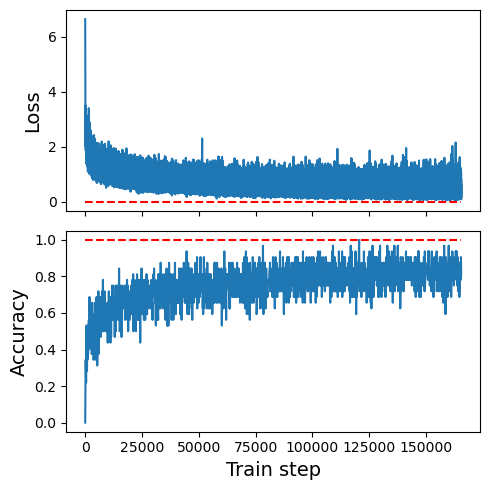

In [44]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [45]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu')
    

# Plotting results

In [46]:
from survey_ops.utils.geometry import angular_separation


## First, visualize healpix's gridding and actual ra, dec of observed fields

In [47]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [48]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

/tmp/ipykernel_9125/415551787.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)


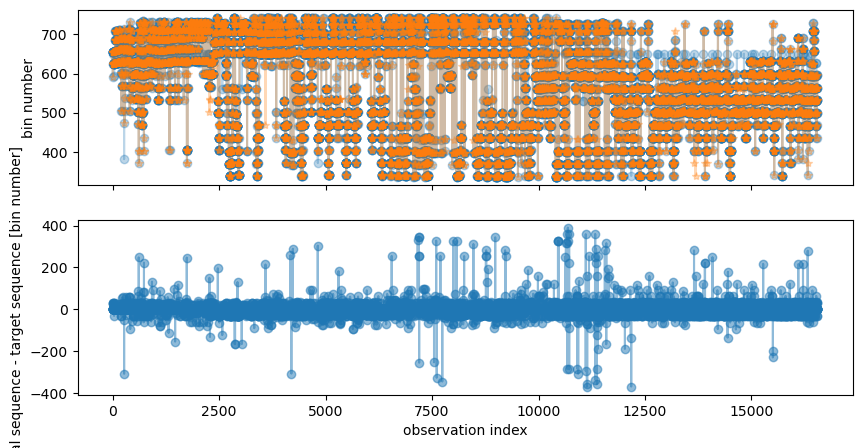

In [49]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(eval_sequence, marker='o', alpha=.3)
axs[0].plot(target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [52]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2015],
    specific_months=[12],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

In [53]:
with torch.no_grad():
    test_q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    test_eval_actions = torch.argmax(test_q_vals, dim=1).to('cpu')

test_target_sequence = test_dataset.actions.detach().numpy()
test_eval_sequence = test_eval_actions.detach().numpy()

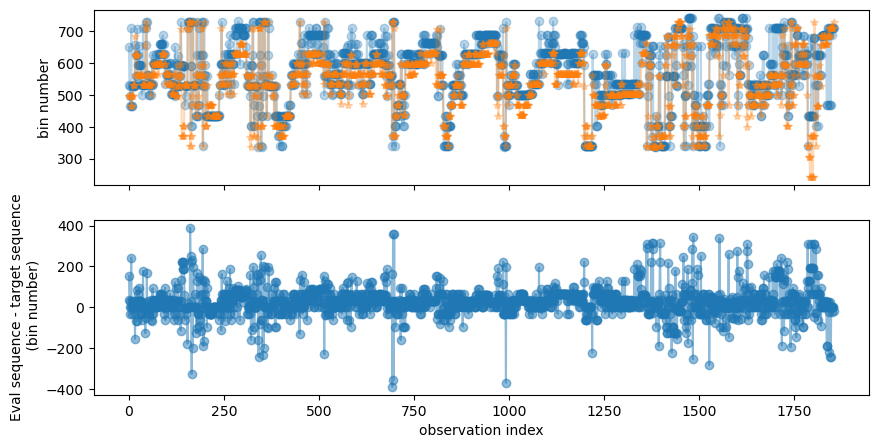

In [58]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(test_eval_sequence, marker='o', alpha=.3)
axs[0].plot(test_target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(test_eval_sequence - test_target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence\n (bin number)')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'test_eval_and_target_bin_sequences.png')

In [55]:
import random

In [56]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_target_sequence])

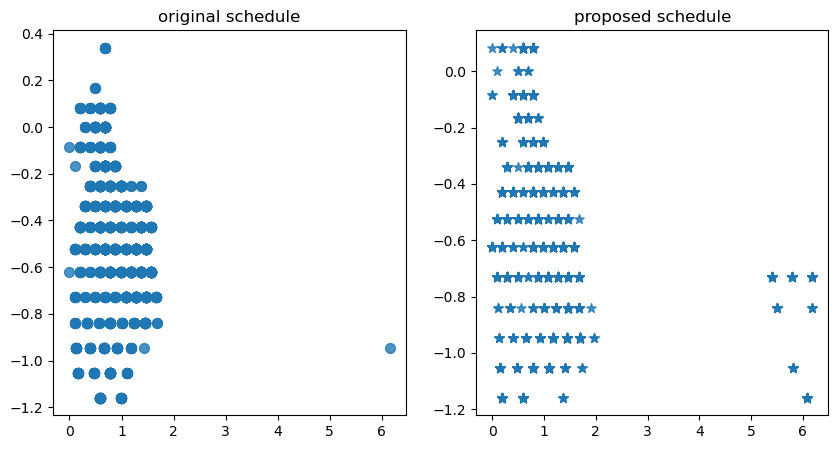

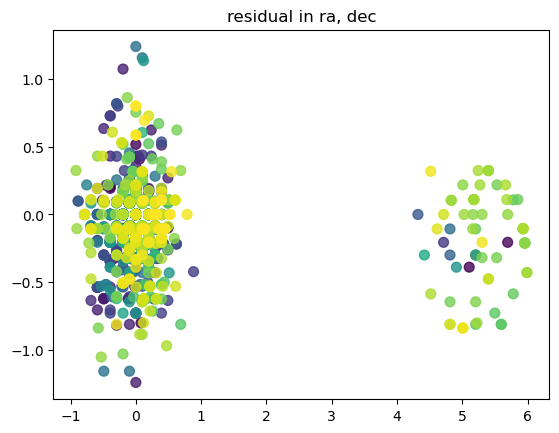

In [57]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], s=50, alpha=.8)
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], alpha=.8, s=50, marker='*')
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();
